## Prediction of Housing Prices in the US

By He,X.

The time series analysis will be performed to explore median housing value at each zip code between 1997 and 2020 and find out which three zip codes would provide the best investment opportunity for SREIT. The time series analysis will be performed to explore median housing value at each zip code between 1997 and 2020 and find out which three zip codes would provide the best investment opportunity. 

In [2]:
## Referenced MILLER (2015) and BROWNLEE (2016)
## Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
from pandas import DataFrame
from datetime import datetime

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from prophet import Prophet

In [3]:
# The data was Zillow Home Value Index (ZHVI) from single family home by zip code
zhvi = pd.read_csv('http://files.zillowstatic.com/research/public_csvs/zhvi/Zip_zhvi_uc_sfr_month.csv ', header=0)
  
#zhvi = zhvi.sort_index()
print(zhvi.head())
print(zhvi.shape)
print(zhvi.tail())

   RegionID  SizeRank  RegionName RegionType StateName State      City  \
0     91940         0       77449        zip        TX    TX       NaN   
1     91982         1       77494        zip        TX    TX       NaN   
2     93144         2       79936        zip        TX    TX   El Paso   
3     62080         3       11368        zip        NY    NY  New York   
4     62093         4       11385        zip        NY    NY  New York   

                                   Metro        CountyName     1996-01-31  \
0   Houston-The Woodlands-Sugar Land, TX     Harris County  101945.334948   
1   Houston-The Woodlands-Sugar Land, TX  Fort Bend County  178650.114244   
2                            El Paso, TX    El Paso County   86162.780396   
3  New York-Newark-Jersey City, NY-NJ-PA     Queens County  248286.386565   
4  New York-Newark-Jersey City, NY-NJ-PA     Queens County  201066.009715   

   ...     2022-03-31     2022-04-30     2022-05-31     2022-06-30  \
0  ...  276902.856202 

In [4]:
#check how many null values are in the data set
zhvi.isnull().sum()

RegionID        0
SizeRank        0
RegionName      0
RegionType      0
StateName       0
             ... 
2022-08-31    152
2022-09-30    148
2022-10-31    100
2022-11-30    154
2022-12-31     23
Length: 333, dtype: int64

In [5]:
#remove rows that contain any null value in housing value columns
column_names = zhvi.columns
zhvi = zhvi.dropna(subset= column_names[9:], axis=0)
#zhvi = zhvi.dropna(axis=0)

In [6]:
#check the records after removing null values
print(zhvi.shape)

print('Number of Metro Area: ', len(set(zhvi['Metro'])))
print('Number of State: ', len(set(zhvi['State'])))
print('Number of City: ', len(set(zhvi['City'])))

(8753, 333)
Number of Metro Area:  445
Number of State:  45
Number of City:  4788


In [7]:
#check the names of states
print('ordered_state_names: \n', sorted(set(zhvi['State'])))

ordered_state_names: 
 ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'NC', 'NE', 'NH', 'NJ', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV']


In [8]:
#check the names of metro areas
print('ordered_metro_names: \n', set(zhvi['Metro']))

ordered_metro_names: 
 {nan, 'Lewisburg, TN', 'Richmond, VA', 'Russellville, AR', 'Batavia, NY', 'Lansing-East Lansing, MI', 'Rockford, IL', 'McAlester, OK', 'El Centro, CA', 'Selma, AL', 'Huntington-Ashland, WV-KY-OH', 'Portsmouth, OH', 'Daphne-Fairhope-Foley, AL', 'Springfield, MA', 'Modesto, CA', 'Scranton--Wilkes-Barre, PA', 'Vallejo, CA', 'Tahlequah, OK', 'Huntsville, TX', 'Lebanon, NH-VT', 'Walla Walla, WA', 'Berlin, NH', 'Durham-Chapel Hill, NC', 'Port St. Lucie, FL', 'Oklahoma City, OK', 'Newport, OR', 'Fort Wayne, IN', 'Hope, AR', 'Albany, GA', 'Toccoa, GA', 'Kansas City, MO-KS', 'Bellingham, WA', 'Mansfield, OH', 'Ardmore, OK', 'Akron, OH', 'Lawrenceburg, TN', 'Marquette, MI', 'Baltimore-Columbia-Towson, MD', 'Malone, NY', 'Storm Lake, IA', 'Augusta-Waterville, ME', 'Boulder, CO', 'McMinnville, TN', 'Seneca Falls, NY', 'Chambersburg-Waynesboro, PA', 'Tifton, GA', 'Denver-Aurora-Lakewood, CO', 'Findlay, OH', 'Lebanon, PA', 'Spartanburg, SC', 'Bucyrus-Galion, OH', 'Vineyard Hav

In [9]:
#prepare alldata that only includes columns we need
zhvi = zhvi.drop(['RegionID', 'RegionType', 'StateName', 'CountyName'], axis=1)

print(zhvi)

       SizeRank  RegionName State          City  \
0             0       77449    TX           NaN   
1             1       77494    TX           NaN   
2             2       79936    TX       El Paso   
4             4       11385    NY      New York   
7             7       77084    TX       Houston   
...         ...         ...   ...           ...   
29759     30657       12489    NY     Wawarsing   
29765     30657       21720    MD    Smithsburg   
29823     30657       21862    MD        Berlin   
29829     30657       34250    FL    Terra Ceia   
29830     30657       33877    FL  Winter Haven   

                                       Metro     1996-01-31     1996-02-29  \
0       Houston-The Woodlands-Sugar Land, TX  101945.334948  101695.067822   
1       Houston-The Woodlands-Sugar Land, TX  178650.114244  182292.820919   
2                                El Paso, TX   86162.780396   85875.220478   
4      New York-Newark-Jersey City, NY-NJ-PA  201066.009715  198834.171121 

### Overall Data Exploration

In [10]:
#convert alldata to a new data frame where the record for each month became a row
final_df = zhvi.melt(id_vars=['SizeRank', 'RegionName','State', 'City', 'Metro',], 
        var_name="Date", 
        value_name="Value")

print(final_df)

         SizeRank  RegionName State          City  \
0               0       77449    TX           NaN   
1               1       77494    TX           NaN   
2               2       79936    TX       El Paso   
3               4       11385    NY      New York   
4               7       77084    TX       Houston   
...           ...         ...   ...           ...   
2835967     30657       12489    NY     Wawarsing   
2835968     30657       21720    MD    Smithsburg   
2835969     30657       21862    MD        Berlin   
2835970     30657       34250    FL    Terra Ceia   
2835971     30657       33877    FL  Winter Haven   

                                         Metro        Date          Value  
0         Houston-The Woodlands-Sugar Land, TX  1996-01-31  101945.334948  
1         Houston-The Woodlands-Sugar Land, TX  1996-01-31  178650.114244  
2                                  El Paso, TX  1996-01-31   86162.780396  
3        New York-Newark-Jersey City, NY-NJ-PA  1996-01-31 

In [11]:
#Add Year column to only save the year of each record
final_df['Year'] = final_df['Date'].str[:4]
final_df['Year'] = final_df['Year'].apply(pd.to_numeric)

#only use data from 1997
final_df = final_df[final_df['Year'] > 1996]
final_df = final_df.reset_index(drop=True)

#### Explore Entire Housing Price Data

[]

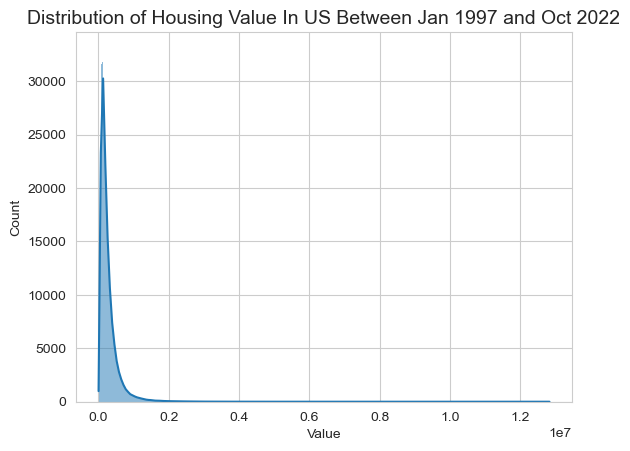

In [12]:
#exploratory data analysis: plot the distribution of SchoolPay
sb.set_style('whitegrid')
sb.histplot(x=final_df['Value'],
           kde = True)
plt.title('Distribution of Housing Value In US Between Jan 1997 and Oct 2022', fontdict = {'fontsize': 14})
plt.plot()

In [13]:
print(final_df['Value'].describe())

count    2.730936e+06
mean     2.870012e+05
std      3.201565e+05
min      7.618906e+03
25%      1.220930e+05
50%      1.999880e+05
75%      3.406603e+05
max      1.283025e+07
Name: Value, dtype: float64


[]

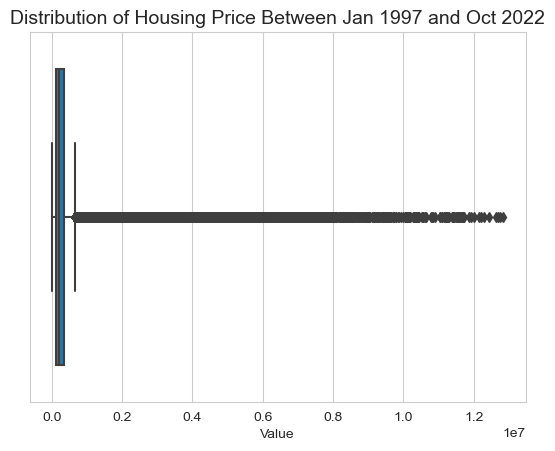

In [14]:
#create a box plot
sb.boxplot(x = final_df['Value'])
plt.title('Distribution of Housing Price Between Jan 1997 and Oct 2022', fontdict = {'fontsize': 14})
plt.plot()

#### Develop time series plots for the following Arkansas metro areas: Hot Springs, Little Rock, Fayetteville, Searcy
• Present all values from 1997 to present
• Average at the metro area level

In [16]:
#Create subset of data that only includes the above mentioned four Arkansas metro areas.
AR_df = final_df.loc[final_df['Metro'].isin(['Hot Springs, AR', 'Little Rock-North Little Rock-Conway, AR', 'Fayetteville-Springdale-Rogers, AR', 'Searcy, AR'])]
print(AR_df.shape)
print(AR_df)

(19968, 8)
         SizeRank  RegionName State          City  \
427           685       72764    AR    Springdale   
913          1522       72756    AR        Rogers   
916          1526       72712    AR   Bentonville   
1041         1742       72076    AR  Jacksonville   
1076         1803       72758    AR        Rogers   
...           ...         ...   ...           ...   
2730335     25652       72001    AR         Adona   
2730395     26178       72776    AR        Witter   
2730407     26327       72072    AR           NaN   
2730436     26708       72079    AR     Jefferson   
2730794     30657       72061    AR           NaN   

                                            Metro        Date          Value  \
427            Fayetteville-Springdale-Rogers, AR  1997-01-31  100269.219525   
913            Fayetteville-Springdale-Rogers, AR  1997-01-31   95997.338033   
916            Fayetteville-Springdale-Rogers, AR  1997-01-31  149404.270406   
1041     Little Rock-North Littl

In [17]:
#remove irrelevant columns
AR_df = AR_df.iloc[: , 4:7]

In [18]:
#perform group by to get dataframe that includes the average median housing price of each Metro
grouped_AR = AR_df.groupby(['Metro','Date']).agg('mean')
grouped_AR = grouped_AR.reset_index()
print(grouped_AR)

                                   Metro        Date          Value
0     Fayetteville-Springdale-Rogers, AR  1997-01-31   97936.645280
1     Fayetteville-Springdale-Rogers, AR  1997-02-28   98250.356906
2     Fayetteville-Springdale-Rogers, AR  1997-03-31   98924.279793
3     Fayetteville-Springdale-Rogers, AR  1997-04-30  100245.489663
4     Fayetteville-Springdale-Rogers, AR  1997-05-31  100074.907395
...                                  ...         ...            ...
1243                          Searcy, AR  2022-08-31  169385.234882
1244                          Searcy, AR  2022-09-30  171832.957778
1245                          Searcy, AR  2022-10-31  174145.284860
1246                          Searcy, AR  2022-11-30  177367.114565
1247                          Searcy, AR  2022-12-31  180413.508133

[1248 rows x 3 columns]


[]

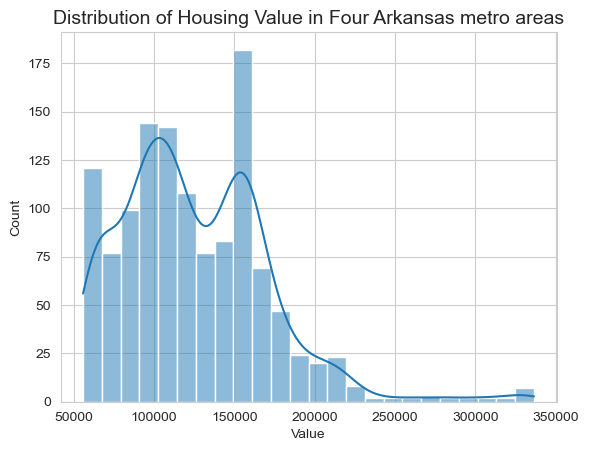

In [19]:
#exploratory data analysis: plot the distribution of housing price in four AR Metro Areas
sb.set_style('whitegrid')
sb.histplot(x=grouped_AR['Value'],
           kde = True)
plt.title('Distribution of Housing Value in Four Arkansas metro areas', fontdict = {'fontsize': 14})
plt.plot()

[]

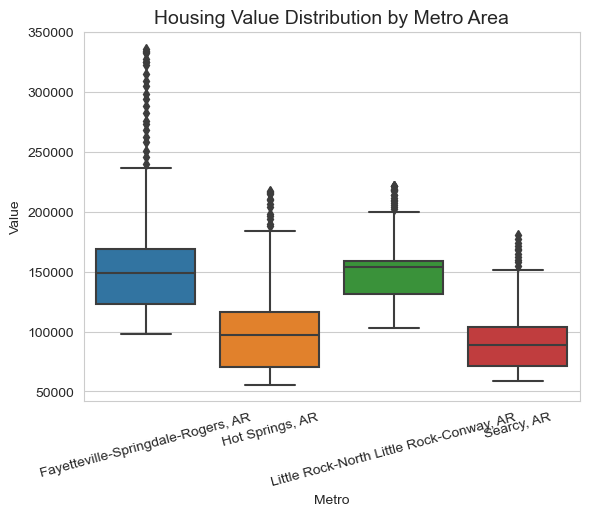

In [20]:
# review distributions of housing prices in each area
sb.boxplot(x = grouped_AR['Metro'],
            y = grouped_AR['Value'])
plt.title('Housing Value Distribution by Metro Area', fontdict = {'fontsize': 14})
plt.xticks(rotation = 15)
plt.plot()

In [21]:
#prepare data for time series analysis
final_AR = grouped_AR[grouped_AR['Metro'] == 'Fayetteville-Springdale-Rogers, AR'][['Date']]
final_AR['Fayetteville'] = grouped_AR[grouped_AR['Metro'] == 'Fayetteville-Springdale-Rogers, AR'][['Value']]
final_AR['Hot_Springs'] = grouped_AR[grouped_AR['Metro'] == 'Hot Springs, AR'][['Value']].reset_index(drop=True)
final_AR['Little_Rock'] = grouped_AR[grouped_AR['Metro'] == 'Little Rock-North Little Rock-Conway, AR'][['Value']].reset_index(drop=True)
final_AR['Searcy'] = grouped_AR[grouped_AR['Metro'] == 'Searcy, AR'][['Value']].reset_index(drop=True)

#set Date column as index
final_AR = final_AR.set_index('Date')
print(final_AR)

             Fayetteville    Hot_Springs    Little_Rock         Searcy
Date                                                                  
1997-01-31   97936.645280   56660.271417  102869.655014   59106.503469
1997-02-28   98250.356906   59057.726726  103234.353468   59736.045221
1997-03-31   98924.279793   58320.299088  103045.931232   60086.161726
1997-04-30  100245.489663   57532.255328  103336.291329   59682.736896
1997-05-31  100074.907395   58560.904154  103490.654304   59598.436371
...                   ...            ...            ...            ...
2022-08-31  327614.323450  209985.263934  217606.185526  169385.234882
2022-09-30  332771.826680  214551.102854  221319.969625  171832.957778
2022-10-31  333261.295113  217276.153402  221573.998120  174145.284860
2022-11-30  334494.518881  216549.352072  221997.652468  177367.114565
2022-12-31  336411.081753  215690.521192  218606.756425  180413.508133

[312 rows x 4 columns]


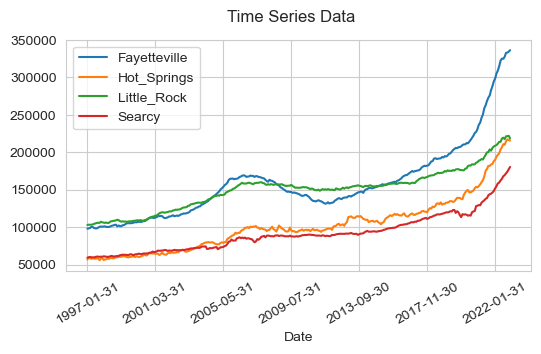

In [22]:
# Line plots of time series
sb.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(6,3))
fig.suptitle('Time Series Data')
final_AR.plot(ax=ax)
plt.xticks(rotation = 30)
plt.show()

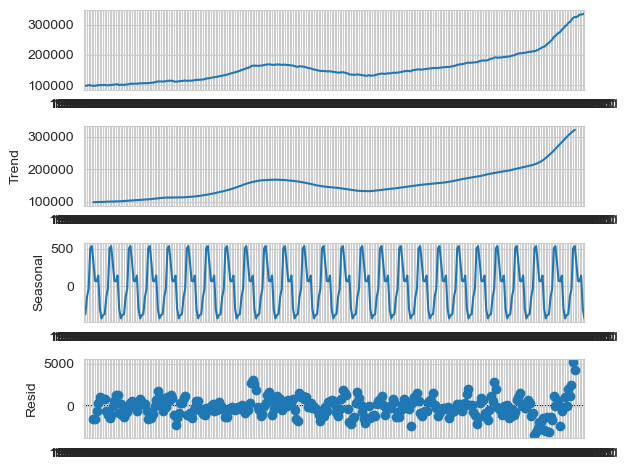

In [23]:
# Plot decomposed the series data
decomp = seasonal_decompose(final_AR[['Fayetteville']], period = 12)
decomp.plot()
plt.show()

In [24]:
# define a function to check stationary for any series
def check_stationary (df, name):
    series = df[[name]]
    result = adfuller(series,autolag='AIC')
    return('p-value: %f' % result[1])

In [25]:
# check stationarity for each series
print('Result for Fayetteville: ', check_stationary(final_AR,'Fayetteville'))
print('Result for Hot_Springs: ',check_stationary(final_AR,'Hot_Springs'))
print('Result for Little_Rock: ',check_stationary(final_AR,'Little_Rock'))
print('Result for Searcy: ',check_stationary(final_AR,'Searcy'))

Result for Fayetteville:  p-value: 0.985817
Result for Hot_Springs:  p-value: 0.998725
Result for Little_Rock:  p-value: 0.980034
Result for Searcy:  p-value: 0.999057


In [26]:
# define a function to check stationary after first order differencing
def check_stationary_diff1 (df, name):
    series = df[[name]]
    series_diff1 = series.diff()
    series_diff1.dropna(inplace=True)
    result = adfuller(series_diff1,autolag='AIC')
    return('p-value: %f' % result[1])

In [27]:
# check stationarity for each series
print('Result for Fayetteville: ', check_stationary_diff1(final_AR,'Fayetteville'))
print('Result for Hot_Springs: ',check_stationary_diff1(final_AR,'Hot_Springs'))
print('Result for Little_Rock: ',check_stationary_diff1(final_AR,'Little_Rock'))
print('Result for Searcy: ',check_stationary_diff1(final_AR,'Searcy'))

Result for Fayetteville:  p-value: 0.068811
Result for Hot_Springs:  p-value: 0.010167
Result for Little_Rock:  p-value: 0.003185
Result for Searcy:  p-value: 0.526781


In [28]:
print(final_AR.index)

Index(['1997-01-31', '1997-02-28', '1997-03-31', '1997-04-30', '1997-05-31',
       '1997-06-30', '1997-07-31', '1997-08-31', '1997-09-30', '1997-10-31',
       ...
       '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30', '2022-07-31',
       '2022-08-31', '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31'],
      dtype='object', name='Date', length=312)


In [29]:
#Create a dataframe that includes series with first order differencing
final_AR_diff1 = pd.DataFrame()
final_AR_diff1['Fayetteville_diff1'] = final_AR['Fayetteville'].diff()
final_AR_diff1['Hot_Springs_diff1'] = final_AR['Hot_Springs'].diff()
final_AR_diff1['Little_Rock_diff1'] = final_AR['Little_Rock'].diff()
final_AR_diff1['Searcy_diff1'] = final_AR['Searcy'].diff()
final_AR_diff1 = final_AR_diff1.dropna(axis=0)

In [30]:
print(final_AR_diff1)

            Fayetteville_diff1  Hot_Springs_diff1  Little_Rock_diff1  \
Date                                                                   
1997-02-28          313.711626        2397.455308         364.698454   
1997-03-31          673.922887        -737.427638        -188.422237   
1997-04-30         1321.209870        -788.043760         290.360097   
1997-05-31         -170.582268        1028.648826         154.362976   
1997-06-30        -1358.649141        -587.126779         920.900153   
...                        ...                ...                ...   
2022-08-31         2696.971083        -859.432688       -1889.020885   
2022-09-30         5157.503230        4565.838919        3713.784099   
2022-10-31          489.468433        2725.050549         254.028495   
2022-11-30         1233.223767        -726.801331         423.654348   
2022-12-31         1916.562872        -858.830879       -3390.896043   

            Searcy_diff1  
Date                      
1997-02-2

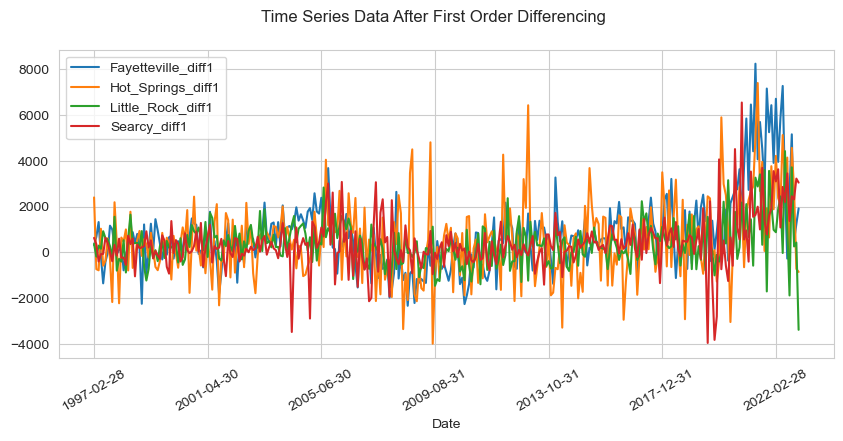

In [31]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(10,4))
fig.suptitle('Time Series Data After First Order Differencing')
final_AR_diff1.plot(ax=ax)
plt.xticks(rotation = 30)
plt.show()

In [27]:
#First order differencing didn't remove non-stationary for every time series

In [32]:
# Check stationary after second order differencing
def check_stationary_diff2 (df, name):
    series = df[[name]]
    series_diff2 = series.diff().diff()
    series_diff2.dropna(inplace=True)
    result = adfuller(series_diff2,autolag='AIC')
    return('p-value: %f' % result[1])

In [33]:
print('Result for Fayetteville: ', check_stationary_diff2(final_AR,'Fayetteville'))
print('Result for Hot_Springs: ',check_stationary_diff2(final_AR,'Hot_Springs'))
print('Result for Little_Rock: ',check_stationary_diff2(final_AR,'Little_Rock'))
print('Result for Searcy: ',check_stationary_diff2(final_AR,'Searcy'))

Result for Fayetteville:  p-value: 0.000000
Result for Hot_Springs:  p-value: 0.000000
Result for Little_Rock:  p-value: 0.000000
Result for Searcy:  p-value: 0.000000


In [34]:
#Create a dataframe that includes series with second order differencing
final_AR_diff2 = pd.DataFrame()
final_AR_diff2['Fayetteville_diff2'] = final_AR['Fayetteville'].diff().diff()
final_AR_diff2['Hot_Springs_diff2'] = final_AR['Hot_Springs'].diff().diff()
final_AR_diff2['Little_Rock_diff2'] = final_AR['Little_Rock'].diff().diff()
final_AR_diff2['Searcy_diff2'] = final_AR['Searcy'].diff().diff()
final_AR_diff2 = final_AR_diff2.dropna(axis=0)

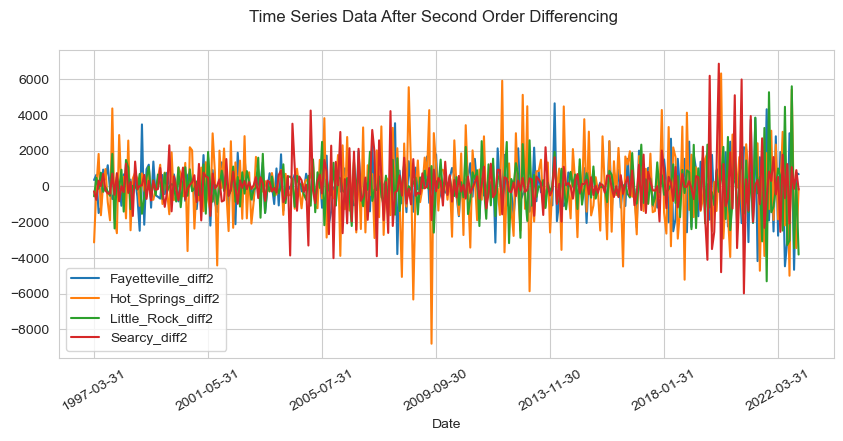

In [35]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(10,4))
fig.suptitle('Time Series Data After Second Order Differencing')
final_AR_diff2.plot(ax=ax)
plt.xticks(rotation = 30)
plt.show()

In [32]:
#Second order differencing removed non-stationary for all regions tested above

In [36]:
#ask jupyter notebook to print graphs inline
%matplotlib inline
rcParams['figure.figsize'] = 8,4

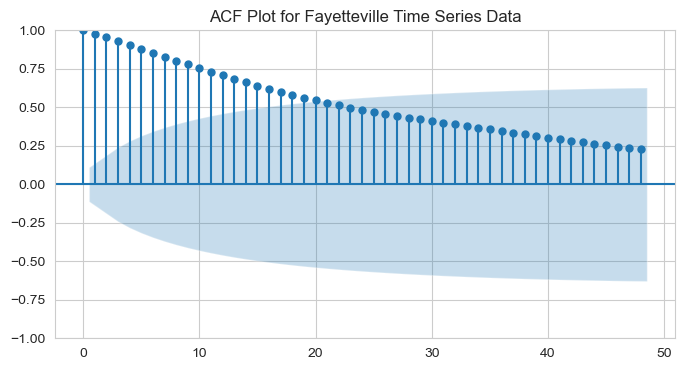

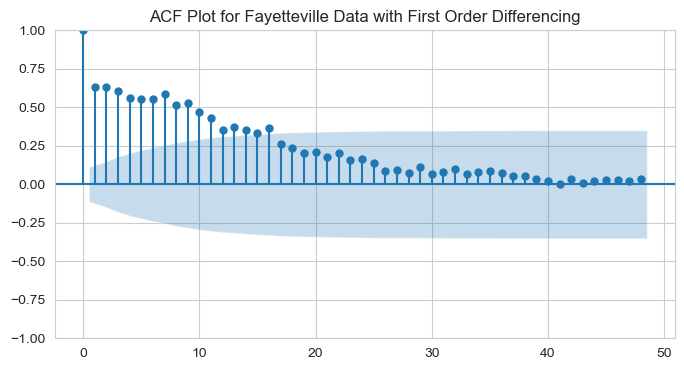

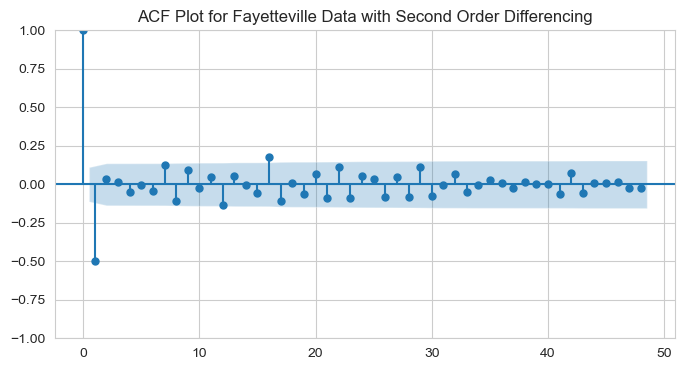

In [37]:
# Look at ACF plots in Fayetteville area
plot_acf(final_AR[['Fayetteville']], lags=48)
plt.title("ACF Plot for Fayetteville Time Series Data")
plt.show()

plot_acf(final_AR_diff1[['Fayetteville_diff1']], lags=48)
plt.title("ACF Plot for Fayetteville Data with First Order Differencing")
plt.show()

plot_acf(final_AR_diff2[['Fayetteville_diff2']], lags=48)
plt.title("ACF Plot for Fayetteville Data with Second Order Differencing")
plt.show()

#### Explore CPI Data

In [41]:
#Read 1997-2020 CPI data
cpi = pd.read_csv('cpi_record.csv', header=0)
print(cpi)

     year period    value
0    2021    M12  278.802
1    2021    M11  277.948
2    2021    M10  276.589
3    2021    M09  274.310
4    2021    M08  273.567
..    ...    ...      ...
295  1997    M05  160.100
296  1997    M04  160.200
297  1997    M03  160.000
298  1997    M02  159.600
299  1997    M01  159.100

[300 rows x 3 columns]


In [42]:
#check how many null values are in the data set
cpi.isnull().sum()

year      0
period    0
value     0
dtype: int64

In [43]:
#change data format and add ds column for yyyy-mm-dd
cpi['period']= cpi['period'].str[-2:]
cpi['ds'] = cpi['year'].astype(str) +"-"+ cpi["period"] +"-01"
cpi = cpi.sort_values('ds')
print(cpi)

     year period    value          ds
299  1997     01  159.100  1997-01-01
298  1997     02  159.600  1997-02-01
297  1997     03  160.000  1997-03-01
296  1997     04  160.200  1997-04-01
295  1997     05  160.100  1997-05-01
..    ...    ...      ...         ...
4    2021     08  273.567  2021-08-01
3    2021     09  274.310  2021-09-01
2    2021     10  276.589  2021-10-01
1    2021     11  277.948  2021-11-01
0    2021     12  278.802  2021-12-01

[300 rows x 4 columns]


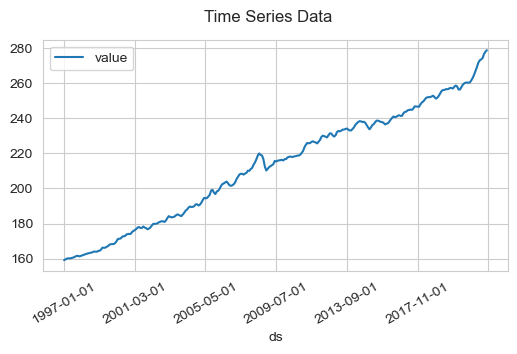

In [44]:
# Line plots of time series
cpi_series = cpi[['ds','value']]
cpi_series = cpi_series.set_index('ds')


fig, ax = plt.subplots(figsize=(6,3))
fig.suptitle('Time Series Data')
cpi_series.plot(ax=ax)
plt.xticks(rotation = 30)
plt.show()

### Model and Analysis

#### Build ARIMA Model Using Housing Price Data

In [45]:
# extract data before 2021 for predictions
model_data = final_df[final_df['Year'] < 2021]

# Rename columns for prophet
model_data = model_data.rename(columns={"Value": "y", "Date": "ds"})
model_data = model_data[['ds','y','RegionName']]
model_data['ds'] = model_data['ds'].str[:7]
model_data['ds'] = model_data['ds'].astype(str) +"-01"
print(model_data.head())

           ds              y  RegionName
0  1997-01-01  101161.485921       77449
1  1997-01-01  189688.893083       77494
2  1997-01-01   86357.126426       79936
3  1997-01-01  201468.266705       11385
4  1997-01-01   97682.948338       77084


In [46]:
# Get list of RegionName names
ordered_RegionNames = (sorted(set(model_data['RegionName'])))
#print('ordered_RegionNames: ', ordered_RegionNames)
print('Total number of unique zip codes: ', len(ordered_RegionNames))

Total number of unique zip codes:  8753


In [47]:
#Create predictions for each month in 2021 for each Zip Code 
region_list = ordered_RegionNames
predictions = pd.DataFrame(columns= ['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'RegionName'])

# run forecasts into 12 months in 2021 for each zip code, and combine data for each zip code to one data set
for region in region_list:
    region_series = model_data.loc[model_data['RegionName'] == region]
    region_series = region_series[['y','ds']]
    
    # MODEL using Prophet - Set the uncertainty interval to 95% (the Prophet default is 80%)
    model = Prophet(interval_width=0.95)
    # fit the model
    model = model.fit(region_series)
    
    #model = fit.prophet(model, df = region_series)
    future_date = model.make_future_dataframe(periods=12, freq='MS')
    forecast = model.predict(future_date)
    forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    #print(forecast)
    forecast['RegionName'] = region

    #append data for current zip code to final prediction result data set
    predictions = pd.concat([predictions,forecast])


21:11:11 - cmdstanpy - INFO - Chain [1] start processing
21:11:11 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:11:11 - cmdstanpy - INFO - Chain [1] start processing
21:11:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:11:12 - cmdstanpy - INFO - Chain [1] start processing
21:11:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and

21:11:18 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:11:18 - cmdstanpy - INFO - Chain [1] start processing
21:11:18 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:11:18 - cmdstanpy - INFO - Chain [1] start processing
21:11:19 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:11:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:11:25 - cmdstanpy - INFO - Chain [1] start processing
21:11:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:11:25 - cmdstanpy - INFO - Chain [1] start processing
21:11:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:11:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:11:31 - cmdstanpy - INFO - Chain [1] start processing
21:11:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:11:32 - cmdstanpy - INFO - Chain [1] start processing
21:11:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:11:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:11:38 - cmdstanpy - INFO - Chain [1] start processing
21:11:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:11:38 - cmdstanpy - INFO - Chain [1] start processing
21:11:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:11:45 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:11:45 - cmdstanpy - INFO - Chain [1] start processing
21:11:45 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:11:45 - cmdstanpy - INFO - Chain [1] start processing
21:11:46 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:11:52 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:11:52 - cmdstanpy - INFO - Chain [1] start processing
21:11:53 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:11:53 - cmdstanpy - INFO - Chain [1] start processing
21:11:53 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:12:00 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:12:00 - cmdstanpy - INFO - Chain [1] start processing
21:12:00 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:12:00 - cmdstanpy - INFO - Chain [1] start processing
21:12:00 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:12:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:12:07 - cmdstanpy - INFO - Chain [1] start processing
21:12:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:12:08 - cmdstanpy - INFO - Chain [1] start processing
21:12:08 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:12:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:12:15 - cmdstanpy - INFO - Chain [1] start processing
21:12:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:12:15 - cmdstanpy - INFO - Chain [1] start processing
21:12:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:12:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:12:22 - cmdstanpy - INFO - Chain [1] start processing
21:12:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:12:22 - cmdstanpy - INFO - Chain [1] start processing
21:12:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:12:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:12:29 - cmdstanpy - INFO - Chain [1] start processing
21:12:30 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:12:30 - cmdstanpy - INFO - Chain [1] start processing
21:12:30 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:12:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:12:37 - cmdstanpy - INFO - Chain [1] start processing
21:12:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:12:37 - cmdstanpy - INFO - Chain [1] start processing
21:12:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:12:44 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:12:45 - cmdstanpy - INFO - Chain [1] start processing
21:12:45 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:12:45 - cmdstanpy - INFO - Chain [1] start processing
21:12:45 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:12:52 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:12:52 - cmdstanpy - INFO - Chain [1] start processing
21:12:52 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:12:52 - cmdstanpy - INFO - Chain [1] start processing
21:12:52 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:12:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:12:59 - cmdstanpy - INFO - Chain [1] start processing
21:12:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:13:00 - cmdstanpy - INFO - Chain [1] start processing
21:13:00 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:13:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:13:07 - cmdstanpy - INFO - Chain [1] start processing
21:13:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:13:07 - cmdstanpy - INFO - Chain [1] start processing
21:13:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:13:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:13:14 - cmdstanpy - INFO - Chain [1] start processing
21:13:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:13:14 - cmdstanpy - INFO - Chain [1] start processing
21:13:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:13:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:13:21 - cmdstanpy - INFO - Chain [1] start processing
21:13:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:13:22 - cmdstanpy - INFO - Chain [1] start processing
21:13:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:13:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:13:29 - cmdstanpy - INFO - Chain [1] start processing
21:13:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:13:29 - cmdstanpy - INFO - Chain [1] start processing
21:13:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:13:36 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:13:36 - cmdstanpy - INFO - Chain [1] start processing
21:13:36 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:13:37 - cmdstanpy - INFO - Chain [1] start processing
21:13:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:13:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:13:44 - cmdstanpy - INFO - Chain [1] start processing
21:13:44 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:13:44 - cmdstanpy - INFO - Chain [1] start processing
21:13:44 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:13:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:13:51 - cmdstanpy - INFO - Chain [1] start processing
21:13:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:13:51 - cmdstanpy - INFO - Chain [1] start processing
21:13:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:13:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:13:58 - cmdstanpy - INFO - Chain [1] start processing
21:13:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:13:58 - cmdstanpy - INFO - Chain [1] start processing
21:13:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:14:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:14:05 - cmdstanpy - INFO - Chain [1] start processing
21:14:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:14:05 - cmdstanpy - INFO - Chain [1] start processing
21:14:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:14:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:14:12 - cmdstanpy - INFO - Chain [1] start processing
21:14:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:14:12 - cmdstanpy - INFO - Chain [1] start processing
21:14:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:14:19 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:14:19 - cmdstanpy - INFO - Chain [1] start processing
21:14:19 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:14:19 - cmdstanpy - INFO - Chain [1] start processing
21:14:19 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:14:26 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:14:26 - cmdstanpy - INFO - Chain [1] start processing
21:14:26 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:14:26 - cmdstanpy - INFO - Chain [1] start processing
21:14:27 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:14:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:14:33 - cmdstanpy - INFO - Chain [1] start processing
21:14:34 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:14:34 - cmdstanpy - INFO - Chain [1] start processing
21:14:34 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:14:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:14:41 - cmdstanpy - INFO - Chain [1] start processing
21:14:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:14:41 - cmdstanpy - INFO - Chain [1] start processing
21:14:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:14:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:14:48 - cmdstanpy - INFO - Chain [1] start processing
21:14:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:14:49 - cmdstanpy - INFO - Chain [1] start processing
21:14:49 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:14:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:14:55 - cmdstanpy - INFO - Chain [1] start processing
21:14:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:14:56 - cmdstanpy - INFO - Chain [1] start processing
21:14:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:15:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:15:03 - cmdstanpy - INFO - Chain [1] start processing
21:15:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:15:03 - cmdstanpy - INFO - Chain [1] start processing
21:15:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:15:10 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:15:10 - cmdstanpy - INFO - Chain [1] start processing
21:15:10 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:15:11 - cmdstanpy - INFO - Chain [1] start processing
21:15:11 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:15:18 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:15:18 - cmdstanpy - INFO - Chain [1] start processing
21:15:18 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:15:18 - cmdstanpy - INFO - Chain [1] start processing
21:15:18 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:15:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:15:25 - cmdstanpy - INFO - Chain [1] start processing
21:15:26 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:15:26 - cmdstanpy - INFO - Chain [1] start processing
21:15:26 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:15:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:15:33 - cmdstanpy - INFO - Chain [1] start processing
21:15:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:15:33 - cmdstanpy - INFO - Chain [1] start processing
21:15:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:15:40 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:15:41 - cmdstanpy - INFO - Chain [1] start processing
21:15:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:15:41 - cmdstanpy - INFO - Chain [1] start processing
21:15:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:15:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:15:48 - cmdstanpy - INFO - Chain [1] start processing
21:15:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:15:48 - cmdstanpy - INFO - Chain [1] start processing
21:15:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:15:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:15:56 - cmdstanpy - INFO - Chain [1] start processing
21:15:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:15:56 - cmdstanpy - INFO - Chain [1] start processing
21:15:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:16:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:16:03 - cmdstanpy - INFO - Chain [1] start processing
21:16:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:16:03 - cmdstanpy - INFO - Chain [1] start processing
21:16:04 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:16:10 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:16:10 - cmdstanpy - INFO - Chain [1] start processing
21:16:11 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:16:11 - cmdstanpy - INFO - Chain [1] start processing
21:16:11 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:16:18 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:16:18 - cmdstanpy - INFO - Chain [1] start processing
21:16:18 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:16:18 - cmdstanpy - INFO - Chain [1] start processing
21:16:18 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:16:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:16:25 - cmdstanpy - INFO - Chain [1] start processing
21:16:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:16:26 - cmdstanpy - INFO - Chain [1] start processing
21:16:26 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:16:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:16:32 - cmdstanpy - INFO - Chain [1] start processing
21:16:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:16:33 - cmdstanpy - INFO - Chain [1] start processing
21:16:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:16:39 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:16:40 - cmdstanpy - INFO - Chain [1] start processing
21:16:40 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:16:40 - cmdstanpy - INFO - Chain [1] start processing
21:16:40 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:16:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:16:47 - cmdstanpy - INFO - Chain [1] start processing
21:16:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:16:48 - cmdstanpy - INFO - Chain [1] start processing
21:16:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:16:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:16:55 - cmdstanpy - INFO - Chain [1] start processing
21:16:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:16:55 - cmdstanpy - INFO - Chain [1] start processing
21:16:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:17:02 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:17:02 - cmdstanpy - INFO - Chain [1] start processing
21:17:02 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:17:03 - cmdstanpy - INFO - Chain [1] start processing
21:17:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:17:09 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:17:09 - cmdstanpy - INFO - Chain [1] start processing
21:17:09 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:17:09 - cmdstanpy - INFO - Chain [1] start processing
21:17:09 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:17:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:17:16 - cmdstanpy - INFO - Chain [1] start processing
21:17:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:17:16 - cmdstanpy - INFO - Chain [1] start processing
21:17:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:17:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:17:23 - cmdstanpy - INFO - Chain [1] start processing
21:17:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:17:23 - cmdstanpy - INFO - Chain [1] start processing
21:17:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:17:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:17:29 - cmdstanpy - INFO - Chain [1] start processing
21:17:30 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:17:30 - cmdstanpy - INFO - Chain [1] start processing
21:17:30 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:17:36 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:17:36 - cmdstanpy - INFO - Chain [1] start processing
21:17:36 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:17:37 - cmdstanpy - INFO - Chain [1] start processing
21:17:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:17:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:17:43 - cmdstanpy - INFO - Chain [1] start processing
21:17:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:17:44 - cmdstanpy - INFO - Chain [1] start processing
21:17:44 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:17:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:17:50 - cmdstanpy - INFO - Chain [1] start processing
21:17:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:17:51 - cmdstanpy - INFO - Chain [1] start processing
21:17:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:17:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:17:57 - cmdstanpy - INFO - Chain [1] start processing
21:17:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:17:57 - cmdstanpy - INFO - Chain [1] start processing
21:17:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:18:04 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:18:04 - cmdstanpy - INFO - Chain [1] start processing
21:18:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:18:05 - cmdstanpy - INFO - Chain [1] start processing
21:18:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:18:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:18:12 - cmdstanpy - INFO - Chain [1] start processing
21:18:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:18:13 - cmdstanpy - INFO - Chain [1] start processing
21:18:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:18:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:18:20 - cmdstanpy - INFO - Chain [1] start processing
21:18:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:18:20 - cmdstanpy - INFO - Chain [1] start processing
21:18:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:18:27 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:18:28 - cmdstanpy - INFO - Chain [1] start processing
21:18:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:18:28 - cmdstanpy - INFO - Chain [1] start processing
21:18:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:18:35 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:18:35 - cmdstanpy - INFO - Chain [1] start processing
21:18:36 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:18:36 - cmdstanpy - INFO - Chain [1] start processing
21:18:36 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:18:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:18:43 - cmdstanpy - INFO - Chain [1] start processing
21:18:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:18:43 - cmdstanpy - INFO - Chain [1] start processing
21:18:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:18:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:18:50 - cmdstanpy - INFO - Chain [1] start processing
21:18:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:18:51 - cmdstanpy - INFO - Chain [1] start processing
21:18:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:18:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:18:58 - cmdstanpy - INFO - Chain [1] start processing
21:18:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:18:58 - cmdstanpy - INFO - Chain [1] start processing
21:18:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:19:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:19:05 - cmdstanpy - INFO - Chain [1] start processing
21:19:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:19:06 - cmdstanpy - INFO - Chain [1] start processing
21:19:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:19:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:19:13 - cmdstanpy - INFO - Chain [1] start processing
21:19:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:19:13 - cmdstanpy - INFO - Chain [1] start processing
21:19:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:19:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:19:20 - cmdstanpy - INFO - Chain [1] start processing
21:19:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:19:21 - cmdstanpy - INFO - Chain [1] start processing
21:19:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:19:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:19:28 - cmdstanpy - INFO - Chain [1] start processing
21:19:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:19:28 - cmdstanpy - INFO - Chain [1] start processing
21:19:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:19:35 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:19:35 - cmdstanpy - INFO - Chain [1] start processing
21:19:35 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:19:35 - cmdstanpy - INFO - Chain [1] start processing
21:19:35 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:19:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:19:42 - cmdstanpy - INFO - Chain [1] start processing
21:19:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:19:43 - cmdstanpy - INFO - Chain [1] start processing
21:19:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:19:49 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:19:50 - cmdstanpy - INFO - Chain [1] start processing
21:19:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:19:50 - cmdstanpy - INFO - Chain [1] start processing
21:19:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:19:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:19:57 - cmdstanpy - INFO - Chain [1] start processing
21:19:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:19:57 - cmdstanpy - INFO - Chain [1] start processing
21:19:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:20:04 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:20:04 - cmdstanpy - INFO - Chain [1] start processing
21:20:04 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:20:04 - cmdstanpy - INFO - Chain [1] start processing
21:20:04 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:20:11 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:20:11 - cmdstanpy - INFO - Chain [1] start processing
21:20:11 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:20:12 - cmdstanpy - INFO - Chain [1] start processing
21:20:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:20:18 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:20:19 - cmdstanpy - INFO - Chain [1] start processing
21:20:19 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:20:19 - cmdstanpy - INFO - Chain [1] start processing
21:20:19 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:20:26 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:20:26 - cmdstanpy - INFO - Chain [1] start processing
21:20:26 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:20:26 - cmdstanpy - INFO - Chain [1] start processing
21:20:26 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:20:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:20:33 - cmdstanpy - INFO - Chain [1] start processing
21:20:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:20:34 - cmdstanpy - INFO - Chain [1] start processing
21:20:34 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:20:40 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:20:41 - cmdstanpy - INFO - Chain [1] start processing
21:20:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:20:41 - cmdstanpy - INFO - Chain [1] start processing
21:20:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:20:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:20:48 - cmdstanpy - INFO - Chain [1] start processing
21:20:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:20:48 - cmdstanpy - INFO - Chain [1] start processing
21:20:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:20:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:20:56 - cmdstanpy - INFO - Chain [1] start processing
21:20:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:20:56 - cmdstanpy - INFO - Chain [1] start processing
21:20:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:21:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:21:04 - cmdstanpy - INFO - Chain [1] start processing
21:21:04 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:21:04 - cmdstanpy - INFO - Chain [1] start processing
21:21:04 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:21:11 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:21:11 - cmdstanpy - INFO - Chain [1] start processing
21:21:11 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:21:11 - cmdstanpy - INFO - Chain [1] start processing
21:21:11 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:21:18 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:21:18 - cmdstanpy - INFO - Chain [1] start processing
21:21:18 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:21:19 - cmdstanpy - INFO - Chain [1] start processing
21:21:19 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:21:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:21:26 - cmdstanpy - INFO - Chain [1] start processing
21:21:26 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:21:26 - cmdstanpy - INFO - Chain [1] start processing
21:21:26 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:21:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:21:33 - cmdstanpy - INFO - Chain [1] start processing
21:21:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:21:33 - cmdstanpy - INFO - Chain [1] start processing
21:21:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:21:40 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:21:40 - cmdstanpy - INFO - Chain [1] start processing
21:21:40 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:21:41 - cmdstanpy - INFO - Chain [1] start processing
21:21:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:21:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:21:48 - cmdstanpy - INFO - Chain [1] start processing
21:21:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:21:48 - cmdstanpy - INFO - Chain [1] start processing
21:21:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:21:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:21:55 - cmdstanpy - INFO - Chain [1] start processing
21:21:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:21:55 - cmdstanpy - INFO - Chain [1] start processing
21:21:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:22:02 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:22:02 - cmdstanpy - INFO - Chain [1] start processing
21:22:02 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:22:03 - cmdstanpy - INFO - Chain [1] start processing
21:22:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:22:09 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:22:09 - cmdstanpy - INFO - Chain [1] start processing
21:22:09 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:22:10 - cmdstanpy - INFO - Chain [1] start processing
21:22:10 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:22:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:22:17 - cmdstanpy - INFO - Chain [1] start processing
21:22:17 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:22:17 - cmdstanpy - INFO - Chain [1] start processing
21:22:17 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:22:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:22:24 - cmdstanpy - INFO - Chain [1] start processing
21:22:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:22:24 - cmdstanpy - INFO - Chain [1] start processing
21:22:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:22:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:22:31 - cmdstanpy - INFO - Chain [1] start processing
21:22:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:22:31 - cmdstanpy - INFO - Chain [1] start processing
21:22:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:22:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:22:39 - cmdstanpy - INFO - Chain [1] start processing
21:22:39 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:22:39 - cmdstanpy - INFO - Chain [1] start processing
21:22:39 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:22:46 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:22:46 - cmdstanpy - INFO - Chain [1] start processing
21:22:46 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:22:47 - cmdstanpy - INFO - Chain [1] start processing
21:22:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:22:53 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:22:53 - cmdstanpy - INFO - Chain [1] start processing
21:22:54 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:22:54 - cmdstanpy - INFO - Chain [1] start processing
21:22:54 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:23:00 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:23:00 - cmdstanpy - INFO - Chain [1] start processing
21:23:00 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:23:01 - cmdstanpy - INFO - Chain [1] start processing
21:23:01 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:23:08 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:23:08 - cmdstanpy - INFO - Chain [1] start processing
21:23:08 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:23:08 - cmdstanpy - INFO - Chain [1] start processing
21:23:08 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:23:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:23:16 - cmdstanpy - INFO - Chain [1] start processing
21:23:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:23:16 - cmdstanpy - INFO - Chain [1] start processing
21:23:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:23:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:23:24 - cmdstanpy - INFO - Chain [1] start processing
21:23:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:23:24 - cmdstanpy - INFO - Chain [1] start processing
21:23:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:23:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:23:32 - cmdstanpy - INFO - Chain [1] start processing
21:23:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:23:32 - cmdstanpy - INFO - Chain [1] start processing
21:23:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:23:39 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:23:39 - cmdstanpy - INFO - Chain [1] start processing
21:23:39 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:23:40 - cmdstanpy - INFO - Chain [1] start processing
21:23:40 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:23:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:23:47 - cmdstanpy - INFO - Chain [1] start processing
21:23:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:23:47 - cmdstanpy - INFO - Chain [1] start processing
21:23:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:23:54 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:23:55 - cmdstanpy - INFO - Chain [1] start processing
21:23:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:23:55 - cmdstanpy - INFO - Chain [1] start processing
21:23:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:24:02 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:24:03 - cmdstanpy - INFO - Chain [1] start processing
21:24:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:24:03 - cmdstanpy - INFO - Chain [1] start processing
21:24:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:24:10 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:24:11 - cmdstanpy - INFO - Chain [1] start processing
21:24:11 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:24:11 - cmdstanpy - INFO - Chain [1] start processing
21:24:11 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:24:18 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:24:19 - cmdstanpy - INFO - Chain [1] start processing
21:24:19 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:24:19 - cmdstanpy - INFO - Chain [1] start processing
21:24:19 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:24:27 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:24:27 - cmdstanpy - INFO - Chain [1] start processing
21:24:27 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:24:27 - cmdstanpy - INFO - Chain [1] start processing
21:24:27 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:24:34 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:24:34 - cmdstanpy - INFO - Chain [1] start processing
21:24:35 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:24:35 - cmdstanpy - INFO - Chain [1] start processing
21:24:35 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:24:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:24:42 - cmdstanpy - INFO - Chain [1] start processing
21:24:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:24:43 - cmdstanpy - INFO - Chain [1] start processing
21:24:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:24:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:24:50 - cmdstanpy - INFO - Chain [1] start processing
21:24:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:24:51 - cmdstanpy - INFO - Chain [1] start processing
21:24:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:24:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:24:59 - cmdstanpy - INFO - Chain [1] start processing
21:24:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:24:59 - cmdstanpy - INFO - Chain [1] start processing
21:24:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:25:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:25:07 - cmdstanpy - INFO - Chain [1] start processing
21:25:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:25:07 - cmdstanpy - INFO - Chain [1] start processing
21:25:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:25:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:25:15 - cmdstanpy - INFO - Chain [1] start processing
21:25:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:25:15 - cmdstanpy - INFO - Chain [1] start processing
21:25:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:25:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:25:23 - cmdstanpy - INFO - Chain [1] start processing
21:25:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:25:23 - cmdstanpy - INFO - Chain [1] start processing
21:25:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:25:30 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:25:31 - cmdstanpy - INFO - Chain [1] start processing
21:25:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:25:31 - cmdstanpy - INFO - Chain [1] start processing
21:25:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:25:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:25:39 - cmdstanpy - INFO - Chain [1] start processing
21:25:39 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:25:39 - cmdstanpy - INFO - Chain [1] start processing
21:25:39 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:25:46 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:25:47 - cmdstanpy - INFO - Chain [1] start processing
21:25:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:25:47 - cmdstanpy - INFO - Chain [1] start processing
21:25:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:25:54 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:25:55 - cmdstanpy - INFO - Chain [1] start processing
21:25:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:25:55 - cmdstanpy - INFO - Chain [1] start processing
21:25:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:26:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:26:03 - cmdstanpy - INFO - Chain [1] start processing
21:26:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:26:04 - cmdstanpy - INFO - Chain [1] start processing
21:26:04 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:26:11 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:26:11 - cmdstanpy - INFO - Chain [1] start processing
21:26:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:26:12 - cmdstanpy - INFO - Chain [1] start processing
21:26:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:26:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:26:20 - cmdstanpy - INFO - Chain [1] start processing
21:26:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:26:20 - cmdstanpy - INFO - Chain [1] start processing
21:26:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:26:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:26:28 - cmdstanpy - INFO - Chain [1] start processing
21:26:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:26:29 - cmdstanpy - INFO - Chain [1] start processing
21:26:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:26:36 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:26:36 - cmdstanpy - INFO - Chain [1] start processing
21:26:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:26:37 - cmdstanpy - INFO - Chain [1] start processing
21:26:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:26:44 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:26:45 - cmdstanpy - INFO - Chain [1] start processing
21:26:45 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:26:45 - cmdstanpy - INFO - Chain [1] start processing
21:26:45 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:26:53 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:26:53 - cmdstanpy - INFO - Chain [1] start processing
21:26:53 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:26:53 - cmdstanpy - INFO - Chain [1] start processing
21:26:54 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:27:01 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:27:01 - cmdstanpy - INFO - Chain [1] start processing
21:27:01 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:27:01 - cmdstanpy - INFO - Chain [1] start processing
21:27:02 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:27:09 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:27:09 - cmdstanpy - INFO - Chain [1] start processing
21:27:09 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:27:10 - cmdstanpy - INFO - Chain [1] start processing
21:27:10 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:27:17 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:27:17 - cmdstanpy - INFO - Chain [1] start processing
21:27:17 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:27:18 - cmdstanpy - INFO - Chain [1] start processing
21:27:18 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:27:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:27:25 - cmdstanpy - INFO - Chain [1] start processing
21:27:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:27:26 - cmdstanpy - INFO - Chain [1] start processing
21:27:26 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:27:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:27:33 - cmdstanpy - INFO - Chain [1] start processing
21:27:34 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:27:34 - cmdstanpy - INFO - Chain [1] start processing
21:27:34 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:27:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:27:41 - cmdstanpy - INFO - Chain [1] start processing
21:27:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:27:42 - cmdstanpy - INFO - Chain [1] start processing
21:27:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:27:49 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:27:49 - cmdstanpy - INFO - Chain [1] start processing
21:27:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:27:50 - cmdstanpy - INFO - Chain [1] start processing
21:27:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:27:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:27:58 - cmdstanpy - INFO - Chain [1] start processing
21:27:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:27:58 - cmdstanpy - INFO - Chain [1] start processing
21:27:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:28:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:28:06 - cmdstanpy - INFO - Chain [1] start processing
21:28:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:28:06 - cmdstanpy - INFO - Chain [1] start processing
21:28:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:28:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:28:13 - cmdstanpy - INFO - Chain [1] start processing
21:28:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:28:14 - cmdstanpy - INFO - Chain [1] start processing
21:28:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:28:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:28:21 - cmdstanpy - INFO - Chain [1] start processing
21:28:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:28:22 - cmdstanpy - INFO - Chain [1] start processing
21:28:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:28:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:28:29 - cmdstanpy - INFO - Chain [1] start processing
21:28:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:28:29 - cmdstanpy - INFO - Chain [1] start processing
21:28:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:28:36 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:28:36 - cmdstanpy - INFO - Chain [1] start processing
21:28:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:28:37 - cmdstanpy - INFO - Chain [1] start processing
21:28:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:28:44 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:28:44 - cmdstanpy - INFO - Chain [1] start processing
21:28:44 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:28:44 - cmdstanpy - INFO - Chain [1] start processing
21:28:45 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:28:52 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:28:52 - cmdstanpy - INFO - Chain [1] start processing
21:28:52 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:28:53 - cmdstanpy - INFO - Chain [1] start processing
21:28:53 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:29:01 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:29:01 - cmdstanpy - INFO - Chain [1] start processing
21:29:01 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:29:01 - cmdstanpy - INFO - Chain [1] start processing
21:29:01 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:29:08 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:29:08 - cmdstanpy - INFO - Chain [1] start processing
21:29:09 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:29:09 - cmdstanpy - INFO - Chain [1] start processing
21:29:09 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:29:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:29:16 - cmdstanpy - INFO - Chain [1] start processing
21:29:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:29:16 - cmdstanpy - INFO - Chain [1] start processing
21:29:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:29:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:29:23 - cmdstanpy - INFO - Chain [1] start processing
21:29:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:29:23 - cmdstanpy - INFO - Chain [1] start processing
21:29:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:29:30 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:29:30 - cmdstanpy - INFO - Chain [1] start processing
21:29:30 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:29:30 - cmdstanpy - INFO - Chain [1] start processing
21:29:30 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:29:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:29:38 - cmdstanpy - INFO - Chain [1] start processing
21:29:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:29:38 - cmdstanpy - INFO - Chain [1] start processing
21:29:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:29:45 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:29:46 - cmdstanpy - INFO - Chain [1] start processing
21:29:46 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:29:46 - cmdstanpy - INFO - Chain [1] start processing
21:29:46 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:29:53 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:29:53 - cmdstanpy - INFO - Chain [1] start processing
21:29:53 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:29:54 - cmdstanpy - INFO - Chain [1] start processing
21:29:54 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:30:01 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:30:01 - cmdstanpy - INFO - Chain [1] start processing
21:30:01 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:30:01 - cmdstanpy - INFO - Chain [1] start processing
21:30:01 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:30:08 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:30:08 - cmdstanpy - INFO - Chain [1] start processing
21:30:08 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:30:09 - cmdstanpy - INFO - Chain [1] start processing
21:30:09 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:30:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:30:16 - cmdstanpy - INFO - Chain [1] start processing
21:30:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:30:16 - cmdstanpy - INFO - Chain [1] start processing
21:30:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:30:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:30:24 - cmdstanpy - INFO - Chain [1] start processing
21:30:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:30:24 - cmdstanpy - INFO - Chain [1] start processing
21:30:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:30:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:30:32 - cmdstanpy - INFO - Chain [1] start processing
21:30:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:30:32 - cmdstanpy - INFO - Chain [1] start processing
21:30:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:30:39 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:30:39 - cmdstanpy - INFO - Chain [1] start processing
21:30:39 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:30:40 - cmdstanpy - INFO - Chain [1] start processing
21:30:40 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:30:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:30:47 - cmdstanpy - INFO - Chain [1] start processing
21:30:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:30:47 - cmdstanpy - INFO - Chain [1] start processing
21:30:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:30:54 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:30:54 - cmdstanpy - INFO - Chain [1] start processing
21:30:54 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:30:55 - cmdstanpy - INFO - Chain [1] start processing
21:30:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:31:02 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:31:02 - cmdstanpy - INFO - Chain [1] start processing
21:31:02 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:31:02 - cmdstanpy - INFO - Chain [1] start processing
21:31:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:31:09 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:31:09 - cmdstanpy - INFO - Chain [1] start processing
21:31:10 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:31:10 - cmdstanpy - INFO - Chain [1] start processing
21:31:10 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:31:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:31:17 - cmdstanpy - INFO - Chain [1] start processing
21:31:17 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:31:17 - cmdstanpy - INFO - Chain [1] start processing
21:31:17 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:31:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:31:25 - cmdstanpy - INFO - Chain [1] start processing
21:31:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:31:25 - cmdstanpy - INFO - Chain [1] start processing
21:31:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:31:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:31:32 - cmdstanpy - INFO - Chain [1] start processing
21:31:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:31:33 - cmdstanpy - INFO - Chain [1] start processing
21:31:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:31:40 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:31:41 - cmdstanpy - INFO - Chain [1] start processing
21:31:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:31:41 - cmdstanpy - INFO - Chain [1] start processing
21:31:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:31:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:31:48 - cmdstanpy - INFO - Chain [1] start processing
21:31:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:31:49 - cmdstanpy - INFO - Chain [1] start processing
21:31:49 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:31:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:31:56 - cmdstanpy - INFO - Chain [1] start processing
21:31:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:31:57 - cmdstanpy - INFO - Chain [1] start processing
21:31:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:32:04 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:04 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:04 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:32:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:32:12 - cmdstanpy - INFO - Chain [1] start processing
21:32:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:32:12 - cmdstanpy - INFO - Chain [1] start processing
21:32:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:32:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:32:20 - cmdstanpy - INFO - Chain [1] start processing
21:32:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:32:21 - cmdstanpy - INFO - Chain [1] start processing
21:32:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:32:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:32:29 - cmdstanpy - INFO - Chain [1] start processing
21:32:30 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:32:30 - cmdstanpy - INFO - Chain [1] start processing
21:32:30 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:32:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:32:38 - cmdstanpy - INFO - Chain [1] start processing
21:32:39 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:32:39 - cmdstanpy - INFO - Chain [1] start processing
21:32:39 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:32:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:32:48 - cmdstanpy - INFO - Chain [1] start processing
21:32:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:32:48 - cmdstanpy - INFO - Chain [1] start processing
21:32:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:32:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:32:56 - cmdstanpy - INFO - Chain [1] start processing
21:32:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:32:57 - cmdstanpy - INFO - Chain [1] start processing
21:32:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:33:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:33:05 - cmdstanpy - INFO - Chain [1] start processing
21:33:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:33:06 - cmdstanpy - INFO - Chain [1] start processing
21:33:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:33:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:33:14 - cmdstanpy - INFO - Chain [1] start processing
21:33:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:33:15 - cmdstanpy - INFO - Chain [1] start processing
21:33:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:33:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:33:24 - cmdstanpy - INFO - Chain [1] start processing
21:33:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:33:24 - cmdstanpy - INFO - Chain [1] start processing
21:33:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:33:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:33:33 - cmdstanpy - INFO - Chain [1] start processing
21:33:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:33:33 - cmdstanpy - INFO - Chain [1] start processing
21:33:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:33:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:33:41 - cmdstanpy - INFO - Chain [1] start processing
21:33:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:33:42 - cmdstanpy - INFO - Chain [1] start processing
21:33:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:33:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:33:50 - cmdstanpy - INFO - Chain [1] start processing
21:33:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:33:50 - cmdstanpy - INFO - Chain [1] start processing
21:33:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:33:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:33:58 - cmdstanpy - INFO - Chain [1] start processing
21:33:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:33:59 - cmdstanpy - INFO - Chain [1] start processing
21:33:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:34:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:34:07 - cmdstanpy - INFO - Chain [1] start processing
21:34:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:34:07 - cmdstanpy - INFO - Chain [1] start processing
21:34:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:34:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:34:15 - cmdstanpy - INFO - Chain [1] start processing
21:34:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:34:15 - cmdstanpy - INFO - Chain [1] start processing
21:34:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:34:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:34:23 - cmdstanpy - INFO - Chain [1] start processing
21:34:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:34:23 - cmdstanpy - INFO - Chain [1] start processing
21:34:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:34:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:34:31 - cmdstanpy - INFO - Chain [1] start processing
21:34:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:34:31 - cmdstanpy - INFO - Chain [1] start processing
21:34:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:34:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:34:39 - cmdstanpy - INFO - Chain [1] start processing
21:34:39 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:34:39 - cmdstanpy - INFO - Chain [1] start processing
21:34:39 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:34:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:34:47 - cmdstanpy - INFO - Chain [1] start processing
21:34:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:34:47 - cmdstanpy - INFO - Chain [1] start processing
21:34:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:34:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:34:55 - cmdstanpy - INFO - Chain [1] start processing
21:34:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:34:55 - cmdstanpy - INFO - Chain [1] start processing
21:34:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:35:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:35:04 - cmdstanpy - INFO - Chain [1] start processing
21:35:04 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:35:04 - cmdstanpy - INFO - Chain [1] start processing
21:35:04 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:35:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:35:12 - cmdstanpy - INFO - Chain [1] start processing
21:35:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:35:13 - cmdstanpy - INFO - Chain [1] start processing
21:35:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:35:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:35:20 - cmdstanpy - INFO - Chain [1] start processing
21:35:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:35:21 - cmdstanpy - INFO - Chain [1] start processing
21:35:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:35:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:35:29 - cmdstanpy - INFO - Chain [1] start processing
21:35:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:35:29 - cmdstanpy - INFO - Chain [1] start processing
21:35:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:35:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:35:37 - cmdstanpy - INFO - Chain [1] start processing
21:35:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:35:38 - cmdstanpy - INFO - Chain [1] start processing
21:35:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:35:44 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:35:44 - cmdstanpy - INFO - Chain [1] start processing
21:35:44 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:35:45 - cmdstanpy - INFO - Chain [1] start processing
21:35:45 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:35:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:35:51 - cmdstanpy - INFO - Chain [1] start processing
21:35:52 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:35:52 - cmdstanpy - INFO - Chain [1] start processing
21:35:52 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:35:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:35:59 - cmdstanpy - INFO - Chain [1] start processing
21:35:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:35:59 - cmdstanpy - INFO - Chain [1] start processing
21:35:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:36:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:36:06 - cmdstanpy - INFO - Chain [1] start processing
21:36:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:36:07 - cmdstanpy - INFO - Chain [1] start processing
21:36:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:36:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:36:14 - cmdstanpy - INFO - Chain [1] start processing
21:36:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:36:14 - cmdstanpy - INFO - Chain [1] start processing
21:36:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:36:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:36:22 - cmdstanpy - INFO - Chain [1] start processing
21:36:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:36:22 - cmdstanpy - INFO - Chain [1] start processing
21:36:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:36:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:36:29 - cmdstanpy - INFO - Chain [1] start processing
21:36:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:36:30 - cmdstanpy - INFO - Chain [1] start processing
21:36:30 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:36:36 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:36:37 - cmdstanpy - INFO - Chain [1] start processing
21:36:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:36:37 - cmdstanpy - INFO - Chain [1] start processing
21:36:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:36:44 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:36:44 - cmdstanpy - INFO - Chain [1] start processing
21:36:44 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:36:44 - cmdstanpy - INFO - Chain [1] start processing
21:36:45 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:36:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:36:51 - cmdstanpy - INFO - Chain [1] start processing
21:36:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:36:52 - cmdstanpy - INFO - Chain [1] start processing
21:36:52 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:36:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:36:59 - cmdstanpy - INFO - Chain [1] start processing
21:36:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:36:59 - cmdstanpy - INFO - Chain [1] start processing
21:36:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:37:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:37:06 - cmdstanpy - INFO - Chain [1] start processing
21:37:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:37:07 - cmdstanpy - INFO - Chain [1] start processing
21:37:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:37:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:37:14 - cmdstanpy - INFO - Chain [1] start processing
21:37:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:37:14 - cmdstanpy - INFO - Chain [1] start processing
21:37:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:37:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:37:22 - cmdstanpy - INFO - Chain [1] start processing
21:37:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:37:22 - cmdstanpy - INFO - Chain [1] start processing
21:37:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:37:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:37:29 - cmdstanpy - INFO - Chain [1] start processing
21:37:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:37:29 - cmdstanpy - INFO - Chain [1] start processing
21:37:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:37:36 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:37:36 - cmdstanpy - INFO - Chain [1] start processing
21:37:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:37:37 - cmdstanpy - INFO - Chain [1] start processing
21:37:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:37:44 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:37:44 - cmdstanpy - INFO - Chain [1] start processing
21:37:44 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:37:44 - cmdstanpy - INFO - Chain [1] start processing
21:37:44 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:37:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:37:51 - cmdstanpy - INFO - Chain [1] start processing
21:37:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:37:52 - cmdstanpy - INFO - Chain [1] start processing
21:37:52 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:37:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:37:59 - cmdstanpy - INFO - Chain [1] start processing
21:37:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:37:59 - cmdstanpy - INFO - Chain [1] start processing
21:37:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:38:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:38:06 - cmdstanpy - INFO - Chain [1] start processing
21:38:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:38:06 - cmdstanpy - INFO - Chain [1] start processing
21:38:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:38:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:38:13 - cmdstanpy - INFO - Chain [1] start processing
21:38:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:38:14 - cmdstanpy - INFO - Chain [1] start processing
21:38:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:38:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:38:21 - cmdstanpy - INFO - Chain [1] start processing
21:38:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:38:21 - cmdstanpy - INFO - Chain [1] start processing
21:38:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:38:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:38:28 - cmdstanpy - INFO - Chain [1] start processing
21:38:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:38:28 - cmdstanpy - INFO - Chain [1] start processing
21:38:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:38:35 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:38:35 - cmdstanpy - INFO - Chain [1] start processing
21:38:35 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:38:36 - cmdstanpy - INFO - Chain [1] start processing
21:38:36 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:38:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:38:43 - cmdstanpy - INFO - Chain [1] start processing
21:38:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:38:43 - cmdstanpy - INFO - Chain [1] start processing
21:38:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:38:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:38:51 - cmdstanpy - INFO - Chain [1] start processing
21:38:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:38:51 - cmdstanpy - INFO - Chain [1] start processing
21:38:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:38:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:38:58 - cmdstanpy - INFO - Chain [1] start processing
21:38:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:38:58 - cmdstanpy - INFO - Chain [1] start processing
21:38:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:39:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:39:05 - cmdstanpy - INFO - Chain [1] start processing
21:39:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:39:06 - cmdstanpy - INFO - Chain [1] start processing
21:39:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:39:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:39:13 - cmdstanpy - INFO - Chain [1] start processing
21:39:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:39:13 - cmdstanpy - INFO - Chain [1] start processing
21:39:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:39:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:39:20 - cmdstanpy - INFO - Chain [1] start processing
21:39:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:39:21 - cmdstanpy - INFO - Chain [1] start processing
21:39:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:39:27 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:39:28 - cmdstanpy - INFO - Chain [1] start processing
21:39:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:39:28 - cmdstanpy - INFO - Chain [1] start processing
21:39:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:39:35 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:39:35 - cmdstanpy - INFO - Chain [1] start processing
21:39:35 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:39:36 - cmdstanpy - INFO - Chain [1] start processing
21:39:36 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:39:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:39:43 - cmdstanpy - INFO - Chain [1] start processing
21:39:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:39:43 - cmdstanpy - INFO - Chain [1] start processing
21:39:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:39:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:39:50 - cmdstanpy - INFO - Chain [1] start processing
21:39:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:39:50 - cmdstanpy - INFO - Chain [1] start processing
21:39:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:39:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:39:58 - cmdstanpy - INFO - Chain [1] start processing
21:39:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:39:58 - cmdstanpy - INFO - Chain [1] start processing
21:39:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:40:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:40:05 - cmdstanpy - INFO - Chain [1] start processing
21:40:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:40:05 - cmdstanpy - INFO - Chain [1] start processing
21:40:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:40:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:40:12 - cmdstanpy - INFO - Chain [1] start processing
21:40:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:40:13 - cmdstanpy - INFO - Chain [1] start processing
21:40:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:40:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:40:20 - cmdstanpy - INFO - Chain [1] start processing
21:40:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:40:20 - cmdstanpy - INFO - Chain [1] start processing
21:40:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:40:27 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:40:27 - cmdstanpy - INFO - Chain [1] start processing
21:40:27 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:40:28 - cmdstanpy - INFO - Chain [1] start processing
21:40:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:40:35 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:40:35 - cmdstanpy - INFO - Chain [1] start processing
21:40:35 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:40:35 - cmdstanpy - INFO - Chain [1] start processing
21:40:35 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:40:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:40:42 - cmdstanpy - INFO - Chain [1] start processing
21:40:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:40:43 - cmdstanpy - INFO - Chain [1] start processing
21:40:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:40:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:40:50 - cmdstanpy - INFO - Chain [1] start processing
21:40:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:40:50 - cmdstanpy - INFO - Chain [1] start processing
21:40:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:40:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:41:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:41:05 - cmdstanpy - INFO - Chain [1] start processing
21:41:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:41:05 - cmdstanpy - INFO - Chain [1] start processing
21:41:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:41:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:41:13 - cmdstanpy - INFO - Chain [1] start processing
21:41:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:41:13 - cmdstanpy - INFO - Chain [1] start processing
21:41:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:41:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:41:20 - cmdstanpy - INFO - Chain [1] start processing
21:41:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:41:21 - cmdstanpy - INFO - Chain [1] start processing
21:41:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:41:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:41:28 - cmdstanpy - INFO - Chain [1] start processing
21:41:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:41:28 - cmdstanpy - INFO - Chain [1] start processing
21:41:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:41:35 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:41:36 - cmdstanpy - INFO - Chain [1] start processing
21:41:36 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:41:36 - cmdstanpy - INFO - Chain [1] start processing
21:41:36 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:41:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:41:44 - cmdstanpy - INFO - Chain [1] start processing
21:41:44 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:41:44 - cmdstanpy - INFO - Chain [1] start processing
21:41:44 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:41:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:41:52 - cmdstanpy - INFO - Chain [1] start processing
21:41:52 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:41:52 - cmdstanpy - INFO - Chain [1] start processing
21:41:52 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:41:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:42:00 - cmdstanpy - INFO - Chain [1] start processing
21:42:00 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:42:00 - cmdstanpy - INFO - Chain [1] start processing
21:42:00 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:42:08 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:42:08 - cmdstanpy - INFO - Chain [1] start processing
21:42:08 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:42:08 - cmdstanpy - INFO - Chain [1] start processing
21:42:08 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:42:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:42:16 - cmdstanpy - INFO - Chain [1] start processing
21:42:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:42:17 - cmdstanpy - INFO - Chain [1] start processing
21:42:17 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:42:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:42:25 - cmdstanpy - INFO - Chain [1] start processing
21:42:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:42:25 - cmdstanpy - INFO - Chain [1] start processing
21:42:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:42:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:42:33 - cmdstanpy - INFO - Chain [1] start processing
21:42:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:42:33 - cmdstanpy - INFO - Chain [1] start processing
21:42:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:42:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:42:41 - cmdstanpy - INFO - Chain [1] start processing
21:42:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:42:42 - cmdstanpy - INFO - Chain [1] start processing
21:42:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:42:49 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:42:50 - cmdstanpy - INFO - Chain [1] start processing
21:42:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:42:50 - cmdstanpy - INFO - Chain [1] start processing
21:42:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:42:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:42:58 - cmdstanpy - INFO - Chain [1] start processing
21:42:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:42:58 - cmdstanpy - INFO - Chain [1] start processing
21:42:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:43:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:43:06 - cmdstanpy - INFO - Chain [1] start processing
21:43:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:43:07 - cmdstanpy - INFO - Chain [1] start processing
21:43:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:43:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:43:15 - cmdstanpy - INFO - Chain [1] start processing
21:43:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:43:15 - cmdstanpy - INFO - Chain [1] start processing
21:43:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:43:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:43:23 - cmdstanpy - INFO - Chain [1] start processing
21:43:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:43:24 - cmdstanpy - INFO - Chain [1] start processing
21:43:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:43:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:43:32 - cmdstanpy - INFO - Chain [1] start processing
21:43:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:43:32 - cmdstanpy - INFO - Chain [1] start processing
21:43:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:43:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:43:41 - cmdstanpy - INFO - Chain [1] start processing
21:43:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:43:41 - cmdstanpy - INFO - Chain [1] start processing
21:43:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:43:49 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:43:49 - cmdstanpy - INFO - Chain [1] start processing
21:43:49 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:43:49 - cmdstanpy - INFO - Chain [1] start processing
21:43:49 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:43:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:43:58 - cmdstanpy - INFO - Chain [1] start processing
21:43:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:43:58 - cmdstanpy - INFO - Chain [1] start processing
21:43:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:44:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:44:06 - cmdstanpy - INFO - Chain [1] start processing
21:44:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:44:07 - cmdstanpy - INFO - Chain [1] start processing
21:44:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:44:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:44:15 - cmdstanpy - INFO - Chain [1] start processing
21:44:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:44:16 - cmdstanpy - INFO - Chain [1] start processing
21:44:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:44:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:44:24 - cmdstanpy - INFO - Chain [1] start processing
21:44:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:44:24 - cmdstanpy - INFO - Chain [1] start processing
21:44:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:44:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:44:32 - cmdstanpy - INFO - Chain [1] start processing
21:44:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:44:33 - cmdstanpy - INFO - Chain [1] start processing
21:44:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:44:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:44:41 - cmdstanpy - INFO - Chain [1] start processing
21:44:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:44:42 - cmdstanpy - INFO - Chain [1] start processing
21:44:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:44:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:44:50 - cmdstanpy - INFO - Chain [1] start processing
21:44:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:44:51 - cmdstanpy - INFO - Chain [1] start processing
21:44:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:44:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:44:59 - cmdstanpy - INFO - Chain [1] start processing
21:44:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:44:59 - cmdstanpy - INFO - Chain [1] start processing
21:44:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:45:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:45:08 - cmdstanpy - INFO - Chain [1] start processing
21:45:08 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:45:08 - cmdstanpy - INFO - Chain [1] start processing
21:45:08 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:45:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:45:16 - cmdstanpy - INFO - Chain [1] start processing
21:45:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:45:17 - cmdstanpy - INFO - Chain [1] start processing
21:45:17 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:45:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:45:24 - cmdstanpy - INFO - Chain [1] start processing
21:45:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:45:25 - cmdstanpy - INFO - Chain [1] start processing
21:45:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:45:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:45:33 - cmdstanpy - INFO - Chain [1] start processing
21:45:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:45:33 - cmdstanpy - INFO - Chain [1] start processing
21:45:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:45:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:45:41 - cmdstanpy - INFO - Chain [1] start processing
21:45:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:45:42 - cmdstanpy - INFO - Chain [1] start processing
21:45:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:45:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:45:50 - cmdstanpy - INFO - Chain [1] start processing
21:45:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:45:51 - cmdstanpy - INFO - Chain [1] start processing
21:45:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:45:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:45:59 - cmdstanpy - INFO - Chain [1] start processing
21:45:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:45:59 - cmdstanpy - INFO - Chain [1] start processing
21:45:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:46:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:46:07 - cmdstanpy - INFO - Chain [1] start processing
21:46:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:46:07 - cmdstanpy - INFO - Chain [1] start processing
21:46:08 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:46:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:46:16 - cmdstanpy - INFO - Chain [1] start processing
21:46:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:46:16 - cmdstanpy - INFO - Chain [1] start processing
21:46:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:46:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:46:24 - cmdstanpy - INFO - Chain [1] start processing
21:46:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:46:25 - cmdstanpy - INFO - Chain [1] start processing
21:46:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:46:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:46:32 - cmdstanpy - INFO - Chain [1] start processing
21:46:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:46:33 - cmdstanpy - INFO - Chain [1] start processing
21:46:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:46:40 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:46:41 - cmdstanpy - INFO - Chain [1] start processing
21:46:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:46:41 - cmdstanpy - INFO - Chain [1] start processing
21:46:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:46:49 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:46:49 - cmdstanpy - INFO - Chain [1] start processing
21:46:49 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:46:49 - cmdstanpy - INFO - Chain [1] start processing
21:46:49 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:46:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:46:57 - cmdstanpy - INFO - Chain [1] start processing
21:46:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:46:58 - cmdstanpy - INFO - Chain [1] start processing
21:46:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:47:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:47:06 - cmdstanpy - INFO - Chain [1] start processing
21:47:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:47:06 - cmdstanpy - INFO - Chain [1] start processing
21:47:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:47:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:47:14 - cmdstanpy - INFO - Chain [1] start processing
21:47:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:47:14 - cmdstanpy - INFO - Chain [1] start processing
21:47:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:47:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:47:22 - cmdstanpy - INFO - Chain [1] start processing
21:47:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:47:22 - cmdstanpy - INFO - Chain [1] start processing
21:47:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:47:30 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:47:31 - cmdstanpy - INFO - Chain [1] start processing
21:47:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:47:31 - cmdstanpy - INFO - Chain [1] start processing
21:47:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:47:39 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:47:39 - cmdstanpy - INFO - Chain [1] start processing
21:47:39 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:47:40 - cmdstanpy - INFO - Chain [1] start processing
21:47:40 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:47:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:47:48 - cmdstanpy - INFO - Chain [1] start processing
21:47:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:47:48 - cmdstanpy - INFO - Chain [1] start processing
21:47:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:47:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:47:56 - cmdstanpy - INFO - Chain [1] start processing
21:47:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:47:57 - cmdstanpy - INFO - Chain [1] start processing
21:47:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:48:04 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:48:05 - cmdstanpy - INFO - Chain [1] start processing
21:48:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:48:05 - cmdstanpy - INFO - Chain [1] start processing
21:48:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:48:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:48:13 - cmdstanpy - INFO - Chain [1] start processing
21:48:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:48:13 - cmdstanpy - INFO - Chain [1] start processing
21:48:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:48:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:48:21 - cmdstanpy - INFO - Chain [1] start processing
21:48:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:48:22 - cmdstanpy - INFO - Chain [1] start processing
21:48:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:48:30 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:48:30 - cmdstanpy - INFO - Chain [1] start processing
21:48:30 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:48:30 - cmdstanpy - INFO - Chain [1] start processing
21:48:30 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:48:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:48:38 - cmdstanpy - INFO - Chain [1] start processing
21:48:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:48:39 - cmdstanpy - INFO - Chain [1] start processing
21:48:39 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:48:46 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:48:47 - cmdstanpy - INFO - Chain [1] start processing
21:48:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:48:47 - cmdstanpy - INFO - Chain [1] start processing
21:48:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:48:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:48:55 - cmdstanpy - INFO - Chain [1] start processing
21:48:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:48:55 - cmdstanpy - INFO - Chain [1] start processing
21:48:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:49:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:49:03 - cmdstanpy - INFO - Chain [1] start processing
21:49:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:49:04 - cmdstanpy - INFO - Chain [1] start processing
21:49:04 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:49:11 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:49:12 - cmdstanpy - INFO - Chain [1] start processing
21:49:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:49:12 - cmdstanpy - INFO - Chain [1] start processing
21:49:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:49:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:49:20 - cmdstanpy - INFO - Chain [1] start processing
21:49:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:49:20 - cmdstanpy - INFO - Chain [1] start processing
21:49:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:49:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:49:28 - cmdstanpy - INFO - Chain [1] start processing
21:49:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:49:28 - cmdstanpy - INFO - Chain [1] start processing
21:49:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:49:36 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:49:36 - cmdstanpy - INFO - Chain [1] start processing
21:49:36 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:49:36 - cmdstanpy - INFO - Chain [1] start processing
21:49:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:49:44 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:49:45 - cmdstanpy - INFO - Chain [1] start processing
21:49:45 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:49:45 - cmdstanpy - INFO - Chain [1] start processing
21:49:45 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:49:53 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:49:54 - cmdstanpy - INFO - Chain [1] start processing
21:49:54 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:49:54 - cmdstanpy - INFO - Chain [1] start processing
21:49:54 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:50:02 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:50:03 - cmdstanpy - INFO - Chain [1] start processing
21:50:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:50:03 - cmdstanpy - INFO - Chain [1] start processing
21:50:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:50:11 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:50:12 - cmdstanpy - INFO - Chain [1] start processing
21:50:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:50:12 - cmdstanpy - INFO - Chain [1] start processing
21:50:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:50:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:50:21 - cmdstanpy - INFO - Chain [1] start processing
21:50:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:50:21 - cmdstanpy - INFO - Chain [1] start processing
21:50:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:50:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:50:30 - cmdstanpy - INFO - Chain [1] start processing
21:50:30 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:50:30 - cmdstanpy - INFO - Chain [1] start processing
21:50:30 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:50:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:50:39 - cmdstanpy - INFO - Chain [1] start processing
21:50:39 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:50:39 - cmdstanpy - INFO - Chain [1] start processing
21:50:39 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:50:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:50:47 - cmdstanpy - INFO - Chain [1] start processing
21:50:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:50:48 - cmdstanpy - INFO - Chain [1] start processing
21:50:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:50:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:50:57 - cmdstanpy - INFO - Chain [1] start processing
21:50:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:50:57 - cmdstanpy - INFO - Chain [1] start processing
21:50:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:51:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:51:06 - cmdstanpy - INFO - Chain [1] start processing
21:51:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:51:06 - cmdstanpy - INFO - Chain [1] start processing
21:51:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:51:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:51:15 - cmdstanpy - INFO - Chain [1] start processing
21:51:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:51:15 - cmdstanpy - INFO - Chain [1] start processing
21:51:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:51:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:51:24 - cmdstanpy - INFO - Chain [1] start processing
21:51:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:51:24 - cmdstanpy - INFO - Chain [1] start processing
21:51:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:51:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:51:32 - cmdstanpy - INFO - Chain [1] start processing
21:51:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:51:33 - cmdstanpy - INFO - Chain [1] start processing
21:51:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:51:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:51:41 - cmdstanpy - INFO - Chain [1] start processing
21:51:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:51:41 - cmdstanpy - INFO - Chain [1] start processing
21:51:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:51:49 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:51:50 - cmdstanpy - INFO - Chain [1] start processing
21:51:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:51:50 - cmdstanpy - INFO - Chain [1] start processing
21:51:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:51:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:51:59 - cmdstanpy - INFO - Chain [1] start processing
21:51:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:51:59 - cmdstanpy - INFO - Chain [1] start processing
21:51:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:52:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:52:07 - cmdstanpy - INFO - Chain [1] start processing
21:52:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:52:07 - cmdstanpy - INFO - Chain [1] start processing
21:52:08 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:52:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:52:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:52:25 - cmdstanpy - INFO - Chain [1] start processing
21:52:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:52:25 - cmdstanpy - INFO - Chain [1] start processing
21:52:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:52:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:52:33 - cmdstanpy - INFO - Chain [1] start processing
21:52:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:52:34 - cmdstanpy - INFO - Chain [1] start processing
21:52:34 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:52:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:52:42 - cmdstanpy - INFO - Chain [1] start processing
21:52:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:52:42 - cmdstanpy - INFO - Chain [1] start processing
21:52:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:52:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:52:50 - cmdstanpy - INFO - Chain [1] start processing
21:52:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:52:51 - cmdstanpy - INFO - Chain [1] start processing
21:52:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:52:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:52:59 - cmdstanpy - INFO - Chain [1] start processing
21:52:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:53:00 - cmdstanpy - INFO - Chain [1] start processing
21:53:00 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:53:08 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:53:08 - cmdstanpy - INFO - Chain [1] start processing
21:53:08 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:53:08 - cmdstanpy - INFO - Chain [1] start processing
21:53:09 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:53:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:53:17 - cmdstanpy - INFO - Chain [1] start processing
21:53:17 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:53:17 - cmdstanpy - INFO - Chain [1] start processing
21:53:17 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:53:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:53:25 - cmdstanpy - INFO - Chain [1] start processing
21:53:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:53:25 - cmdstanpy - INFO - Chain [1] start processing
21:53:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:53:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:53:34 - cmdstanpy - INFO - Chain [1] start processing
21:53:34 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:53:34 - cmdstanpy - INFO - Chain [1] start processing
21:53:34 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:53:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:53:42 - cmdstanpy - INFO - Chain [1] start processing
21:53:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:53:43 - cmdstanpy - INFO - Chain [1] start processing
21:53:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:53:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:53:51 - cmdstanpy - INFO - Chain [1] start processing
21:53:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:53:52 - cmdstanpy - INFO - Chain [1] start processing
21:53:52 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:54:00 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:54:01 - cmdstanpy - INFO - Chain [1] start processing
21:54:01 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:54:01 - cmdstanpy - INFO - Chain [1] start processing
21:54:01 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:54:10 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:54:10 - cmdstanpy - INFO - Chain [1] start processing
21:54:10 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:54:10 - cmdstanpy - INFO - Chain [1] start processing
21:54:10 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:54:19 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:54:19 - cmdstanpy - INFO - Chain [1] start processing
21:54:19 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:54:19 - cmdstanpy - INFO - Chain [1] start processing
21:54:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:54:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:54:28 - cmdstanpy - INFO - Chain [1] start processing
21:54:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:54:29 - cmdstanpy - INFO - Chain [1] start processing
21:54:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:54:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:54:37 - cmdstanpy - INFO - Chain [1] start processing
21:54:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:54:38 - cmdstanpy - INFO - Chain [1] start processing
21:54:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:54:46 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:54:46 - cmdstanpy - INFO - Chain [1] start processing
21:54:46 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:54:47 - cmdstanpy - INFO - Chain [1] start processing
21:54:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:54:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:54:55 - cmdstanpy - INFO - Chain [1] start processing
21:54:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:54:55 - cmdstanpy - INFO - Chain [1] start processing
21:54:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:55:04 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:55:05 - cmdstanpy - INFO - Chain [1] start processing
21:55:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:55:05 - cmdstanpy - INFO - Chain [1] start processing
21:55:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:55:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:55:13 - cmdstanpy - INFO - Chain [1] start processing
21:55:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:55:14 - cmdstanpy - INFO - Chain [1] start processing
21:55:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:55:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:55:23 - cmdstanpy - INFO - Chain [1] start processing
21:55:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:55:23 - cmdstanpy - INFO - Chain [1] start processing
21:55:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:55:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:55:32 - cmdstanpy - INFO - Chain [1] start processing
21:55:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:55:33 - cmdstanpy - INFO - Chain [1] start processing
21:55:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:55:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:55:41 - cmdstanpy - INFO - Chain [1] start processing
21:55:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:55:42 - cmdstanpy - INFO - Chain [1] start processing
21:55:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:55:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:55:51 - cmdstanpy - INFO - Chain [1] start processing
21:55:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:55:51 - cmdstanpy - INFO - Chain [1] start processing
21:55:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:56:00 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:56:00 - cmdstanpy - INFO - Chain [1] start processing
21:56:00 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:56:00 - cmdstanpy - INFO - Chain [1] start processing
21:56:01 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:56:09 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:56:09 - cmdstanpy - INFO - Chain [1] start processing
21:56:09 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:56:10 - cmdstanpy - INFO - Chain [1] start processing
21:56:10 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:56:18 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:56:19 - cmdstanpy - INFO - Chain [1] start processing
21:56:19 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:56:19 - cmdstanpy - INFO - Chain [1] start processing
21:56:19 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:56:27 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:56:27 - cmdstanpy - INFO - Chain [1] start processing
21:56:27 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:56:28 - cmdstanpy - INFO - Chain [1] start processing
21:56:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:56:36 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:56:36 - cmdstanpy - INFO - Chain [1] start processing
21:56:36 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:56:36 - cmdstanpy - INFO - Chain [1] start processing
21:56:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:56:44 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:56:45 - cmdstanpy - INFO - Chain [1] start processing
21:56:45 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:56:45 - cmdstanpy - INFO - Chain [1] start processing
21:56:45 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:56:53 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:56:53 - cmdstanpy - INFO - Chain [1] start processing
21:56:53 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:56:53 - cmdstanpy - INFO - Chain [1] start processing
21:56:53 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:57:01 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:57:02 - cmdstanpy - INFO - Chain [1] start processing
21:57:02 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:57:02 - cmdstanpy - INFO - Chain [1] start processing
21:57:02 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:57:10 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:57:10 - cmdstanpy - INFO - Chain [1] start processing
21:57:10 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:57:10 - cmdstanpy - INFO - Chain [1] start processing
21:57:10 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:57:18 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:57:18 - cmdstanpy - INFO - Chain [1] start processing
21:57:18 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:57:19 - cmdstanpy - INFO - Chain [1] start processing
21:57:19 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:57:27 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:57:27 - cmdstanpy - INFO - Chain [1] start processing
21:57:27 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:57:28 - cmdstanpy - INFO - Chain [1] start processing
21:57:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:57:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:57:37 - cmdstanpy - INFO - Chain [1] start processing
21:57:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:57:37 - cmdstanpy - INFO - Chain [1] start processing
21:57:37 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:57:46 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:57:46 - cmdstanpy - INFO - Chain [1] start processing
21:57:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:57:47 - cmdstanpy - INFO - Chain [1] start processing
21:57:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:57:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:57:56 - cmdstanpy - INFO - Chain [1] start processing
21:57:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:57:57 - cmdstanpy - INFO - Chain [1] start processing
21:57:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:58:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:58:05 - cmdstanpy - INFO - Chain [1] start processing
21:58:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:58:05 - cmdstanpy - INFO - Chain [1] start processing
21:58:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:58:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:58:13 - cmdstanpy - INFO - Chain [1] start processing
21:58:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:58:13 - cmdstanpy - INFO - Chain [1] start processing
21:58:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:58:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:58:21 - cmdstanpy - INFO - Chain [1] start processing
21:58:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:58:22 - cmdstanpy - INFO - Chain [1] start processing
21:58:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:58:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:58:29 - cmdstanpy - INFO - Chain [1] start processing
21:58:30 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:58:30 - cmdstanpy - INFO - Chain [1] start processing
21:58:30 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:58:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:58:38 - cmdstanpy - INFO - Chain [1] start processing
21:58:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:58:38 - cmdstanpy - INFO - Chain [1] start processing
21:58:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:58:46 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:58:46 - cmdstanpy - INFO - Chain [1] start processing
21:58:46 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:58:47 - cmdstanpy - INFO - Chain [1] start processing
21:58:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:58:54 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:58:55 - cmdstanpy - INFO - Chain [1] start processing
21:58:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:58:55 - cmdstanpy - INFO - Chain [1] start processing
21:58:55 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:59:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:59:03 - cmdstanpy - INFO - Chain [1] start processing
21:59:03 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:59:04 - cmdstanpy - INFO - Chain [1] start processing
21:59:04 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:59:11 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:59:12 - cmdstanpy - INFO - Chain [1] start processing
21:59:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:59:12 - cmdstanpy - INFO - Chain [1] start processing
21:59:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:59:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:59:20 - cmdstanpy - INFO - Chain [1] start processing
21:59:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:59:21 - cmdstanpy - INFO - Chain [1] start processing
21:59:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:59:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:59:29 - cmdstanpy - INFO - Chain [1] start processing
21:59:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:59:29 - cmdstanpy - INFO - Chain [1] start processing
21:59:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:59:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:59:38 - cmdstanpy - INFO - Chain [1] start processing
21:59:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:59:38 - cmdstanpy - INFO - Chain [1] start processing
21:59:38 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:59:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:59:47 - cmdstanpy - INFO - Chain [1] start processing
21:59:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:59:47 - cmdstanpy - INFO - Chain [1] start processing
21:59:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

21:59:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:59:56 - cmdstanpy - INFO - Chain [1] start processing
21:59:56 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
21:59:57 - cmdstanpy - INFO - Chain [1] start processing
21:59:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:00:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:00:05 - cmdstanpy - INFO - Chain [1] start processing
22:00:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:00:06 - cmdstanpy - INFO - Chain [1] start processing
22:00:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:00:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:00:14 - cmdstanpy - INFO - Chain [1] start processing
22:00:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:00:14 - cmdstanpy - INFO - Chain [1] start processing
22:00:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:00:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:00:23 - cmdstanpy - INFO - Chain [1] start processing
22:00:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:00:23 - cmdstanpy - INFO - Chain [1] start processing
22:00:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:00:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:00:32 - cmdstanpy - INFO - Chain [1] start processing
22:00:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:00:32 - cmdstanpy - INFO - Chain [1] start processing
22:00:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:00:39 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:00:39 - cmdstanpy - INFO - Chain [1] start processing
22:00:40 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:00:40 - cmdstanpy - INFO - Chain [1] start processing
22:00:40 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:00:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:00:48 - cmdstanpy - INFO - Chain [1] start processing
22:00:48 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:00:49 - cmdstanpy - INFO - Chain [1] start processing
22:00:49 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:00:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:00:57 - cmdstanpy - INFO - Chain [1] start processing
22:00:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:00:57 - cmdstanpy - INFO - Chain [1] start processing
22:00:57 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:01:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:01:05 - cmdstanpy - INFO - Chain [1] start processing
22:01:05 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:01:06 - cmdstanpy - INFO - Chain [1] start processing
22:01:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:01:13 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:01:14 - cmdstanpy - INFO - Chain [1] start processing
22:01:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:01:14 - cmdstanpy - INFO - Chain [1] start processing
22:01:14 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:01:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:01:23 - cmdstanpy - INFO - Chain [1] start processing
22:01:23 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:01:23 - cmdstanpy - INFO - Chain [1] start processing
22:01:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:01:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:01:32 - cmdstanpy - INFO - Chain [1] start processing
22:01:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:01:32 - cmdstanpy - INFO - Chain [1] start processing
22:01:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:01:40 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:01:41 - cmdstanpy - INFO - Chain [1] start processing
22:01:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:01:41 - cmdstanpy - INFO - Chain [1] start processing
22:01:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:01:49 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:01:50 - cmdstanpy - INFO - Chain [1] start processing
22:01:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:01:50 - cmdstanpy - INFO - Chain [1] start processing
22:01:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:01:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:01:58 - cmdstanpy - INFO - Chain [1] start processing
22:01:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:01:58 - cmdstanpy - INFO - Chain [1] start processing
22:01:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:02:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:02:06 - cmdstanpy - INFO - Chain [1] start processing
22:02:06 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:02:07 - cmdstanpy - INFO - Chain [1] start processing
22:02:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:02:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:02:15 - cmdstanpy - INFO - Chain [1] start processing
22:02:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:02:16 - cmdstanpy - INFO - Chain [1] start processing
22:02:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:02:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:02:24 - cmdstanpy - INFO - Chain [1] start processing
22:02:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:02:25 - cmdstanpy - INFO - Chain [1] start processing
22:02:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:02:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:02:33 - cmdstanpy - INFO - Chain [1] start processing
22:02:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:02:34 - cmdstanpy - INFO - Chain [1] start processing
22:02:34 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:02:41 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:02:42 - cmdstanpy - INFO - Chain [1] start processing
22:02:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:02:42 - cmdstanpy - INFO - Chain [1] start processing
22:02:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:02:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:02:50 - cmdstanpy - INFO - Chain [1] start processing
22:02:50 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:02:51 - cmdstanpy - INFO - Chain [1] start processing
22:02:51 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:02:58 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:02:59 - cmdstanpy - INFO - Chain [1] start processing
22:02:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:02:59 - cmdstanpy - INFO - Chain [1] start processing
22:02:59 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:03:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:03:07 - cmdstanpy - INFO - Chain [1] start processing
22:03:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:03:07 - cmdstanpy - INFO - Chain [1] start processing
22:03:08 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:03:15 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:03:16 - cmdstanpy - INFO - Chain [1] start processing
22:03:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:03:16 - cmdstanpy - INFO - Chain [1] start processing
22:03:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:03:24 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:03:25 - cmdstanpy - INFO - Chain [1] start processing
22:03:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:03:25 - cmdstanpy - INFO - Chain [1] start processing
22:03:25 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:03:33 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:03:34 - cmdstanpy - INFO - Chain [1] start processing
22:03:34 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:03:34 - cmdstanpy - INFO - Chain [1] start processing
22:03:34 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:03:42 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:03:43 - cmdstanpy - INFO - Chain [1] start processing
22:03:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:03:43 - cmdstanpy - INFO - Chain [1] start processing
22:03:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:03:52 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:03:52 - cmdstanpy - INFO - Chain [1] start processing
22:03:52 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:03:53 - cmdstanpy - INFO - Chain [1] start processing
22:03:53 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:04:02 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:04:02 - cmdstanpy - INFO - Chain [1] start processing
22:04:02 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:04:02 - cmdstanpy - INFO - Chain [1] start processing
22:04:02 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:04:11 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:04:12 - cmdstanpy - INFO - Chain [1] start processing
22:04:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:04:12 - cmdstanpy - INFO - Chain [1] start processing
22:04:12 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:04:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:04:21 - cmdstanpy - INFO - Chain [1] start processing
22:04:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:04:22 - cmdstanpy - INFO - Chain [1] start processing
22:04:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

22:04:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:04:31 - cmdstanpy - INFO - Chain [1] start processing
22:04:31 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(forecast)
22:04:31 - cmdstanpy - INFO - Chain [1] start processing
22:04:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/3474795667.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

In [48]:
print(predictions)

            ds           yhat     yhat_lower     yhat_upper RegionName
0   1997-01-01  177123.498558  169955.791188  183853.107500       1002
1   1997-02-01  178614.657557  171930.590025  185582.857616       1002
2   1997-03-01  179372.634360  172278.487896  185987.817004       1002
3   1997-04-01  180578.921111  173265.152496  187942.496841       1002
4   1997-05-01  182028.009784  174454.793429  189081.106770       1002
..         ...            ...            ...            ...        ...
295 2021-08-01  478521.096732  464059.987224  493781.837015      99587
296 2021-09-01  480260.088398  464800.580639  495801.424968      99587
297 2021-10-01  481983.896318  467463.217216  497790.306487      99587
298 2021-11-01  483407.468549  468034.991165  498289.139095      99587
299 2021-12-01  484907.365835  468955.505508  501006.966817      99587

[2625900 rows x 5 columns]


In [49]:
print(predictions.dtypes)
print(predictions)

ds            datetime64[ns]
yhat                 float64
yhat_lower           float64
yhat_upper           float64
RegionName            object
dtype: object
            ds           yhat     yhat_lower     yhat_upper RegionName
0   1997-01-01  177123.498558  169955.791188  183853.107500       1002
1   1997-02-01  178614.657557  171930.590025  185582.857616       1002
2   1997-03-01  179372.634360  172278.487896  185987.817004       1002
3   1997-04-01  180578.921111  173265.152496  187942.496841       1002
4   1997-05-01  182028.009784  174454.793429  189081.106770       1002
..         ...            ...            ...            ...        ...
295 2021-08-01  478521.096732  464059.987224  493781.837015      99587
296 2021-09-01  480260.088398  464800.580639  495801.424968      99587
297 2021-10-01  481983.896318  467463.217216  497790.306487      99587
298 2021-11-01  483407.468549  468034.991165  498289.139095      99587
299 2021-12-01  484907.365835  468955.505508  501006.966817 

In [50]:
#create a validation data set
validation_data = final_df[final_df['Year'] == 2021]
validation_data['Date'] = validation_data['Date'].str[:7]
validation_data['Date'] = validation_data['Date'].astype(str) +"-01"
validation_data = validation_data.rename(columns={"Value": "y", "Date": "ds"})
validation_data = validation_data[['ds','y','RegionName']].reset_index(drop=True)
print(validation_data)

#create a subset of predictions that only includes data for 2021
predictions_eval = predictions.loc[(predictions['ds'].astype(str) > '2020-12-01') & (predictions['ds'].astype(str) < '2022-01-01')]
predictions_eval = predictions_eval.reset_index(drop=True)
print(predictions_eval)

/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/4199881067.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['Date'] = validation_data['Date'].str[:7]
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/4199881067.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['Date'] = validation_data['Date'].astype(str) +"-01"


                ds              y  RegionName
0       2021-01-01  211126.927632       77449
1       2021-01-01  380310.851497       77494
2       2021-01-01  160133.244932       79936
3       2021-01-01  769733.070332       11385
4       2021-01-01  213161.520592       77084
...            ...            ...         ...
105031  2021-12-01  239413.621352       12489
105032  2021-12-01  218755.502460       21720
105033  2021-12-01  242475.328528       21862
105034  2021-12-01  802116.725640       34250
105035  2021-12-01  151340.356320       33877

[105036 rows x 3 columns]
               ds           yhat     yhat_lower     yhat_upper RegionName
0      2021-01-01  408260.818299  401433.215197  415251.237264       1002
1      2021-02-01  410229.534438  403256.046110  416953.453186       1002
2      2021-03-01  411418.853174  404235.554667  418760.044644       1002
3      2021-04-01  413102.697065  406270.545842  421032.287409       1002
4      2021-05-01  415013.937809  408041.820108  42

In [52]:
#evaluate prediction results
evaluation_results = pd.DataFrame(columns= ['RegionName','MAE','RMSE'])
for region in region_list:
    region_actual = validation_data[validation_data['RegionName'] == region]
    region_predicted = predictions_eval[predictions_eval['RegionName'] == region]
    y_actual = region_actual['y']
    y_predicted = region_predicted['yhat']
    y_predicted = y_predicted.astype(int)
    MAE = mean_absolute_error(y_actual, y_predicted)
    RMSE = sqrt(mean_squared_error(y_actual, y_predicted))
    my_dict = {
        'RegionName': region,
        'MAE': MAE,
        'RMSE': RMSE}
    results = pd.DataFrame([my_dict])
    evaluation_results = pd.concat([evaluation_results,results])

In [53]:
#Check the statistics of MAE and RMSE
print(evaluation_results)
print(evaluation_results[['MAE','RMSE']].describe())

   RegionName           MAE          RMSE
0        1002  38316.058965  40928.754727
0        1005  36802.281160  37886.696895
0        1007  35043.392663  37384.775195
0        1008  38219.421051  40227.867224
0        1010  45044.667937  46372.767335
..        ...           ...           ...
0       99216  56598.804824  59760.463433
0       99218  67842.630025  72976.209798
0       99223  74606.490375  79557.337164
0       99360  43695.018212  53843.645441
0       99587   5528.166491   7375.647611

[8753 rows x 3 columns]
                MAE          RMSE
count  8.753000e+03  8.753000e+03
mean   4.787517e+04  5.197458e+04
std    5.469922e+04  5.979572e+04
min    8.660930e+02  1.078042e+03
25%    1.901141e+04  2.055552e+04
50%    3.425826e+04  3.732287e+04
75%    5.825431e+04  6.283408e+04
max    1.412395e+06  1.611769e+06


### Calculate the Return on Investments

In [59]:
print(predictions.dtypes)

ds            datetime64[ns]
yhat                 float64
yhat_lower           float64
yhat_upper           float64
RegionName            object
dtype: object


In [60]:
#perform group by to get average median housing value per year
predictions['Year'] = predictions['ds'].astype(str).str[:4]
predictions['Year'] = predictions['Year'].apply(pd.to_numeric)
predictions = predictions[['RegionName','Year','yhat']]

#aggarate data by year to get the average housing price each year in each zip code
grouped_all = predictions.groupby(['RegionName','Year']).agg('mean')
grouped_all = grouped_all.rename(columns={"yhat": "y"})
grouped_all = grouped_all.reset_index()
print(grouped_all)

# pivot table to have each year's value having their own columns
df_by_year = grouped_all.pivot(index='RegionName', columns='Year', values='y')
df_by_year = df_by_year.rename_axis("", axis="columns")
print(df_by_year)

        RegionName  Year              y
0             1002  1997  181908.497946
1             1002  1998  187964.166580
2             1002  1999  197052.624102
3             1002  2000  211155.848195
4             1002  2001  225652.520698
...            ...   ...            ...
218820       99587  2017  406353.285133
218821       99587  2018  423786.682782
218822       99587  2019  441220.994031
218823       99587  2020  459201.689326
218824       99587  2021  476113.532583

[218825 rows x 3 columns]
                     1997           1998           1999           2000  \
RegionName                                                               
1002        181908.497946  187964.166580  197052.624102  211155.848195   
1005        116195.873429  123677.410349  132163.258517  146604.227727   
1007        146469.883248  154230.893996  162139.438819  172078.806381   
1008        125971.846271  130773.354386  135575.235479  141724.449264   
1010        133434.496505  139432.483346  146058.

In [62]:
#Performed additional cleaning
df_by_year['RegionName'] = df_by_year.index
df_by_year= df_by_year.set_index([pd.Index(list(range(8753)))])

# create new variables for changes in average housing values between predicted year and last available year
df_by_year['1Y_ROI'] = df_by_year.iloc[:,-2]/df_by_year.iloc[:,-3] - 1
df_by_year['5Y_ROI'] = df_by_year.iloc[:,-3]/df_by_year.iloc[:,-8] - 1

# return the top 3 records when ranking by 1 year return
print('\nTop 3 Zip Codes With Highest 1-Year Return on Investment: ')
model1_top3_1y = df_by_year.nlargest(3, '1Y_ROI', keep='last')[['RegionName','1Y_ROI']]
print(model1_top3_1y)


# return the top 3 records when ranking by 5 year return
print('\nTop 3 Zip Codes With Highest 5-Year Return on Investment: ')
model1_top3_5y = df_by_year.nlargest(3, '5Y_ROI', keep='last')[['RegionName','5Y_ROI']]
print(model1_top3_5y)


Top 3 Zip Codes With Highest 1-Year Return on Investment: 
      RegionName    1Y_ROI
3394       30314  0.180680
4715       43205  0.173547
4713       43203  0.153615

Top 3 Zip Codes With Highest 5-Year Return on Investment: 
      RegionName    5Y_ROI
3394       30314  3.367381
4715       43205  2.799665
4713       43203  2.026718


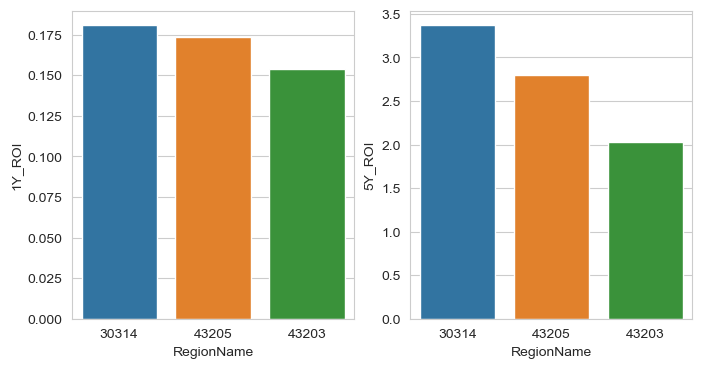

In [63]:
#Create a bar plot
fig, axs = plt.subplots(ncols=2)
sb.barplot(x="RegionName",
           y="1Y_ROI",
           data = model1_top3_1y,
          order = model1_top3_1y.sort_values('1Y_ROI',ascending = False).RegionName,
           ax=axs[0])
sb.barplot(x="RegionName",
           y="5Y_ROI",
           data = model1_top3_5y,
          order = model1_top3_5y.sort_values('5Y_ROI',ascending = False).RegionName, 
           ax=axs[1])
plt.show()

In [64]:
#create a plot for top 3 zip codes
def top3_df (df, top1, top2, top3):
    # Create a dataframe to save the records for top 3 zip codes
    predictions1 = df[df['RegionName'] == top1].reset_index()
    predictions2 = df[df['RegionName'] == top2].reset_index()
    predictions3 = df[df['RegionName'] == top3].reset_index()

    year = predictions1['Year']
    Top1 = predictions1['y']
    Top2 = predictions2['y']
    Top3 = predictions3['y']
    
    # Create DataFrame
    df_final = pd.DataFrame({'year': year,
                        'Top1': Top1,
                        'Top2': Top2,
                        'Top3': Top3
                       })

    df_final = df_final.set_index('year')
    return(df_final)

In [65]:
top1_region = 30314
top2_region = 43205
top3_region = 43203

top3_results = top3_df(grouped_all,top1_region,top2_region,top3_region)
print(top3_results)

               Top1           Top2           Top3
year                                             
1997   43285.620864   41722.483289   59573.914592
1998   50818.801760   47505.250008   65002.785558
1999   58352.786585   52715.551564   70177.181077
2000   66310.713581   56184.328550   74828.641224
2001   73786.578310   59801.786864   78913.212148
2002   84039.726879   63351.237872   83318.967638
2003   96676.006843   67406.314992   88356.266324
2004  109924.859006   71975.316359   94212.960465
2005  122340.419813   76857.276607   99599.341947
2006  130169.389113   81603.189086  103667.598748
2007  115676.139400   81008.529701   98678.850952
2008   88708.824846   73326.579534   86910.079269
2009   60341.997026   64999.447052   73957.091252
2010   40309.974696   56567.752527   61666.611654
2011   34815.000348   48206.465023   50305.107355
2012   35860.791032   41887.252114   44119.605450
2013   36753.812887   43425.757483   46168.376051
2014   38050.602299   48017.714599   51434.053139


In [66]:
# return the records for any zip code
def record_by_region (DF, zipcode):
    return(DF[DF['RegionName']== zipcode][['RegionName','State', 'City', 'Metro']].drop_duplicates())

In [69]:
top3_records = pd.DataFrame()
top3_records = pd.concat([top3_records,(record_by_region(final_df, top1_region)),(record_by_region(final_df, top2_region)),(record_by_region(final_df, top3_region)) ])
print(top3_records)

      RegionName State      City                                 Metro
2924       30314    GA   Atlanta  Atlanta-Sandy Springs-Alpharetta, GA
4299       43205    OH  Columbus                          Columbus, OH
5097       43203    OH  Columbus                          Columbus, OH


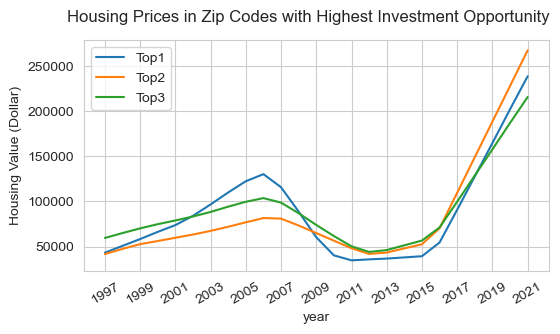

In [71]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(6,3))
x = [1997,1999,2001,2003,2005,2007,2009,2011,2013,2015,2017,2019,2021]
fig.suptitle('Housing Prices in Zip Codes with Highest Investment Opportunity')
top3_results.plot(ax=ax)
plt.xticks(x)
plt.xticks(rotation = 30)
plt.ylabel('Housing Value (Dollar)')
plt.show()

In [72]:
#check the MAE and RMSE values for these three areas
top3_records_MAE = pd.DataFrame()
top3_records_MAE = pd.concat([top3_records_MAE,evaluation_results[evaluation_results['RegionName'] == top1_region],
                             evaluation_results[evaluation_results['RegionName'] == top2_region],
                             evaluation_results[evaluation_results['RegionName'] == top3_region]])
print(top3_records_MAE)

  RegionName           MAE          RMSE
0      30314  31169.843555  32831.360966
0      43205   4688.197747   5525.348652
0      43203  22737.775048  23367.489144


[]

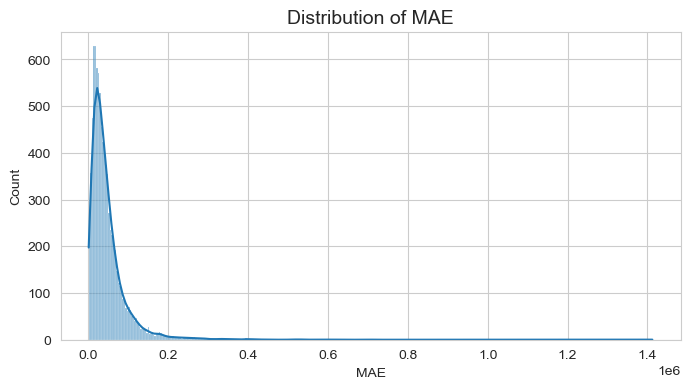

In [73]:
#exploratory data analysis: plot the distribution of SchoolPay
sb.set_style('whitegrid')
sb.histplot(x=evaluation_results['MAE'],
           kde = True)
plt.title('Distribution of MAE', fontdict = {'fontsize': 14})
plt.plot()

#### Build Model Using time series with second order differencing and add CPI regressor

In [75]:
#convert non-stationary time series data using first order differencing method
region_list = ordered_RegionNames
#region_list = [79936,11385]
model_data_diff = pd.DataFrame(columns= ['ds','y','RegionName'])
for region in region_list:
    region_series = model_data.loc[model_data['RegionName'] == region]
    region_series = region_series[['y','ds']]
    region_series = region_series.set_index('ds')
    region_series_new = region_series.diff()
    region_series_new.dropna(inplace=True)
    region_series_new['RegionName'] = region
    region_series_new['ds'] = region_series_new.index
    model_data_diff = pd.concat([model_data_diff,region_series_new])

In [76]:
#convert non-stationary time series data to stationary using differencing method
region_list = ordered_RegionNames
#region_list = [79936,11385]
model_data_diff2 = pd.DataFrame(columns= ['ds','y','RegionName'])
for region in region_list:
    region_series = model_data.loc[model_data['RegionName'] == region]
    region_series = region_series[['y','ds']]
    region_series = region_series.set_index('ds')
    region_series_new = region_series.diff().diff()
    region_series_new.dropna(inplace=True)
    region_series_new['RegionName'] = region
    region_series_new['ds'] = region_series_new.index
    model_data_diff2 = pd.concat([model_data_diff2,region_series_new])

In [77]:
#check new dataframes
model_data_diff = model_data_diff.reset_index(drop=True)
print(model_data_diff)

model_data_diff2 = model_data_diff2.reset_index(drop=True)
print(model_data_diff2)

                 ds             y RegionName
0        1997-02-01   1196.017422       1002
1        1997-03-01    660.537180       1002
2        1997-04-01  -1159.001037       1002
3        1997-05-01   1034.562189       1002
4        1997-06-01    452.144302       1002
...             ...           ...        ...
2512106  2020-08-01   7168.345618      99587
2512107  2020-09-01   -403.482188      99587
2512108  2020-10-01  -2715.009953      99587
2512109  2020-11-01    590.135226      99587
2512110  2020-12-01  14926.404691      99587

[2512111 rows x 3 columns]
                 ds             y RegionName
0        1997-03-01   -535.480242       1002
1        1997-04-01  -1819.538217       1002
2        1997-05-01   2193.563227       1002
3        1997-06-01   -582.417887       1002
4        1997-07-01    611.907617       1002
...             ...           ...        ...
2503353  2020-08-01    118.254314      99587
2503354  2020-09-01  -7571.827806      99587
2503355  2020-10-01  -2311.

In [78]:
#Merge cpi and house value datasets on the value of ds
cpi = cpi.rename(columns={"value": "CPI"})
new_df1 = pd.merge(model_data, cpi, how="inner", on=["ds"])

#only keep columns we need
new_df1 = new_df1[['ds','y','RegionName','CPI']]
print(new_df1)

                 ds              y  RegionName      CPI
0        1997-01-01  101161.485921       77449  159.100
1        1997-01-01  189688.893083       77494  159.100
2        1997-01-01   86357.126426       79936  159.100
3        1997-01-01  201468.266705       11385  159.100
4        1997-01-01   97682.948338       77084  159.100
...             ...            ...         ...      ...
2520859  2020-12-01  188239.250091       12489  260.474
2520860  2020-12-01  203393.786823       21720  260.474
2520861  2020-12-01  188133.313616       21862  260.474
2520862  2020-12-01  578081.167462       34250  260.474
2520863  2020-12-01  104594.322652       33877  260.474

[2520864 rows x 4 columns]


In [79]:
#Merge cpi and house price data where first order differencing was performed
new_df1_diff = pd.merge(model_data_diff, cpi, how="inner", on=["ds"])
new_df1_diff = new_df1_diff[['ds','y','RegionName','CPI']]
print(new_df1_diff)

#Merge fed funds and house price data where second order differencing was performed
new_df1_diff2 = pd.merge(model_data_diff2, cpi, how="inner", on=["ds"])
new_df1_diff2 = new_df1_diff2[['ds','y','RegionName','CPI']]
print(new_df1_diff2)

                 ds             y RegionName      CPI
0        1997-02-01   1196.017422       1002  159.600
1        1997-02-01   1056.471453       1005  159.600
2        1997-02-01   1127.910515       1007  159.600
3        1997-02-01  -1963.104707       1008  159.600
4        1997-02-01     92.296852       1010  159.600
...             ...           ...        ...      ...
2512106  2020-12-01   5091.600083      99216  260.474
2512107  2020-12-01   5728.100828      99218  260.474
2512108  2020-12-01   7211.972517      99223  260.474
2512109  2020-12-01  12709.458749      99360  260.474
2512110  2020-12-01  14926.404691      99587  260.474

[2512111 rows x 4 columns]
                 ds             y RegionName      CPI
0        1997-03-01   -535.480242       1002  160.000
1        1997-03-01  -2090.142609       1005  160.000
2        1997-03-01   -541.181107       1007  160.000
3        1997-03-01   1594.881148       1008  160.000
4        1997-03-01  -1677.213616       1010  160.000


In [81]:
#Create predictions for each month in 2018 for each Zip Code with CPI regressor
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

#prepare data to build model
region_list = ordered_RegionNames
regressor_df = cpi[['ds','CPI']]
history_data = new_df1.rename(columns={"y": "yhat"})
diff1_data = new_df1_diff.rename(columns={"y": "yhat"})
predictions_regressor1 = pd.DataFrame(columns= ['ds', 'y', 'RegionName','CPI'])

#run forecasts into 12 months in 2018 for each zip code, and combine data for each zip code to one data set
for region in region_list:
    #using second order differencing series to build the model
    region_series = new_df1_diff2.loc[new_df1_diff2['RegionName'] == region]
    region_series = region_series[['y','ds','CPI']]

    # MODEL using Prophet - Set the uncertainty interval to 95% (the Prophet default is 80%)
    model = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
    # adding external regressors
    model.add_regressor('CPI')
    # fit the model
    model = model.fit(region_series)
    
    #model = fit.prophet(model, df = region_series)
    future_date = model.make_future_dataframe(periods=12, freq='MS')
    values = cpi['CPI']
    future_date['CPI'] = values
    forecast = model.predict(future_date)
    forecast = forecast[['ds', 'yhat']]
    yhat = forecast['yhat']
    
    #get the original and first order differencing series for inverse steps
    history = history_data.loc[history_data['RegionName'] == region]
    diff1 = diff1_data.loc[diff1_data['RegionName'] == region]
    
    #inverse second order difference
    inverse1 = inverse_difference(diff1['yhat'].tolist(), yhat[-12:], 1)
    inverse2 = inverse_difference(history['yhat'].tolist(), inverse1, 1)
    all_ds = forecast['ds']

    #create DataFrame for the current zip code
    forecast_df = pd.DataFrame({'ds': all_ds[-12:],
        'y': inverse2})
    forecast_df['RegionName'] = region
    forecast_df['CPI'] = values
    #print(forecast_df)
    model_data_region = pd.concat([new_df1.loc[new_df1['RegionName'] == region], forecast_df])
    
    #append data for current zip code to final prediction result data set
    predictions_regressor1 = pd.concat([predictions_regressor1,model_data_region])

23:28:13 - cmdstanpy - INFO - Chain [1] start processing
23:28:13 - cmdstanpy - INFO - Chain [1] done processing
23:28:14 - cmdstanpy - INFO - Chain [1] start processing
23:28:14 - cmdstanpy - INFO - Chain [1] done processing
23:28:14 - cmdstanpy - INFO - Chain [1] start processing
23:28:14 - cmdstanpy - INFO - Chain [1] done processing
23:28:15 - cmdstanpy - INFO - Chain [1] start processing
23:28:15 - cmdstanpy - INFO - Chain [1] done processing
23:28:15 - cmdstanpy - INFO - Chain [1] start processing
23:28:15 - cmdstanpy - INFO - Chain [1] done processing
23:28:16 - cmdstanpy - INFO - Chain [1] start processing
23:28:16 - cmdstanpy - INFO - Chain [1] done processing
23:28:17 - cmdstanpy - INFO - Chain [1] start processing
23:28:17 - cmdstanpy - INFO - Chain [1] done processing
23:28:17 - cmdstanpy - INFO - Chain [1] start processing
23:28:17 - cmdstanpy - INFO - Chain [1] done processing
23:28:18 - cmdstanpy - INFO - Chain [1] start processing
23:28:18 - cmdstanpy - INFO - Chain [1]

23:28:55 - cmdstanpy - INFO - Chain [1] done processing
23:28:56 - cmdstanpy - INFO - Chain [1] start processing
23:28:56 - cmdstanpy - INFO - Chain [1] done processing
23:28:56 - cmdstanpy - INFO - Chain [1] start processing
23:28:57 - cmdstanpy - INFO - Chain [1] done processing
23:28:57 - cmdstanpy - INFO - Chain [1] start processing
23:28:57 - cmdstanpy - INFO - Chain [1] done processing
23:28:58 - cmdstanpy - INFO - Chain [1] start processing
23:28:58 - cmdstanpy - INFO - Chain [1] done processing
23:28:58 - cmdstanpy - INFO - Chain [1] start processing
23:28:58 - cmdstanpy - INFO - Chain [1] done processing
23:28:59 - cmdstanpy - INFO - Chain [1] start processing
23:28:59 - cmdstanpy - INFO - Chain [1] done processing
23:29:00 - cmdstanpy - INFO - Chain [1] start processing
23:29:00 - cmdstanpy - INFO - Chain [1] done processing
23:29:00 - cmdstanpy - INFO - Chain [1] start processing
23:29:00 - cmdstanpy - INFO - Chain [1] done processing
23:29:01 - cmdstanpy - INFO - Chain [1] 

23:29:39 - cmdstanpy - INFO - Chain [1] done processing
23:29:39 - cmdstanpy - INFO - Chain [1] start processing
23:29:39 - cmdstanpy - INFO - Chain [1] done processing
23:29:40 - cmdstanpy - INFO - Chain [1] start processing
23:29:40 - cmdstanpy - INFO - Chain [1] done processing
23:29:41 - cmdstanpy - INFO - Chain [1] start processing
23:29:41 - cmdstanpy - INFO - Chain [1] done processing
23:29:41 - cmdstanpy - INFO - Chain [1] start processing
23:29:41 - cmdstanpy - INFO - Chain [1] done processing
23:29:42 - cmdstanpy - INFO - Chain [1] start processing
23:29:42 - cmdstanpy - INFO - Chain [1] done processing
23:29:42 - cmdstanpy - INFO - Chain [1] start processing
23:29:42 - cmdstanpy - INFO - Chain [1] done processing
23:29:43 - cmdstanpy - INFO - Chain [1] start processing
23:29:43 - cmdstanpy - INFO - Chain [1] done processing
23:29:44 - cmdstanpy - INFO - Chain [1] start processing
23:29:44 - cmdstanpy - INFO - Chain [1] done processing
23:29:44 - cmdstanpy - INFO - Chain [1] 

23:30:23 - cmdstanpy - INFO - Chain [1] done processing
23:30:23 - cmdstanpy - INFO - Chain [1] start processing
23:30:23 - cmdstanpy - INFO - Chain [1] done processing
23:30:24 - cmdstanpy - INFO - Chain [1] start processing
23:30:24 - cmdstanpy - INFO - Chain [1] done processing
23:30:24 - cmdstanpy - INFO - Chain [1] start processing
23:30:24 - cmdstanpy - INFO - Chain [1] done processing
23:30:25 - cmdstanpy - INFO - Chain [1] start processing
23:30:25 - cmdstanpy - INFO - Chain [1] done processing
23:30:26 - cmdstanpy - INFO - Chain [1] start processing
23:30:26 - cmdstanpy - INFO - Chain [1] done processing
23:30:26 - cmdstanpy - INFO - Chain [1] start processing
23:30:26 - cmdstanpy - INFO - Chain [1] done processing
23:30:27 - cmdstanpy - INFO - Chain [1] start processing
23:30:27 - cmdstanpy - INFO - Chain [1] done processing
23:30:27 - cmdstanpy - INFO - Chain [1] start processing
23:30:27 - cmdstanpy - INFO - Chain [1] done processing
23:30:28 - cmdstanpy - INFO - Chain [1] 

23:31:08 - cmdstanpy - INFO - Chain [1] done processing
23:31:09 - cmdstanpy - INFO - Chain [1] start processing
23:31:09 - cmdstanpy - INFO - Chain [1] done processing
23:31:09 - cmdstanpy - INFO - Chain [1] start processing
23:31:09 - cmdstanpy - INFO - Chain [1] done processing
23:31:10 - cmdstanpy - INFO - Chain [1] start processing
23:31:10 - cmdstanpy - INFO - Chain [1] done processing
23:31:11 - cmdstanpy - INFO - Chain [1] start processing
23:31:11 - cmdstanpy - INFO - Chain [1] done processing
23:31:11 - cmdstanpy - INFO - Chain [1] start processing
23:31:11 - cmdstanpy - INFO - Chain [1] done processing
23:31:12 - cmdstanpy - INFO - Chain [1] start processing
23:31:12 - cmdstanpy - INFO - Chain [1] done processing
23:31:13 - cmdstanpy - INFO - Chain [1] start processing
23:31:13 - cmdstanpy - INFO - Chain [1] done processing
23:31:14 - cmdstanpy - INFO - Chain [1] start processing
23:31:14 - cmdstanpy - INFO - Chain [1] done processing
23:31:14 - cmdstanpy - INFO - Chain [1] 

23:32:00 - cmdstanpy - INFO - Chain [1] done processing
23:32:01 - cmdstanpy - INFO - Chain [1] start processing
23:32:01 - cmdstanpy - INFO - Chain [1] done processing
23:32:01 - cmdstanpy - INFO - Chain [1] start processing
23:32:01 - cmdstanpy - INFO - Chain [1] done processing
23:32:02 - cmdstanpy - INFO - Chain [1] start processing
23:32:02 - cmdstanpy - INFO - Chain [1] done processing
23:32:03 - cmdstanpy - INFO - Chain [1] start processing
23:32:03 - cmdstanpy - INFO - Chain [1] done processing
23:32:03 - cmdstanpy - INFO - Chain [1] start processing
23:32:04 - cmdstanpy - INFO - Chain [1] done processing
23:32:04 - cmdstanpy - INFO - Chain [1] start processing
23:32:04 - cmdstanpy - INFO - Chain [1] done processing
23:32:05 - cmdstanpy - INFO - Chain [1] start processing
23:32:05 - cmdstanpy - INFO - Chain [1] done processing
23:32:06 - cmdstanpy - INFO - Chain [1] start processing
23:32:06 - cmdstanpy - INFO - Chain [1] done processing
23:32:06 - cmdstanpy - INFO - Chain [1] 

23:32:52 - cmdstanpy - INFO - Chain [1] done processing
23:32:52 - cmdstanpy - INFO - Chain [1] start processing
23:32:53 - cmdstanpy - INFO - Chain [1] done processing
23:32:53 - cmdstanpy - INFO - Chain [1] start processing
23:32:53 - cmdstanpy - INFO - Chain [1] done processing
23:32:54 - cmdstanpy - INFO - Chain [1] start processing
23:32:54 - cmdstanpy - INFO - Chain [1] done processing
23:32:55 - cmdstanpy - INFO - Chain [1] start processing
23:32:55 - cmdstanpy - INFO - Chain [1] done processing
23:32:55 - cmdstanpy - INFO - Chain [1] start processing
23:32:55 - cmdstanpy - INFO - Chain [1] done processing
23:32:56 - cmdstanpy - INFO - Chain [1] start processing
23:32:56 - cmdstanpy - INFO - Chain [1] done processing
23:32:57 - cmdstanpy - INFO - Chain [1] start processing
23:32:57 - cmdstanpy - INFO - Chain [1] done processing
23:32:57 - cmdstanpy - INFO - Chain [1] start processing
23:32:57 - cmdstanpy - INFO - Chain [1] done processing
23:32:58 - cmdstanpy - INFO - Chain [1] 

23:33:44 - cmdstanpy - INFO - Chain [1] done processing
23:33:44 - cmdstanpy - INFO - Chain [1] start processing
23:33:44 - cmdstanpy - INFO - Chain [1] done processing
23:33:45 - cmdstanpy - INFO - Chain [1] start processing
23:33:45 - cmdstanpy - INFO - Chain [1] done processing
23:33:46 - cmdstanpy - INFO - Chain [1] start processing
23:33:46 - cmdstanpy - INFO - Chain [1] done processing
23:33:47 - cmdstanpy - INFO - Chain [1] start processing
23:33:47 - cmdstanpy - INFO - Chain [1] done processing
23:33:47 - cmdstanpy - INFO - Chain [1] start processing
23:33:47 - cmdstanpy - INFO - Chain [1] done processing
23:33:48 - cmdstanpy - INFO - Chain [1] start processing
23:33:48 - cmdstanpy - INFO - Chain [1] done processing
23:33:49 - cmdstanpy - INFO - Chain [1] start processing
23:33:49 - cmdstanpy - INFO - Chain [1] done processing
23:33:50 - cmdstanpy - INFO - Chain [1] start processing
23:33:50 - cmdstanpy - INFO - Chain [1] done processing
23:33:50 - cmdstanpy - INFO - Chain [1] 

23:34:35 - cmdstanpy - INFO - Chain [1] done processing
23:34:36 - cmdstanpy - INFO - Chain [1] start processing
23:34:36 - cmdstanpy - INFO - Chain [1] done processing
23:34:37 - cmdstanpy - INFO - Chain [1] start processing
23:34:37 - cmdstanpy - INFO - Chain [1] done processing
23:34:38 - cmdstanpy - INFO - Chain [1] start processing
23:34:38 - cmdstanpy - INFO - Chain [1] done processing
23:34:38 - cmdstanpy - INFO - Chain [1] start processing
23:34:38 - cmdstanpy - INFO - Chain [1] done processing
23:34:39 - cmdstanpy - INFO - Chain [1] start processing
23:34:39 - cmdstanpy - INFO - Chain [1] done processing
23:34:40 - cmdstanpy - INFO - Chain [1] start processing
23:34:40 - cmdstanpy - INFO - Chain [1] done processing
23:34:40 - cmdstanpy - INFO - Chain [1] start processing
23:34:40 - cmdstanpy - INFO - Chain [1] done processing
23:34:41 - cmdstanpy - INFO - Chain [1] start processing
23:34:41 - cmdstanpy - INFO - Chain [1] done processing
23:34:42 - cmdstanpy - INFO - Chain [1] 

23:35:28 - cmdstanpy - INFO - Chain [1] done processing
23:35:28 - cmdstanpy - INFO - Chain [1] start processing
23:35:28 - cmdstanpy - INFO - Chain [1] done processing
23:35:29 - cmdstanpy - INFO - Chain [1] start processing
23:35:29 - cmdstanpy - INFO - Chain [1] done processing
23:35:30 - cmdstanpy - INFO - Chain [1] start processing
23:35:30 - cmdstanpy - INFO - Chain [1] done processing
23:35:31 - cmdstanpy - INFO - Chain [1] start processing
23:35:31 - cmdstanpy - INFO - Chain [1] done processing
23:35:31 - cmdstanpy - INFO - Chain [1] start processing
23:35:31 - cmdstanpy - INFO - Chain [1] done processing
23:35:32 - cmdstanpy - INFO - Chain [1] start processing
23:35:32 - cmdstanpy - INFO - Chain [1] done processing
23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing
23:35:34 - cmdstanpy - INFO - Chain [1] start processing
23:35:34 - cmdstanpy - INFO - Chain [1] done processing
23:35:34 - cmdstanpy - INFO - Chain [1] 

23:36:21 - cmdstanpy - INFO - Chain [1] done processing
23:36:22 - cmdstanpy - INFO - Chain [1] start processing
23:36:22 - cmdstanpy - INFO - Chain [1] done processing
23:36:23 - cmdstanpy - INFO - Chain [1] start processing
23:36:23 - cmdstanpy - INFO - Chain [1] done processing
23:36:24 - cmdstanpy - INFO - Chain [1] start processing
23:36:24 - cmdstanpy - INFO - Chain [1] done processing
23:36:24 - cmdstanpy - INFO - Chain [1] start processing
23:36:24 - cmdstanpy - INFO - Chain [1] done processing
23:36:25 - cmdstanpy - INFO - Chain [1] start processing
23:36:25 - cmdstanpy - INFO - Chain [1] done processing
23:36:26 - cmdstanpy - INFO - Chain [1] start processing
23:36:26 - cmdstanpy - INFO - Chain [1] done processing
23:36:27 - cmdstanpy - INFO - Chain [1] start processing
23:36:27 - cmdstanpy - INFO - Chain [1] done processing
23:36:27 - cmdstanpy - INFO - Chain [1] start processing
23:36:27 - cmdstanpy - INFO - Chain [1] done processing
23:36:28 - cmdstanpy - INFO - Chain [1] 

23:37:15 - cmdstanpy - INFO - Chain [1] done processing
23:37:16 - cmdstanpy - INFO - Chain [1] start processing
23:37:16 - cmdstanpy - INFO - Chain [1] done processing
23:37:17 - cmdstanpy - INFO - Chain [1] start processing
23:37:17 - cmdstanpy - INFO - Chain [1] done processing
23:37:18 - cmdstanpy - INFO - Chain [1] start processing
23:37:18 - cmdstanpy - INFO - Chain [1] done processing
23:37:18 - cmdstanpy - INFO - Chain [1] start processing
23:37:18 - cmdstanpy - INFO - Chain [1] done processing
23:37:19 - cmdstanpy - INFO - Chain [1] start processing
23:37:19 - cmdstanpy - INFO - Chain [1] done processing
23:37:20 - cmdstanpy - INFO - Chain [1] start processing
23:37:20 - cmdstanpy - INFO - Chain [1] done processing
23:37:20 - cmdstanpy - INFO - Chain [1] start processing
23:37:20 - cmdstanpy - INFO - Chain [1] done processing
23:37:21 - cmdstanpy - INFO - Chain [1] start processing
23:37:21 - cmdstanpy - INFO - Chain [1] done processing
23:37:22 - cmdstanpy - INFO - Chain [1] 

23:38:08 - cmdstanpy - INFO - Chain [1] done processing
23:38:09 - cmdstanpy - INFO - Chain [1] start processing
23:38:09 - cmdstanpy - INFO - Chain [1] done processing
23:38:09 - cmdstanpy - INFO - Chain [1] start processing
23:38:09 - cmdstanpy - INFO - Chain [1] done processing
23:38:10 - cmdstanpy - INFO - Chain [1] start processing
23:38:10 - cmdstanpy - INFO - Chain [1] done processing
23:38:11 - cmdstanpy - INFO - Chain [1] start processing
23:38:11 - cmdstanpy - INFO - Chain [1] done processing
23:38:11 - cmdstanpy - INFO - Chain [1] start processing
23:38:11 - cmdstanpy - INFO - Chain [1] done processing
23:38:12 - cmdstanpy - INFO - Chain [1] start processing
23:38:12 - cmdstanpy - INFO - Chain [1] done processing
23:38:13 - cmdstanpy - INFO - Chain [1] start processing
23:38:13 - cmdstanpy - INFO - Chain [1] done processing
23:38:14 - cmdstanpy - INFO - Chain [1] start processing
23:38:14 - cmdstanpy - INFO - Chain [1] done processing
23:38:14 - cmdstanpy - INFO - Chain [1] 

23:39:00 - cmdstanpy - INFO - Chain [1] done processing
23:39:01 - cmdstanpy - INFO - Chain [1] start processing
23:39:01 - cmdstanpy - INFO - Chain [1] done processing
23:39:02 - cmdstanpy - INFO - Chain [1] start processing
23:39:02 - cmdstanpy - INFO - Chain [1] done processing
23:39:02 - cmdstanpy - INFO - Chain [1] start processing
23:39:02 - cmdstanpy - INFO - Chain [1] done processing
23:39:03 - cmdstanpy - INFO - Chain [1] start processing
23:39:03 - cmdstanpy - INFO - Chain [1] done processing
23:39:04 - cmdstanpy - INFO - Chain [1] start processing
23:39:04 - cmdstanpy - INFO - Chain [1] done processing
23:39:04 - cmdstanpy - INFO - Chain [1] start processing
23:39:04 - cmdstanpy - INFO - Chain [1] done processing
23:39:05 - cmdstanpy - INFO - Chain [1] start processing
23:39:05 - cmdstanpy - INFO - Chain [1] done processing
23:39:06 - cmdstanpy - INFO - Chain [1] start processing
23:39:06 - cmdstanpy - INFO - Chain [1] done processing
23:39:07 - cmdstanpy - INFO - Chain [1] 

23:39:53 - cmdstanpy - INFO - Chain [1] done processing
23:39:53 - cmdstanpy - INFO - Chain [1] start processing
23:39:53 - cmdstanpy - INFO - Chain [1] done processing
23:39:54 - cmdstanpy - INFO - Chain [1] start processing
23:39:54 - cmdstanpy - INFO - Chain [1] done processing
23:39:55 - cmdstanpy - INFO - Chain [1] start processing
23:39:55 - cmdstanpy - INFO - Chain [1] done processing
23:39:55 - cmdstanpy - INFO - Chain [1] start processing
23:39:56 - cmdstanpy - INFO - Chain [1] done processing
23:39:56 - cmdstanpy - INFO - Chain [1] start processing
23:39:56 - cmdstanpy - INFO - Chain [1] done processing
23:39:57 - cmdstanpy - INFO - Chain [1] start processing
23:39:57 - cmdstanpy - INFO - Chain [1] done processing
23:39:58 - cmdstanpy - INFO - Chain [1] start processing
23:39:58 - cmdstanpy - INFO - Chain [1] done processing
23:39:58 - cmdstanpy - INFO - Chain [1] start processing
23:39:58 - cmdstanpy - INFO - Chain [1] done processing
23:39:59 - cmdstanpy - INFO - Chain [1] 

23:40:46 - cmdstanpy - INFO - Chain [1] done processing
23:40:46 - cmdstanpy - INFO - Chain [1] start processing
23:40:46 - cmdstanpy - INFO - Chain [1] done processing
23:40:47 - cmdstanpy - INFO - Chain [1] start processing
23:40:47 - cmdstanpy - INFO - Chain [1] done processing
23:40:48 - cmdstanpy - INFO - Chain [1] start processing
23:40:48 - cmdstanpy - INFO - Chain [1] done processing
23:40:48 - cmdstanpy - INFO - Chain [1] start processing
23:40:48 - cmdstanpy - INFO - Chain [1] done processing
23:40:49 - cmdstanpy - INFO - Chain [1] start processing
23:40:49 - cmdstanpy - INFO - Chain [1] done processing
23:40:50 - cmdstanpy - INFO - Chain [1] start processing
23:40:50 - cmdstanpy - INFO - Chain [1] done processing
23:40:51 - cmdstanpy - INFO - Chain [1] start processing
23:40:51 - cmdstanpy - INFO - Chain [1] done processing
23:40:51 - cmdstanpy - INFO - Chain [1] start processing
23:40:51 - cmdstanpy - INFO - Chain [1] done processing
23:40:52 - cmdstanpy - INFO - Chain [1] 

23:41:38 - cmdstanpy - INFO - Chain [1] done processing
23:41:39 - cmdstanpy - INFO - Chain [1] start processing
23:41:39 - cmdstanpy - INFO - Chain [1] done processing
23:41:40 - cmdstanpy - INFO - Chain [1] start processing
23:41:40 - cmdstanpy - INFO - Chain [1] done processing
23:41:40 - cmdstanpy - INFO - Chain [1] start processing
23:41:40 - cmdstanpy - INFO - Chain [1] done processing
23:41:41 - cmdstanpy - INFO - Chain [1] start processing
23:41:41 - cmdstanpy - INFO - Chain [1] done processing
23:41:42 - cmdstanpy - INFO - Chain [1] start processing
23:41:42 - cmdstanpy - INFO - Chain [1] done processing
23:41:42 - cmdstanpy - INFO - Chain [1] start processing
23:41:42 - cmdstanpy - INFO - Chain [1] done processing
23:41:43 - cmdstanpy - INFO - Chain [1] start processing
23:41:43 - cmdstanpy - INFO - Chain [1] done processing
23:41:44 - cmdstanpy - INFO - Chain [1] start processing
23:41:44 - cmdstanpy - INFO - Chain [1] done processing
23:41:45 - cmdstanpy - INFO - Chain [1] 

23:42:31 - cmdstanpy - INFO - Chain [1] done processing
23:42:32 - cmdstanpy - INFO - Chain [1] start processing
23:42:32 - cmdstanpy - INFO - Chain [1] done processing
23:42:32 - cmdstanpy - INFO - Chain [1] start processing
23:42:32 - cmdstanpy - INFO - Chain [1] done processing
23:42:33 - cmdstanpy - INFO - Chain [1] start processing
23:42:33 - cmdstanpy - INFO - Chain [1] done processing
23:42:34 - cmdstanpy - INFO - Chain [1] start processing
23:42:34 - cmdstanpy - INFO - Chain [1] done processing
23:42:34 - cmdstanpy - INFO - Chain [1] start processing
23:42:35 - cmdstanpy - INFO - Chain [1] done processing
23:42:35 - cmdstanpy - INFO - Chain [1] start processing
23:42:35 - cmdstanpy - INFO - Chain [1] done processing
23:42:36 - cmdstanpy - INFO - Chain [1] start processing
23:42:36 - cmdstanpy - INFO - Chain [1] done processing
23:42:37 - cmdstanpy - INFO - Chain [1] start processing
23:42:37 - cmdstanpy - INFO - Chain [1] done processing
23:42:37 - cmdstanpy - INFO - Chain [1] 

23:43:24 - cmdstanpy - INFO - Chain [1] done processing
23:43:25 - cmdstanpy - INFO - Chain [1] start processing
23:43:25 - cmdstanpy - INFO - Chain [1] done processing
23:43:25 - cmdstanpy - INFO - Chain [1] start processing
23:43:25 - cmdstanpy - INFO - Chain [1] done processing
23:43:26 - cmdstanpy - INFO - Chain [1] start processing
23:43:26 - cmdstanpy - INFO - Chain [1] done processing
23:43:27 - cmdstanpy - INFO - Chain [1] start processing
23:43:27 - cmdstanpy - INFO - Chain [1] done processing
23:43:27 - cmdstanpy - INFO - Chain [1] start processing
23:43:27 - cmdstanpy - INFO - Chain [1] done processing
23:43:28 - cmdstanpy - INFO - Chain [1] start processing
23:43:28 - cmdstanpy - INFO - Chain [1] done processing
23:43:29 - cmdstanpy - INFO - Chain [1] start processing
23:43:29 - cmdstanpy - INFO - Chain [1] done processing
23:43:30 - cmdstanpy - INFO - Chain [1] start processing
23:43:30 - cmdstanpy - INFO - Chain [1] done processing
23:43:30 - cmdstanpy - INFO - Chain [1] 

23:44:17 - cmdstanpy - INFO - Chain [1] done processing
23:44:18 - cmdstanpy - INFO - Chain [1] start processing
23:44:18 - cmdstanpy - INFO - Chain [1] done processing
23:44:18 - cmdstanpy - INFO - Chain [1] start processing
23:44:18 - cmdstanpy - INFO - Chain [1] done processing
23:44:19 - cmdstanpy - INFO - Chain [1] start processing
23:44:19 - cmdstanpy - INFO - Chain [1] done processing
23:44:20 - cmdstanpy - INFO - Chain [1] start processing
23:44:20 - cmdstanpy - INFO - Chain [1] done processing
23:44:21 - cmdstanpy - INFO - Chain [1] start processing
23:44:21 - cmdstanpy - INFO - Chain [1] done processing
23:44:21 - cmdstanpy - INFO - Chain [1] start processing
23:44:21 - cmdstanpy - INFO - Chain [1] done processing
23:44:22 - cmdstanpy - INFO - Chain [1] start processing
23:44:22 - cmdstanpy - INFO - Chain [1] done processing
23:44:23 - cmdstanpy - INFO - Chain [1] start processing
23:44:23 - cmdstanpy - INFO - Chain [1] done processing
23:44:24 - cmdstanpy - INFO - Chain [1] 

23:45:10 - cmdstanpy - INFO - Chain [1] done processing
23:45:11 - cmdstanpy - INFO - Chain [1] start processing
23:45:11 - cmdstanpy - INFO - Chain [1] done processing
23:45:12 - cmdstanpy - INFO - Chain [1] start processing
23:45:12 - cmdstanpy - INFO - Chain [1] done processing
23:45:12 - cmdstanpy - INFO - Chain [1] start processing
23:45:12 - cmdstanpy - INFO - Chain [1] done processing
23:45:13 - cmdstanpy - INFO - Chain [1] start processing
23:45:13 - cmdstanpy - INFO - Chain [1] done processing
23:45:14 - cmdstanpy - INFO - Chain [1] start processing
23:45:14 - cmdstanpy - INFO - Chain [1] done processing
23:45:15 - cmdstanpy - INFO - Chain [1] start processing
23:45:15 - cmdstanpy - INFO - Chain [1] done processing
23:45:15 - cmdstanpy - INFO - Chain [1] start processing
23:45:15 - cmdstanpy - INFO - Chain [1] done processing
23:45:16 - cmdstanpy - INFO - Chain [1] start processing
23:45:16 - cmdstanpy - INFO - Chain [1] done processing
23:45:17 - cmdstanpy - INFO - Chain [1] 

23:46:03 - cmdstanpy - INFO - Chain [1] done processing
23:46:04 - cmdstanpy - INFO - Chain [1] start processing
23:46:04 - cmdstanpy - INFO - Chain [1] done processing
23:46:05 - cmdstanpy - INFO - Chain [1] start processing
23:46:05 - cmdstanpy - INFO - Chain [1] done processing
23:46:05 - cmdstanpy - INFO - Chain [1] start processing
23:46:06 - cmdstanpy - INFO - Chain [1] done processing
23:46:06 - cmdstanpy - INFO - Chain [1] start processing
23:46:06 - cmdstanpy - INFO - Chain [1] done processing
23:46:07 - cmdstanpy - INFO - Chain [1] start processing
23:46:07 - cmdstanpy - INFO - Chain [1] done processing
23:46:08 - cmdstanpy - INFO - Chain [1] start processing
23:46:08 - cmdstanpy - INFO - Chain [1] done processing
23:46:08 - cmdstanpy - INFO - Chain [1] start processing
23:46:08 - cmdstanpy - INFO - Chain [1] done processing
23:46:09 - cmdstanpy - INFO - Chain [1] start processing
23:46:09 - cmdstanpy - INFO - Chain [1] done processing
23:46:10 - cmdstanpy - INFO - Chain [1] 

23:46:57 - cmdstanpy - INFO - Chain [1] done processing
23:46:58 - cmdstanpy - INFO - Chain [1] start processing
23:46:58 - cmdstanpy - INFO - Chain [1] done processing
23:46:59 - cmdstanpy - INFO - Chain [1] start processing
23:46:59 - cmdstanpy - INFO - Chain [1] done processing
23:46:59 - cmdstanpy - INFO - Chain [1] start processing
23:46:59 - cmdstanpy - INFO - Chain [1] done processing
23:47:00 - cmdstanpy - INFO - Chain [1] start processing
23:47:00 - cmdstanpy - INFO - Chain [1] done processing
23:47:01 - cmdstanpy - INFO - Chain [1] start processing
23:47:01 - cmdstanpy - INFO - Chain [1] done processing
23:47:02 - cmdstanpy - INFO - Chain [1] start processing
23:47:02 - cmdstanpy - INFO - Chain [1] done processing
23:47:02 - cmdstanpy - INFO - Chain [1] start processing
23:47:02 - cmdstanpy - INFO - Chain [1] done processing
23:47:03 - cmdstanpy - INFO - Chain [1] start processing
23:47:03 - cmdstanpy - INFO - Chain [1] done processing
23:47:04 - cmdstanpy - INFO - Chain [1] 

23:47:50 - cmdstanpy - INFO - Chain [1] done processing
23:47:51 - cmdstanpy - INFO - Chain [1] start processing
23:47:51 - cmdstanpy - INFO - Chain [1] done processing
23:47:52 - cmdstanpy - INFO - Chain [1] start processing
23:47:52 - cmdstanpy - INFO - Chain [1] done processing
23:47:53 - cmdstanpy - INFO - Chain [1] start processing
23:47:53 - cmdstanpy - INFO - Chain [1] done processing
23:47:53 - cmdstanpy - INFO - Chain [1] start processing
23:47:53 - cmdstanpy - INFO - Chain [1] done processing
23:47:54 - cmdstanpy - INFO - Chain [1] start processing
23:47:54 - cmdstanpy - INFO - Chain [1] done processing
23:47:55 - cmdstanpy - INFO - Chain [1] start processing
23:47:55 - cmdstanpy - INFO - Chain [1] done processing
23:47:55 - cmdstanpy - INFO - Chain [1] start processing
23:47:56 - cmdstanpy - INFO - Chain [1] done processing
23:47:56 - cmdstanpy - INFO - Chain [1] start processing
23:47:56 - cmdstanpy - INFO - Chain [1] done processing
23:47:57 - cmdstanpy - INFO - Chain [1] 

23:48:44 - cmdstanpy - INFO - Chain [1] done processing
23:48:45 - cmdstanpy - INFO - Chain [1] start processing
23:48:45 - cmdstanpy - INFO - Chain [1] done processing
23:48:45 - cmdstanpy - INFO - Chain [1] start processing
23:48:45 - cmdstanpy - INFO - Chain [1] done processing
23:48:46 - cmdstanpy - INFO - Chain [1] start processing
23:48:46 - cmdstanpy - INFO - Chain [1] done processing
23:48:47 - cmdstanpy - INFO - Chain [1] start processing
23:48:47 - cmdstanpy - INFO - Chain [1] done processing
23:48:48 - cmdstanpy - INFO - Chain [1] start processing
23:48:48 - cmdstanpy - INFO - Chain [1] done processing
23:48:48 - cmdstanpy - INFO - Chain [1] start processing
23:48:48 - cmdstanpy - INFO - Chain [1] done processing
23:48:49 - cmdstanpy - INFO - Chain [1] start processing
23:48:49 - cmdstanpy - INFO - Chain [1] done processing
23:48:50 - cmdstanpy - INFO - Chain [1] start processing
23:48:50 - cmdstanpy - INFO - Chain [1] done processing
23:48:51 - cmdstanpy - INFO - Chain [1] 

23:49:38 - cmdstanpy - INFO - Chain [1] done processing
23:49:39 - cmdstanpy - INFO - Chain [1] start processing
23:49:39 - cmdstanpy - INFO - Chain [1] done processing
23:49:39 - cmdstanpy - INFO - Chain [1] start processing
23:49:39 - cmdstanpy - INFO - Chain [1] done processing
23:49:40 - cmdstanpy - INFO - Chain [1] start processing
23:49:40 - cmdstanpy - INFO - Chain [1] done processing
23:49:41 - cmdstanpy - INFO - Chain [1] start processing
23:49:41 - cmdstanpy - INFO - Chain [1] done processing
23:49:42 - cmdstanpy - INFO - Chain [1] start processing
23:49:42 - cmdstanpy - INFO - Chain [1] done processing
23:49:42 - cmdstanpy - INFO - Chain [1] start processing
23:49:42 - cmdstanpy - INFO - Chain [1] done processing
23:49:43 - cmdstanpy - INFO - Chain [1] start processing
23:49:43 - cmdstanpy - INFO - Chain [1] done processing
23:49:44 - cmdstanpy - INFO - Chain [1] start processing
23:49:44 - cmdstanpy - INFO - Chain [1] done processing
23:49:45 - cmdstanpy - INFO - Chain [1] 

23:50:32 - cmdstanpy - INFO - Chain [1] done processing
23:50:33 - cmdstanpy - INFO - Chain [1] start processing
23:50:33 - cmdstanpy - INFO - Chain [1] done processing
23:50:33 - cmdstanpy - INFO - Chain [1] start processing
23:50:33 - cmdstanpy - INFO - Chain [1] done processing
23:50:34 - cmdstanpy - INFO - Chain [1] start processing
23:50:34 - cmdstanpy - INFO - Chain [1] done processing
23:50:35 - cmdstanpy - INFO - Chain [1] start processing
23:50:35 - cmdstanpy - INFO - Chain [1] done processing
23:50:36 - cmdstanpy - INFO - Chain [1] start processing
23:50:36 - cmdstanpy - INFO - Chain [1] done processing
23:50:36 - cmdstanpy - INFO - Chain [1] start processing
23:50:36 - cmdstanpy - INFO - Chain [1] done processing
23:50:37 - cmdstanpy - INFO - Chain [1] start processing
23:50:37 - cmdstanpy - INFO - Chain [1] done processing
23:50:38 - cmdstanpy - INFO - Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing
23:50:38 - cmdstanpy - INFO - Chain [1] 

23:51:26 - cmdstanpy - INFO - Chain [1] done processing
23:51:27 - cmdstanpy - INFO - Chain [1] start processing
23:51:27 - cmdstanpy - INFO - Chain [1] done processing
23:51:27 - cmdstanpy - INFO - Chain [1] start processing
23:51:27 - cmdstanpy - INFO - Chain [1] done processing
23:51:28 - cmdstanpy - INFO - Chain [1] start processing
23:51:28 - cmdstanpy - INFO - Chain [1] done processing
23:51:29 - cmdstanpy - INFO - Chain [1] start processing
23:51:29 - cmdstanpy - INFO - Chain [1] done processing
23:51:29 - cmdstanpy - INFO - Chain [1] start processing
23:51:29 - cmdstanpy - INFO - Chain [1] done processing
23:51:30 - cmdstanpy - INFO - Chain [1] start processing
23:51:30 - cmdstanpy - INFO - Chain [1] done processing
23:51:31 - cmdstanpy - INFO - Chain [1] start processing
23:51:31 - cmdstanpy - INFO - Chain [1] done processing
23:51:32 - cmdstanpy - INFO - Chain [1] start processing
23:51:32 - cmdstanpy - INFO - Chain [1] done processing
23:51:32 - cmdstanpy - INFO - Chain [1] 

23:52:20 - cmdstanpy - INFO - Chain [1] done processing
23:52:21 - cmdstanpy - INFO - Chain [1] start processing
23:52:21 - cmdstanpy - INFO - Chain [1] done processing
23:52:21 - cmdstanpy - INFO - Chain [1] start processing
23:52:21 - cmdstanpy - INFO - Chain [1] done processing
23:52:22 - cmdstanpy - INFO - Chain [1] start processing
23:52:22 - cmdstanpy - INFO - Chain [1] done processing
23:52:23 - cmdstanpy - INFO - Chain [1] start processing
23:52:23 - cmdstanpy - INFO - Chain [1] done processing
23:52:23 - cmdstanpy - INFO - Chain [1] start processing
23:52:24 - cmdstanpy - INFO - Chain [1] done processing
23:52:24 - cmdstanpy - INFO - Chain [1] start processing
23:52:24 - cmdstanpy - INFO - Chain [1] done processing
23:52:25 - cmdstanpy - INFO - Chain [1] start processing
23:52:25 - cmdstanpy - INFO - Chain [1] done processing
23:52:26 - cmdstanpy - INFO - Chain [1] start processing
23:52:26 - cmdstanpy - INFO - Chain [1] done processing
23:52:27 - cmdstanpy - INFO - Chain [1] 

23:53:14 - cmdstanpy - INFO - Chain [1] done processing
23:53:15 - cmdstanpy - INFO - Chain [1] start processing
23:53:15 - cmdstanpy - INFO - Chain [1] done processing
23:53:16 - cmdstanpy - INFO - Chain [1] start processing
23:53:16 - cmdstanpy - INFO - Chain [1] done processing
23:53:16 - cmdstanpy - INFO - Chain [1] start processing
23:53:16 - cmdstanpy - INFO - Chain [1] done processing
23:53:17 - cmdstanpy - INFO - Chain [1] start processing
23:53:17 - cmdstanpy - INFO - Chain [1] done processing
23:53:18 - cmdstanpy - INFO - Chain [1] start processing
23:53:18 - cmdstanpy - INFO - Chain [1] done processing
23:53:18 - cmdstanpy - INFO - Chain [1] start processing
23:53:18 - cmdstanpy - INFO - Chain [1] done processing
23:53:19 - cmdstanpy - INFO - Chain [1] start processing
23:53:19 - cmdstanpy - INFO - Chain [1] done processing
23:53:20 - cmdstanpy - INFO - Chain [1] start processing
23:53:20 - cmdstanpy - INFO - Chain [1] done processing
23:53:21 - cmdstanpy - INFO - Chain [1] 

23:54:08 - cmdstanpy - INFO - Chain [1] done processing
23:54:09 - cmdstanpy - INFO - Chain [1] start processing
23:54:09 - cmdstanpy - INFO - Chain [1] done processing
23:54:10 - cmdstanpy - INFO - Chain [1] start processing
23:54:10 - cmdstanpy - INFO - Chain [1] done processing
23:54:11 - cmdstanpy - INFO - Chain [1] start processing
23:54:11 - cmdstanpy - INFO - Chain [1] done processing
23:54:11 - cmdstanpy - INFO - Chain [1] start processing
23:54:11 - cmdstanpy - INFO - Chain [1] done processing
23:54:12 - cmdstanpy - INFO - Chain [1] start processing
23:54:12 - cmdstanpy - INFO - Chain [1] done processing
23:54:13 - cmdstanpy - INFO - Chain [1] start processing
23:54:13 - cmdstanpy - INFO - Chain [1] done processing
23:54:14 - cmdstanpy - INFO - Chain [1] start processing
23:54:14 - cmdstanpy - INFO - Chain [1] done processing
23:54:14 - cmdstanpy - INFO - Chain [1] start processing
23:54:14 - cmdstanpy - INFO - Chain [1] done processing
23:54:15 - cmdstanpy - INFO - Chain [1] 

23:55:02 - cmdstanpy - INFO - Chain [1] done processing
23:55:03 - cmdstanpy - INFO - Chain [1] start processing
23:55:03 - cmdstanpy - INFO - Chain [1] done processing
23:55:04 - cmdstanpy - INFO - Chain [1] start processing
23:55:04 - cmdstanpy - INFO - Chain [1] done processing
23:55:04 - cmdstanpy - INFO - Chain [1] start processing
23:55:04 - cmdstanpy - INFO - Chain [1] done processing
23:55:05 - cmdstanpy - INFO - Chain [1] start processing
23:55:05 - cmdstanpy - INFO - Chain [1] done processing
23:55:06 - cmdstanpy - INFO - Chain [1] start processing
23:55:06 - cmdstanpy - INFO - Chain [1] done processing
23:55:07 - cmdstanpy - INFO - Chain [1] start processing
23:55:07 - cmdstanpy - INFO - Chain [1] done processing
23:55:07 - cmdstanpy - INFO - Chain [1] start processing
23:55:07 - cmdstanpy - INFO - Chain [1] done processing
23:55:08 - cmdstanpy - INFO - Chain [1] start processing
23:55:08 - cmdstanpy - INFO - Chain [1] done processing
23:55:09 - cmdstanpy - INFO - Chain [1] 

23:55:56 - cmdstanpy - INFO - Chain [1] done processing
23:55:57 - cmdstanpy - INFO - Chain [1] start processing
23:55:57 - cmdstanpy - INFO - Chain [1] done processing
23:55:57 - cmdstanpy - INFO - Chain [1] start processing
23:55:58 - cmdstanpy - INFO - Chain [1] done processing
23:55:58 - cmdstanpy - INFO - Chain [1] start processing
23:55:58 - cmdstanpy - INFO - Chain [1] done processing
23:55:59 - cmdstanpy - INFO - Chain [1] start processing
23:55:59 - cmdstanpy - INFO - Chain [1] done processing
23:56:00 - cmdstanpy - INFO - Chain [1] start processing
23:56:00 - cmdstanpy - INFO - Chain [1] done processing
23:56:00 - cmdstanpy - INFO - Chain [1] start processing
23:56:00 - cmdstanpy - INFO - Chain [1] done processing
23:56:01 - cmdstanpy - INFO - Chain [1] start processing
23:56:01 - cmdstanpy - INFO - Chain [1] done processing
23:56:02 - cmdstanpy - INFO - Chain [1] start processing
23:56:02 - cmdstanpy - INFO - Chain [1] done processing
23:56:03 - cmdstanpy - INFO - Chain [1] 

23:56:50 - cmdstanpy - INFO - Chain [1] done processing
23:56:51 - cmdstanpy - INFO - Chain [1] start processing
23:56:51 - cmdstanpy - INFO - Chain [1] done processing
23:56:51 - cmdstanpy - INFO - Chain [1] start processing
23:56:51 - cmdstanpy - INFO - Chain [1] done processing
23:56:52 - cmdstanpy - INFO - Chain [1] start processing
23:56:52 - cmdstanpy - INFO - Chain [1] done processing
23:56:53 - cmdstanpy - INFO - Chain [1] start processing
23:56:53 - cmdstanpy - INFO - Chain [1] done processing
23:56:53 - cmdstanpy - INFO - Chain [1] start processing
23:56:53 - cmdstanpy - INFO - Chain [1] done processing
23:56:54 - cmdstanpy - INFO - Chain [1] start processing
23:56:54 - cmdstanpy - INFO - Chain [1] done processing
23:56:55 - cmdstanpy - INFO - Chain [1] start processing
23:56:55 - cmdstanpy - INFO - Chain [1] done processing
23:56:56 - cmdstanpy - INFO - Chain [1] start processing
23:56:56 - cmdstanpy - INFO - Chain [1] done processing
23:56:56 - cmdstanpy - INFO - Chain [1] 

23:57:43 - cmdstanpy - INFO - Chain [1] done processing
23:57:44 - cmdstanpy - INFO - Chain [1] start processing
23:57:44 - cmdstanpy - INFO - Chain [1] done processing
23:57:45 - cmdstanpy - INFO - Chain [1] start processing
23:57:45 - cmdstanpy - INFO - Chain [1] done processing
23:57:46 - cmdstanpy - INFO - Chain [1] start processing
23:57:46 - cmdstanpy - INFO - Chain [1] done processing
23:57:46 - cmdstanpy - INFO - Chain [1] start processing
23:57:46 - cmdstanpy - INFO - Chain [1] done processing
23:57:47 - cmdstanpy - INFO - Chain [1] start processing
23:57:47 - cmdstanpy - INFO - Chain [1] done processing
23:57:48 - cmdstanpy - INFO - Chain [1] start processing
23:57:48 - cmdstanpy - INFO - Chain [1] done processing
23:57:49 - cmdstanpy - INFO - Chain [1] start processing
23:57:49 - cmdstanpy - INFO - Chain [1] done processing
23:57:49 - cmdstanpy - INFO - Chain [1] start processing
23:57:49 - cmdstanpy - INFO - Chain [1] done processing
23:57:50 - cmdstanpy - INFO - Chain [1] 

23:58:37 - cmdstanpy - INFO - Chain [1] done processing
23:58:38 - cmdstanpy - INFO - Chain [1] start processing
23:58:38 - cmdstanpy - INFO - Chain [1] done processing
23:58:39 - cmdstanpy - INFO - Chain [1] start processing
23:58:39 - cmdstanpy - INFO - Chain [1] done processing
23:58:39 - cmdstanpy - INFO - Chain [1] start processing
23:58:39 - cmdstanpy - INFO - Chain [1] done processing
23:58:40 - cmdstanpy - INFO - Chain [1] start processing
23:58:40 - cmdstanpy - INFO - Chain [1] done processing
23:58:41 - cmdstanpy - INFO - Chain [1] start processing
23:58:41 - cmdstanpy - INFO - Chain [1] done processing
23:58:42 - cmdstanpy - INFO - Chain [1] start processing
23:58:42 - cmdstanpy - INFO - Chain [1] done processing
23:58:42 - cmdstanpy - INFO - Chain [1] start processing
23:58:42 - cmdstanpy - INFO - Chain [1] done processing
23:58:43 - cmdstanpy - INFO - Chain [1] start processing
23:58:43 - cmdstanpy - INFO - Chain [1] done processing
23:58:44 - cmdstanpy - INFO - Chain [1] 

23:59:32 - cmdstanpy - INFO - Chain [1] done processing
23:59:33 - cmdstanpy - INFO - Chain [1] start processing
23:59:33 - cmdstanpy - INFO - Chain [1] done processing
23:59:33 - cmdstanpy - INFO - Chain [1] start processing
23:59:33 - cmdstanpy - INFO - Chain [1] done processing
23:59:34 - cmdstanpy - INFO - Chain [1] start processing
23:59:34 - cmdstanpy - INFO - Chain [1] done processing
23:59:35 - cmdstanpy - INFO - Chain [1] start processing
23:59:35 - cmdstanpy - INFO - Chain [1] done processing
23:59:35 - cmdstanpy - INFO - Chain [1] start processing
23:59:36 - cmdstanpy - INFO - Chain [1] done processing
23:59:36 - cmdstanpy - INFO - Chain [1] start processing
23:59:36 - cmdstanpy - INFO - Chain [1] done processing
23:59:37 - cmdstanpy - INFO - Chain [1] start processing
23:59:37 - cmdstanpy - INFO - Chain [1] done processing
23:59:38 - cmdstanpy - INFO - Chain [1] start processing
23:59:38 - cmdstanpy - INFO - Chain [1] done processing
23:59:38 - cmdstanpy - INFO - Chain [1] 

00:00:26 - cmdstanpy - INFO - Chain [1] done processing
00:00:26 - cmdstanpy - INFO - Chain [1] start processing
00:00:26 - cmdstanpy - INFO - Chain [1] done processing
00:00:27 - cmdstanpy - INFO - Chain [1] start processing
00:00:27 - cmdstanpy - INFO - Chain [1] done processing
00:00:28 - cmdstanpy - INFO - Chain [1] start processing
00:00:28 - cmdstanpy - INFO - Chain [1] done processing
00:00:28 - cmdstanpy - INFO - Chain [1] start processing
00:00:28 - cmdstanpy - INFO - Chain [1] done processing
00:00:29 - cmdstanpy - INFO - Chain [1] start processing
00:00:29 - cmdstanpy - INFO - Chain [1] done processing
00:00:30 - cmdstanpy - INFO - Chain [1] start processing
00:00:30 - cmdstanpy - INFO - Chain [1] done processing
00:00:30 - cmdstanpy - INFO - Chain [1] start processing
00:00:30 - cmdstanpy - INFO - Chain [1] done processing
00:00:31 - cmdstanpy - INFO - Chain [1] start processing
00:00:31 - cmdstanpy - INFO - Chain [1] done processing
00:00:32 - cmdstanpy - INFO - Chain [1] 

00:01:21 - cmdstanpy - INFO - Chain [1] done processing
00:01:21 - cmdstanpy - INFO - Chain [1] start processing
00:01:21 - cmdstanpy - INFO - Chain [1] done processing
00:01:22 - cmdstanpy - INFO - Chain [1] start processing
00:01:22 - cmdstanpy - INFO - Chain [1] done processing
00:01:23 - cmdstanpy - INFO - Chain [1] start processing
00:01:23 - cmdstanpy - INFO - Chain [1] done processing
00:01:23 - cmdstanpy - INFO - Chain [1] start processing
00:01:24 - cmdstanpy - INFO - Chain [1] done processing
00:01:24 - cmdstanpy - INFO - Chain [1] start processing
00:01:24 - cmdstanpy - INFO - Chain [1] done processing
00:01:25 - cmdstanpy - INFO - Chain [1] start processing
00:01:25 - cmdstanpy - INFO - Chain [1] done processing
00:01:26 - cmdstanpy - INFO - Chain [1] start processing
00:01:26 - cmdstanpy - INFO - Chain [1] done processing
00:01:26 - cmdstanpy - INFO - Chain [1] start processing
00:01:27 - cmdstanpy - INFO - Chain [1] done processing
00:01:27 - cmdstanpy - INFO - Chain [1] 

00:02:15 - cmdstanpy - INFO - Chain [1] done processing
00:02:16 - cmdstanpy - INFO - Chain [1] start processing
00:02:16 - cmdstanpy - INFO - Chain [1] done processing
00:02:17 - cmdstanpy - INFO - Chain [1] start processing
00:02:17 - cmdstanpy - INFO - Chain [1] done processing
00:02:17 - cmdstanpy - INFO - Chain [1] start processing
00:02:17 - cmdstanpy - INFO - Chain [1] done processing
00:02:18 - cmdstanpy - INFO - Chain [1] start processing
00:02:18 - cmdstanpy - INFO - Chain [1] done processing
00:02:19 - cmdstanpy - INFO - Chain [1] start processing
00:02:19 - cmdstanpy - INFO - Chain [1] done processing
00:02:20 - cmdstanpy - INFO - Chain [1] start processing
00:02:20 - cmdstanpy - INFO - Chain [1] done processing
00:02:20 - cmdstanpy - INFO - Chain [1] start processing
00:02:20 - cmdstanpy - INFO - Chain [1] done processing
00:02:21 - cmdstanpy - INFO - Chain [1] start processing
00:02:21 - cmdstanpy - INFO - Chain [1] done processing
00:02:22 - cmdstanpy - INFO - Chain [1] 

00:03:10 - cmdstanpy - INFO - Chain [1] done processing
00:03:11 - cmdstanpy - INFO - Chain [1] start processing
00:03:11 - cmdstanpy - INFO - Chain [1] done processing
00:03:11 - cmdstanpy - INFO - Chain [1] start processing
00:03:11 - cmdstanpy - INFO - Chain [1] done processing
00:03:12 - cmdstanpy - INFO - Chain [1] start processing
00:03:12 - cmdstanpy - INFO - Chain [1] done processing
00:03:13 - cmdstanpy - INFO - Chain [1] start processing
00:03:13 - cmdstanpy - INFO - Chain [1] done processing
00:03:14 - cmdstanpy - INFO - Chain [1] start processing
00:03:14 - cmdstanpy - INFO - Chain [1] done processing
00:03:14 - cmdstanpy - INFO - Chain [1] start processing
00:03:14 - cmdstanpy - INFO - Chain [1] done processing
00:03:15 - cmdstanpy - INFO - Chain [1] start processing
00:03:15 - cmdstanpy - INFO - Chain [1] done processing
00:03:16 - cmdstanpy - INFO - Chain [1] start processing
00:03:16 - cmdstanpy - INFO - Chain [1] done processing
00:03:17 - cmdstanpy - INFO - Chain [1] 

00:04:05 - cmdstanpy - INFO - Chain [1] done processing
00:04:05 - cmdstanpy - INFO - Chain [1] start processing
00:04:05 - cmdstanpy - INFO - Chain [1] done processing
00:04:06 - cmdstanpy - INFO - Chain [1] start processing
00:04:06 - cmdstanpy - INFO - Chain [1] done processing
00:04:07 - cmdstanpy - INFO - Chain [1] start processing
00:04:07 - cmdstanpy - INFO - Chain [1] done processing
00:04:08 - cmdstanpy - INFO - Chain [1] start processing
00:04:08 - cmdstanpy - INFO - Chain [1] done processing
00:04:08 - cmdstanpy - INFO - Chain [1] start processing
00:04:08 - cmdstanpy - INFO - Chain [1] done processing
00:04:09 - cmdstanpy - INFO - Chain [1] start processing
00:04:09 - cmdstanpy - INFO - Chain [1] done processing
00:04:10 - cmdstanpy - INFO - Chain [1] start processing
00:04:10 - cmdstanpy - INFO - Chain [1] done processing
00:04:11 - cmdstanpy - INFO - Chain [1] start processing
00:04:11 - cmdstanpy - INFO - Chain [1] done processing
00:04:11 - cmdstanpy - INFO - Chain [1] 

00:04:59 - cmdstanpy - INFO - Chain [1] done processing
00:05:00 - cmdstanpy - INFO - Chain [1] start processing
00:05:00 - cmdstanpy - INFO - Chain [1] done processing
00:05:01 - cmdstanpy - INFO - Chain [1] start processing
00:05:01 - cmdstanpy - INFO - Chain [1] done processing
00:05:02 - cmdstanpy - INFO - Chain [1] start processing
00:05:02 - cmdstanpy - INFO - Chain [1] done processing
00:05:02 - cmdstanpy - INFO - Chain [1] start processing
00:05:02 - cmdstanpy - INFO - Chain [1] done processing
00:05:03 - cmdstanpy - INFO - Chain [1] start processing
00:05:03 - cmdstanpy - INFO - Chain [1] done processing
00:05:04 - cmdstanpy - INFO - Chain [1] start processing
00:05:04 - cmdstanpy - INFO - Chain [1] done processing
00:05:05 - cmdstanpy - INFO - Chain [1] start processing
00:05:05 - cmdstanpy - INFO - Chain [1] done processing
00:05:05 - cmdstanpy - INFO - Chain [1] start processing
00:05:05 - cmdstanpy - INFO - Chain [1] done processing
00:05:06 - cmdstanpy - INFO - Chain [1] 

00:05:54 - cmdstanpy - INFO - Chain [1] done processing
00:05:55 - cmdstanpy - INFO - Chain [1] start processing
00:05:55 - cmdstanpy - INFO - Chain [1] done processing
00:05:56 - cmdstanpy - INFO - Chain [1] start processing
00:05:56 - cmdstanpy - INFO - Chain [1] done processing
00:05:56 - cmdstanpy - INFO - Chain [1] start processing
00:05:57 - cmdstanpy - INFO - Chain [1] done processing
00:05:57 - cmdstanpy - INFO - Chain [1] start processing
00:05:57 - cmdstanpy - INFO - Chain [1] done processing
00:05:58 - cmdstanpy - INFO - Chain [1] start processing
00:05:58 - cmdstanpy - INFO - Chain [1] done processing
00:05:59 - cmdstanpy - INFO - Chain [1] start processing
00:05:59 - cmdstanpy - INFO - Chain [1] done processing
00:05:59 - cmdstanpy - INFO - Chain [1] start processing
00:05:59 - cmdstanpy - INFO - Chain [1] done processing
00:06:00 - cmdstanpy - INFO - Chain [1] start processing
00:06:00 - cmdstanpy - INFO - Chain [1] done processing
00:06:01 - cmdstanpy - INFO - Chain [1] 

00:06:49 - cmdstanpy - INFO - Chain [1] done processing
00:06:50 - cmdstanpy - INFO - Chain [1] start processing
00:06:50 - cmdstanpy - INFO - Chain [1] done processing
00:06:51 - cmdstanpy - INFO - Chain [1] start processing
00:06:51 - cmdstanpy - INFO - Chain [1] done processing
00:06:52 - cmdstanpy - INFO - Chain [1] start processing
00:06:52 - cmdstanpy - INFO - Chain [1] done processing
00:06:52 - cmdstanpy - INFO - Chain [1] start processing
00:06:52 - cmdstanpy - INFO - Chain [1] done processing
00:06:53 - cmdstanpy - INFO - Chain [1] start processing
00:06:53 - cmdstanpy - INFO - Chain [1] done processing
00:06:54 - cmdstanpy - INFO - Chain [1] start processing
00:06:54 - cmdstanpy - INFO - Chain [1] done processing
00:06:55 - cmdstanpy - INFO - Chain [1] start processing
00:06:55 - cmdstanpy - INFO - Chain [1] done processing
00:06:55 - cmdstanpy - INFO - Chain [1] start processing
00:06:55 - cmdstanpy - INFO - Chain [1] done processing
00:06:56 - cmdstanpy - INFO - Chain [1] 

00:07:44 - cmdstanpy - INFO - Chain [1] done processing
00:07:45 - cmdstanpy - INFO - Chain [1] start processing
00:07:45 - cmdstanpy - INFO - Chain [1] done processing
00:07:46 - cmdstanpy - INFO - Chain [1] start processing
00:07:46 - cmdstanpy - INFO - Chain [1] done processing
00:07:47 - cmdstanpy - INFO - Chain [1] start processing
00:07:47 - cmdstanpy - INFO - Chain [1] done processing
00:07:47 - cmdstanpy - INFO - Chain [1] start processing
00:07:47 - cmdstanpy - INFO - Chain [1] done processing
00:07:48 - cmdstanpy - INFO - Chain [1] start processing
00:07:48 - cmdstanpy - INFO - Chain [1] done processing
00:07:49 - cmdstanpy - INFO - Chain [1] start processing
00:07:49 - cmdstanpy - INFO - Chain [1] done processing
00:07:50 - cmdstanpy - INFO - Chain [1] start processing
00:07:50 - cmdstanpy - INFO - Chain [1] done processing
00:07:50 - cmdstanpy - INFO - Chain [1] start processing
00:07:50 - cmdstanpy - INFO - Chain [1] done processing
00:07:51 - cmdstanpy - INFO - Chain [1] 

00:08:40 - cmdstanpy - INFO - Chain [1] done processing
00:08:40 - cmdstanpy - INFO - Chain [1] start processing
00:08:40 - cmdstanpy - INFO - Chain [1] done processing
00:08:41 - cmdstanpy - INFO - Chain [1] start processing
00:08:41 - cmdstanpy - INFO - Chain [1] done processing
00:08:42 - cmdstanpy - INFO - Chain [1] start processing
00:08:42 - cmdstanpy - INFO - Chain [1] done processing
00:08:43 - cmdstanpy - INFO - Chain [1] start processing
00:08:43 - cmdstanpy - INFO - Chain [1] done processing
00:08:44 - cmdstanpy - INFO - Chain [1] start processing
00:08:44 - cmdstanpy - INFO - Chain [1] done processing
00:08:44 - cmdstanpy - INFO - Chain [1] start processing
00:08:44 - cmdstanpy - INFO - Chain [1] done processing
00:08:45 - cmdstanpy - INFO - Chain [1] start processing
00:08:45 - cmdstanpy - INFO - Chain [1] done processing
00:08:46 - cmdstanpy - INFO - Chain [1] start processing
00:08:46 - cmdstanpy - INFO - Chain [1] done processing
00:08:47 - cmdstanpy - INFO - Chain [1] 

00:09:35 - cmdstanpy - INFO - Chain [1] done processing
00:09:36 - cmdstanpy - INFO - Chain [1] start processing
00:09:36 - cmdstanpy - INFO - Chain [1] done processing
00:09:37 - cmdstanpy - INFO - Chain [1] start processing
00:09:37 - cmdstanpy - INFO - Chain [1] done processing
00:09:37 - cmdstanpy - INFO - Chain [1] start processing
00:09:37 - cmdstanpy - INFO - Chain [1] done processing
00:09:38 - cmdstanpy - INFO - Chain [1] start processing
00:09:38 - cmdstanpy - INFO - Chain [1] done processing
00:09:39 - cmdstanpy - INFO - Chain [1] start processing
00:09:39 - cmdstanpy - INFO - Chain [1] done processing
00:09:40 - cmdstanpy - INFO - Chain [1] start processing
00:09:40 - cmdstanpy - INFO - Chain [1] done processing
00:09:40 - cmdstanpy - INFO - Chain [1] start processing
00:09:40 - cmdstanpy - INFO - Chain [1] done processing
00:09:41 - cmdstanpy - INFO - Chain [1] start processing
00:09:41 - cmdstanpy - INFO - Chain [1] done processing
00:09:42 - cmdstanpy - INFO - Chain [1] 

00:10:30 - cmdstanpy - INFO - Chain [1] done processing
00:10:31 - cmdstanpy - INFO - Chain [1] start processing
00:10:31 - cmdstanpy - INFO - Chain [1] done processing
00:10:32 - cmdstanpy - INFO - Chain [1] start processing
00:10:32 - cmdstanpy - INFO - Chain [1] done processing
00:10:33 - cmdstanpy - INFO - Chain [1] start processing
00:10:33 - cmdstanpy - INFO - Chain [1] done processing
00:10:33 - cmdstanpy - INFO - Chain [1] start processing
00:10:34 - cmdstanpy - INFO - Chain [1] done processing
00:10:34 - cmdstanpy - INFO - Chain [1] start processing
00:10:34 - cmdstanpy - INFO - Chain [1] done processing
00:10:35 - cmdstanpy - INFO - Chain [1] start processing
00:10:35 - cmdstanpy - INFO - Chain [1] done processing
00:10:36 - cmdstanpy - INFO - Chain [1] start processing
00:10:36 - cmdstanpy - INFO - Chain [1] done processing
00:10:37 - cmdstanpy - INFO - Chain [1] start processing
00:10:37 - cmdstanpy - INFO - Chain [1] done processing
00:10:37 - cmdstanpy - INFO - Chain [1] 

00:11:26 - cmdstanpy - INFO - Chain [1] done processing
00:11:27 - cmdstanpy - INFO - Chain [1] start processing
00:11:27 - cmdstanpy - INFO - Chain [1] done processing
00:11:28 - cmdstanpy - INFO - Chain [1] start processing
00:11:28 - cmdstanpy - INFO - Chain [1] done processing
00:11:28 - cmdstanpy - INFO - Chain [1] start processing
00:11:28 - cmdstanpy - INFO - Chain [1] done processing
00:11:29 - cmdstanpy - INFO - Chain [1] start processing
00:11:29 - cmdstanpy - INFO - Chain [1] done processing
00:11:30 - cmdstanpy - INFO - Chain [1] start processing
00:11:30 - cmdstanpy - INFO - Chain [1] done processing
00:11:31 - cmdstanpy - INFO - Chain [1] start processing
00:11:31 - cmdstanpy - INFO - Chain [1] done processing
00:11:31 - cmdstanpy - INFO - Chain [1] start processing
00:11:31 - cmdstanpy - INFO - Chain [1] done processing
00:11:32 - cmdstanpy - INFO - Chain [1] start processing
00:11:32 - cmdstanpy - INFO - Chain [1] done processing
00:11:33 - cmdstanpy - INFO - Chain [1] 

00:12:22 - cmdstanpy - INFO - Chain [1] done processing
00:12:22 - cmdstanpy - INFO - Chain [1] start processing
00:12:22 - cmdstanpy - INFO - Chain [1] done processing
00:12:23 - cmdstanpy - INFO - Chain [1] start processing
00:12:23 - cmdstanpy - INFO - Chain [1] done processing
00:12:24 - cmdstanpy - INFO - Chain [1] start processing
00:12:24 - cmdstanpy - INFO - Chain [1] done processing
00:12:25 - cmdstanpy - INFO - Chain [1] start processing
00:12:25 - cmdstanpy - INFO - Chain [1] done processing
00:12:25 - cmdstanpy - INFO - Chain [1] start processing
00:12:25 - cmdstanpy - INFO - Chain [1] done processing
00:12:26 - cmdstanpy - INFO - Chain [1] start processing
00:12:26 - cmdstanpy - INFO - Chain [1] done processing
00:12:27 - cmdstanpy - INFO - Chain [1] start processing
00:12:27 - cmdstanpy - INFO - Chain [1] done processing
00:12:28 - cmdstanpy - INFO - Chain [1] start processing
00:12:28 - cmdstanpy - INFO - Chain [1] done processing
00:12:28 - cmdstanpy - INFO - Chain [1] 

00:13:17 - cmdstanpy - INFO - Chain [1] done processing
00:13:18 - cmdstanpy - INFO - Chain [1] start processing
00:13:18 - cmdstanpy - INFO - Chain [1] done processing
00:13:19 - cmdstanpy - INFO - Chain [1] start processing
00:13:19 - cmdstanpy - INFO - Chain [1] done processing
00:13:20 - cmdstanpy - INFO - Chain [1] start processing
00:13:20 - cmdstanpy - INFO - Chain [1] done processing
00:13:20 - cmdstanpy - INFO - Chain [1] start processing
00:13:20 - cmdstanpy - INFO - Chain [1] done processing
00:13:21 - cmdstanpy - INFO - Chain [1] start processing
00:13:21 - cmdstanpy - INFO - Chain [1] done processing
00:13:22 - cmdstanpy - INFO - Chain [1] start processing
00:13:22 - cmdstanpy - INFO - Chain [1] done processing
00:13:23 - cmdstanpy - INFO - Chain [1] start processing
00:13:23 - cmdstanpy - INFO - Chain [1] done processing
00:13:23 - cmdstanpy - INFO - Chain [1] start processing
00:13:23 - cmdstanpy - INFO - Chain [1] done processing
00:13:24 - cmdstanpy - INFO - Chain [1] 

00:14:13 - cmdstanpy - INFO - Chain [1] done processing
00:14:14 - cmdstanpy - INFO - Chain [1] start processing
00:14:14 - cmdstanpy - INFO - Chain [1] done processing
00:14:15 - cmdstanpy - INFO - Chain [1] start processing
00:14:15 - cmdstanpy - INFO - Chain [1] done processing
00:14:15 - cmdstanpy - INFO - Chain [1] start processing
00:14:15 - cmdstanpy - INFO - Chain [1] done processing
00:14:16 - cmdstanpy - INFO - Chain [1] start processing
00:14:16 - cmdstanpy - INFO - Chain [1] done processing
00:14:17 - cmdstanpy - INFO - Chain [1] start processing
00:14:17 - cmdstanpy - INFO - Chain [1] done processing
00:14:18 - cmdstanpy - INFO - Chain [1] start processing
00:14:18 - cmdstanpy - INFO - Chain [1] done processing
00:14:19 - cmdstanpy - INFO - Chain [1] start processing
00:14:19 - cmdstanpy - INFO - Chain [1] done processing
00:14:19 - cmdstanpy - INFO - Chain [1] start processing
00:14:19 - cmdstanpy - INFO - Chain [1] done processing
00:14:20 - cmdstanpy - INFO - Chain [1] 

00:15:09 - cmdstanpy - INFO - Chain [1] done processing
00:15:10 - cmdstanpy - INFO - Chain [1] start processing
00:15:10 - cmdstanpy - INFO - Chain [1] done processing
00:15:11 - cmdstanpy - INFO - Chain [1] start processing
00:15:11 - cmdstanpy - INFO - Chain [1] done processing
00:15:11 - cmdstanpy - INFO - Chain [1] start processing
00:15:11 - cmdstanpy - INFO - Chain [1] done processing
00:15:12 - cmdstanpy - INFO - Chain [1] start processing
00:15:12 - cmdstanpy - INFO - Chain [1] done processing
00:15:13 - cmdstanpy - INFO - Chain [1] start processing
00:15:13 - cmdstanpy - INFO - Chain [1] done processing
00:15:14 - cmdstanpy - INFO - Chain [1] start processing
00:15:14 - cmdstanpy - INFO - Chain [1] done processing
00:15:14 - cmdstanpy - INFO - Chain [1] start processing
00:15:14 - cmdstanpy - INFO - Chain [1] done processing
00:15:15 - cmdstanpy - INFO - Chain [1] start processing
00:15:15 - cmdstanpy - INFO - Chain [1] done processing
00:15:16 - cmdstanpy - INFO - Chain [1] 

00:16:05 - cmdstanpy - INFO - Chain [1] done processing
00:16:06 - cmdstanpy - INFO - Chain [1] start processing
00:16:06 - cmdstanpy - INFO - Chain [1] done processing
00:16:07 - cmdstanpy - INFO - Chain [1] start processing
00:16:07 - cmdstanpy - INFO - Chain [1] done processing
00:16:07 - cmdstanpy - INFO - Chain [1] start processing
00:16:08 - cmdstanpy - INFO - Chain [1] done processing
00:16:08 - cmdstanpy - INFO - Chain [1] start processing
00:16:08 - cmdstanpy - INFO - Chain [1] done processing
00:16:09 - cmdstanpy - INFO - Chain [1] start processing
00:16:09 - cmdstanpy - INFO - Chain [1] done processing
00:16:10 - cmdstanpy - INFO - Chain [1] start processing
00:16:10 - cmdstanpy - INFO - Chain [1] done processing
00:16:11 - cmdstanpy - INFO - Chain [1] start processing
00:16:11 - cmdstanpy - INFO - Chain [1] done processing
00:16:11 - cmdstanpy - INFO - Chain [1] start processing
00:16:11 - cmdstanpy - INFO - Chain [1] done processing
00:16:12 - cmdstanpy - INFO - Chain [1] 

00:17:02 - cmdstanpy - INFO - Chain [1] done processing
00:17:02 - cmdstanpy - INFO - Chain [1] start processing
00:17:02 - cmdstanpy - INFO - Chain [1] done processing
00:17:03 - cmdstanpy - INFO - Chain [1] start processing
00:17:03 - cmdstanpy - INFO - Chain [1] done processing
00:17:04 - cmdstanpy - INFO - Chain [1] start processing
00:17:04 - cmdstanpy - INFO - Chain [1] done processing
00:17:05 - cmdstanpy - INFO - Chain [1] start processing
00:17:05 - cmdstanpy - INFO - Chain [1] done processing
00:17:05 - cmdstanpy - INFO - Chain [1] start processing
00:17:06 - cmdstanpy - INFO - Chain [1] done processing
00:17:06 - cmdstanpy - INFO - Chain [1] start processing
00:17:06 - cmdstanpy - INFO - Chain [1] done processing
00:17:07 - cmdstanpy - INFO - Chain [1] start processing
00:17:07 - cmdstanpy - INFO - Chain [1] done processing
00:17:08 - cmdstanpy - INFO - Chain [1] start processing
00:17:08 - cmdstanpy - INFO - Chain [1] done processing
00:17:09 - cmdstanpy - INFO - Chain [1] 

00:17:58 - cmdstanpy - INFO - Chain [1] done processing
00:17:59 - cmdstanpy - INFO - Chain [1] start processing
00:17:59 - cmdstanpy - INFO - Chain [1] done processing
00:17:59 - cmdstanpy - INFO - Chain [1] start processing
00:17:59 - cmdstanpy - INFO - Chain [1] done processing
00:18:00 - cmdstanpy - INFO - Chain [1] start processing
00:18:00 - cmdstanpy - INFO - Chain [1] done processing
00:18:01 - cmdstanpy - INFO - Chain [1] start processing
00:18:01 - cmdstanpy - INFO - Chain [1] done processing
00:18:02 - cmdstanpy - INFO - Chain [1] start processing
00:18:02 - cmdstanpy - INFO - Chain [1] done processing
00:18:03 - cmdstanpy - INFO - Chain [1] start processing
00:18:03 - cmdstanpy - INFO - Chain [1] done processing
00:18:03 - cmdstanpy - INFO - Chain [1] start processing
00:18:03 - cmdstanpy - INFO - Chain [1] done processing
00:18:04 - cmdstanpy - INFO - Chain [1] start processing
00:18:04 - cmdstanpy - INFO - Chain [1] done processing
00:18:05 - cmdstanpy - INFO - Chain [1] 

00:18:54 - cmdstanpy - INFO - Chain [1] done processing
00:18:55 - cmdstanpy - INFO - Chain [1] start processing
00:18:55 - cmdstanpy - INFO - Chain [1] done processing
00:18:56 - cmdstanpy - INFO - Chain [1] start processing
00:18:56 - cmdstanpy - INFO - Chain [1] done processing
00:18:56 - cmdstanpy - INFO - Chain [1] start processing
00:18:56 - cmdstanpy - INFO - Chain [1] done processing
00:18:57 - cmdstanpy - INFO - Chain [1] start processing
00:18:57 - cmdstanpy - INFO - Chain [1] done processing
00:18:58 - cmdstanpy - INFO - Chain [1] start processing
00:18:58 - cmdstanpy - INFO - Chain [1] done processing
00:18:59 - cmdstanpy - INFO - Chain [1] start processing
00:18:59 - cmdstanpy - INFO - Chain [1] done processing
00:18:59 - cmdstanpy - INFO - Chain [1] start processing
00:18:59 - cmdstanpy - INFO - Chain [1] done processing
00:19:00 - cmdstanpy - INFO - Chain [1] start processing
00:19:00 - cmdstanpy - INFO - Chain [1] done processing
00:19:01 - cmdstanpy - INFO - Chain [1] 

00:19:52 - cmdstanpy - INFO - Chain [1] done processing
00:19:53 - cmdstanpy - INFO - Chain [1] start processing
00:19:53 - cmdstanpy - INFO - Chain [1] done processing
00:19:54 - cmdstanpy - INFO - Chain [1] start processing
00:19:54 - cmdstanpy - INFO - Chain [1] done processing
00:19:54 - cmdstanpy - INFO - Chain [1] start processing
00:19:54 - cmdstanpy - INFO - Chain [1] done processing
00:19:55 - cmdstanpy - INFO - Chain [1] start processing
00:19:55 - cmdstanpy - INFO - Chain [1] done processing
00:19:56 - cmdstanpy - INFO - Chain [1] start processing
00:19:56 - cmdstanpy - INFO - Chain [1] done processing
00:19:57 - cmdstanpy - INFO - Chain [1] start processing
00:19:57 - cmdstanpy - INFO - Chain [1] done processing
00:19:58 - cmdstanpy - INFO - Chain [1] start processing
00:19:58 - cmdstanpy - INFO - Chain [1] done processing
00:19:58 - cmdstanpy - INFO - Chain [1] start processing
00:19:58 - cmdstanpy - INFO - Chain [1] done processing
00:19:59 - cmdstanpy - INFO - Chain [1] 

00:20:49 - cmdstanpy - INFO - Chain [1] done processing
00:20:50 - cmdstanpy - INFO - Chain [1] start processing
00:20:50 - cmdstanpy - INFO - Chain [1] done processing
00:20:50 - cmdstanpy - INFO - Chain [1] start processing
00:20:50 - cmdstanpy - INFO - Chain [1] done processing
00:20:51 - cmdstanpy - INFO - Chain [1] start processing
00:20:51 - cmdstanpy - INFO - Chain [1] done processing
00:20:52 - cmdstanpy - INFO - Chain [1] start processing
00:20:52 - cmdstanpy - INFO - Chain [1] done processing
00:20:53 - cmdstanpy - INFO - Chain [1] start processing
00:20:53 - cmdstanpy - INFO - Chain [1] done processing
00:20:54 - cmdstanpy - INFO - Chain [1] start processing
00:20:54 - cmdstanpy - INFO - Chain [1] done processing
00:20:54 - cmdstanpy - INFO - Chain [1] start processing
00:20:54 - cmdstanpy - INFO - Chain [1] done processing
00:20:55 - cmdstanpy - INFO - Chain [1] start processing
00:20:55 - cmdstanpy - INFO - Chain [1] done processing
00:20:56 - cmdstanpy - INFO - Chain [1] 

00:21:45 - cmdstanpy - INFO - Chain [1] done processing
00:21:46 - cmdstanpy - INFO - Chain [1] start processing
00:21:46 - cmdstanpy - INFO - Chain [1] done processing
00:21:46 - cmdstanpy - INFO - Chain [1] start processing
00:21:46 - cmdstanpy - INFO - Chain [1] done processing
00:21:47 - cmdstanpy - INFO - Chain [1] start processing
00:21:47 - cmdstanpy - INFO - Chain [1] done processing
00:21:48 - cmdstanpy - INFO - Chain [1] start processing
00:21:48 - cmdstanpy - INFO - Chain [1] done processing
00:21:49 - cmdstanpy - INFO - Chain [1] start processing
00:21:49 - cmdstanpy - INFO - Chain [1] done processing
00:21:49 - cmdstanpy - INFO - Chain [1] start processing
00:21:49 - cmdstanpy - INFO - Chain [1] done processing
00:21:50 - cmdstanpy - INFO - Chain [1] start processing
00:21:50 - cmdstanpy - INFO - Chain [1] done processing
00:21:51 - cmdstanpy - INFO - Chain [1] start processing
00:21:51 - cmdstanpy - INFO - Chain [1] done processing
00:21:52 - cmdstanpy - INFO - Chain [1] 

00:22:41 - cmdstanpy - INFO - Chain [1] done processing
00:22:42 - cmdstanpy - INFO - Chain [1] start processing
00:22:42 - cmdstanpy - INFO - Chain [1] done processing
00:22:42 - cmdstanpy - INFO - Chain [1] start processing
00:22:42 - cmdstanpy - INFO - Chain [1] done processing
00:22:43 - cmdstanpy - INFO - Chain [1] start processing
00:22:43 - cmdstanpy - INFO - Chain [1] done processing
00:22:44 - cmdstanpy - INFO - Chain [1] start processing
00:22:44 - cmdstanpy - INFO - Chain [1] done processing
00:22:45 - cmdstanpy - INFO - Chain [1] start processing
00:22:45 - cmdstanpy - INFO - Chain [1] done processing
00:22:45 - cmdstanpy - INFO - Chain [1] start processing
00:22:45 - cmdstanpy - INFO - Chain [1] done processing
00:22:46 - cmdstanpy - INFO - Chain [1] start processing
00:22:46 - cmdstanpy - INFO - Chain [1] done processing
00:22:47 - cmdstanpy - INFO - Chain [1] start processing
00:22:47 - cmdstanpy - INFO - Chain [1] done processing
00:22:48 - cmdstanpy - INFO - Chain [1] 

00:23:37 - cmdstanpy - INFO - Chain [1] done processing
00:23:38 - cmdstanpy - INFO - Chain [1] start processing
00:23:38 - cmdstanpy - INFO - Chain [1] done processing
00:23:38 - cmdstanpy - INFO - Chain [1] start processing
00:23:38 - cmdstanpy - INFO - Chain [1] done processing
00:23:39 - cmdstanpy - INFO - Chain [1] start processing
00:23:39 - cmdstanpy - INFO - Chain [1] done processing
00:23:40 - cmdstanpy - INFO - Chain [1] start processing
00:23:40 - cmdstanpy - INFO - Chain [1] done processing
00:23:41 - cmdstanpy - INFO - Chain [1] start processing
00:23:41 - cmdstanpy - INFO - Chain [1] done processing
00:23:42 - cmdstanpy - INFO - Chain [1] start processing
00:23:42 - cmdstanpy - INFO - Chain [1] done processing
00:23:42 - cmdstanpy - INFO - Chain [1] start processing
00:23:42 - cmdstanpy - INFO - Chain [1] done processing
00:23:43 - cmdstanpy - INFO - Chain [1] start processing
00:23:43 - cmdstanpy - INFO - Chain [1] done processing
00:23:44 - cmdstanpy - INFO - Chain [1] 

00:24:33 - cmdstanpy - INFO - Chain [1] done processing
00:24:34 - cmdstanpy - INFO - Chain [1] start processing
00:24:34 - cmdstanpy - INFO - Chain [1] done processing
00:24:35 - cmdstanpy - INFO - Chain [1] start processing
00:24:35 - cmdstanpy - INFO - Chain [1] done processing
00:24:35 - cmdstanpy - INFO - Chain [1] start processing
00:24:35 - cmdstanpy - INFO - Chain [1] done processing
00:24:36 - cmdstanpy - INFO - Chain [1] start processing
00:24:36 - cmdstanpy - INFO - Chain [1] done processing
00:24:37 - cmdstanpy - INFO - Chain [1] start processing
00:24:37 - cmdstanpy - INFO - Chain [1] done processing
00:24:38 - cmdstanpy - INFO - Chain [1] start processing
00:24:38 - cmdstanpy - INFO - Chain [1] done processing
00:24:38 - cmdstanpy - INFO - Chain [1] start processing
00:24:38 - cmdstanpy - INFO - Chain [1] done processing
00:24:39 - cmdstanpy - INFO - Chain [1] start processing
00:24:39 - cmdstanpy - INFO - Chain [1] done processing
00:24:40 - cmdstanpy - INFO - Chain [1] 

00:25:29 - cmdstanpy - INFO - Chain [1] done processing
00:25:30 - cmdstanpy - INFO - Chain [1] start processing
00:25:30 - cmdstanpy - INFO - Chain [1] done processing
00:25:31 - cmdstanpy - INFO - Chain [1] start processing
00:25:31 - cmdstanpy - INFO - Chain [1] done processing
00:25:32 - cmdstanpy - INFO - Chain [1] start processing
00:25:32 - cmdstanpy - INFO - Chain [1] done processing
00:25:32 - cmdstanpy - INFO - Chain [1] start processing
00:25:32 - cmdstanpy - INFO - Chain [1] done processing
00:25:33 - cmdstanpy - INFO - Chain [1] start processing
00:25:33 - cmdstanpy - INFO - Chain [1] done processing
00:25:34 - cmdstanpy - INFO - Chain [1] start processing
00:25:34 - cmdstanpy - INFO - Chain [1] done processing
00:25:35 - cmdstanpy - INFO - Chain [1] start processing
00:25:35 - cmdstanpy - INFO - Chain [1] done processing
00:25:35 - cmdstanpy - INFO - Chain [1] start processing
00:25:35 - cmdstanpy - INFO - Chain [1] done processing
00:25:36 - cmdstanpy - INFO - Chain [1] 

00:26:24 - cmdstanpy - INFO - Chain [1] done processing
00:26:25 - cmdstanpy - INFO - Chain [1] start processing
00:26:25 - cmdstanpy - INFO - Chain [1] done processing
00:26:25 - cmdstanpy - INFO - Chain [1] start processing
00:26:25 - cmdstanpy - INFO - Chain [1] done processing
00:26:26 - cmdstanpy - INFO - Chain [1] start processing
00:26:26 - cmdstanpy - INFO - Chain [1] done processing
00:26:27 - cmdstanpy - INFO - Chain [1] start processing
00:26:27 - cmdstanpy - INFO - Chain [1] done processing
00:26:27 - cmdstanpy - INFO - Chain [1] start processing
00:26:27 - cmdstanpy - INFO - Chain [1] done processing
00:26:28 - cmdstanpy - INFO - Chain [1] start processing
00:26:28 - cmdstanpy - INFO - Chain [1] done processing
00:26:29 - cmdstanpy - INFO - Chain [1] start processing
00:26:29 - cmdstanpy - INFO - Chain [1] done processing
00:26:29 - cmdstanpy - INFO - Chain [1] start processing
00:26:29 - cmdstanpy - INFO - Chain [1] done processing
00:26:30 - cmdstanpy - INFO - Chain [1] 

00:27:19 - cmdstanpy - INFO - Chain [1] done processing
00:27:20 - cmdstanpy - INFO - Chain [1] start processing
00:27:20 - cmdstanpy - INFO - Chain [1] done processing
00:27:21 - cmdstanpy - INFO - Chain [1] start processing
00:27:21 - cmdstanpy - INFO - Chain [1] done processing
00:27:21 - cmdstanpy - INFO - Chain [1] start processing
00:27:21 - cmdstanpy - INFO - Chain [1] done processing
00:27:22 - cmdstanpy - INFO - Chain [1] start processing
00:27:22 - cmdstanpy - INFO - Chain [1] done processing
00:27:23 - cmdstanpy - INFO - Chain [1] start processing
00:27:23 - cmdstanpy - INFO - Chain [1] done processing
00:27:24 - cmdstanpy - INFO - Chain [1] start processing
00:27:24 - cmdstanpy - INFO - Chain [1] done processing
00:27:24 - cmdstanpy - INFO - Chain [1] start processing
00:27:24 - cmdstanpy - INFO - Chain [1] done processing
00:27:25 - cmdstanpy - INFO - Chain [1] start processing
00:27:25 - cmdstanpy - INFO - Chain [1] done processing
00:27:26 - cmdstanpy - INFO - Chain [1] 

00:28:12 - cmdstanpy - INFO - Chain [1] done processing
00:28:12 - cmdstanpy - INFO - Chain [1] start processing
00:28:12 - cmdstanpy - INFO - Chain [1] done processing
00:28:13 - cmdstanpy - INFO - Chain [1] start processing
00:28:13 - cmdstanpy - INFO - Chain [1] done processing
00:28:14 - cmdstanpy - INFO - Chain [1] start processing
00:28:14 - cmdstanpy - INFO - Chain [1] done processing
00:28:15 - cmdstanpy - INFO - Chain [1] start processing
00:28:15 - cmdstanpy - INFO - Chain [1] done processing
00:28:15 - cmdstanpy - INFO - Chain [1] start processing
00:28:15 - cmdstanpy - INFO - Chain [1] done processing
00:28:16 - cmdstanpy - INFO - Chain [1] start processing
00:28:16 - cmdstanpy - INFO - Chain [1] done processing
00:28:17 - cmdstanpy - INFO - Chain [1] start processing
00:28:17 - cmdstanpy - INFO - Chain [1] done processing
00:28:17 - cmdstanpy - INFO - Chain [1] start processing
00:28:18 - cmdstanpy - INFO - Chain [1] done processing
00:28:18 - cmdstanpy - INFO - Chain [1] 

00:29:04 - cmdstanpy - INFO - Chain [1] done processing
00:29:05 - cmdstanpy - INFO - Chain [1] start processing
00:29:05 - cmdstanpy - INFO - Chain [1] done processing
00:29:06 - cmdstanpy - INFO - Chain [1] start processing
00:29:06 - cmdstanpy - INFO - Chain [1] done processing
00:29:06 - cmdstanpy - INFO - Chain [1] start processing
00:29:06 - cmdstanpy - INFO - Chain [1] done processing
00:29:07 - cmdstanpy - INFO - Chain [1] start processing
00:29:07 - cmdstanpy - INFO - Chain [1] done processing
00:29:08 - cmdstanpy - INFO - Chain [1] start processing
00:29:08 - cmdstanpy - INFO - Chain [1] done processing
00:29:08 - cmdstanpy - INFO - Chain [1] start processing
00:29:08 - cmdstanpy - INFO - Chain [1] done processing
00:29:09 - cmdstanpy - INFO - Chain [1] start processing
00:29:09 - cmdstanpy - INFO - Chain [1] done processing
00:29:10 - cmdstanpy - INFO - Chain [1] start processing
00:29:10 - cmdstanpy - INFO - Chain [1] done processing
00:29:11 - cmdstanpy - INFO - Chain [1] 

00:29:57 - cmdstanpy - INFO - Chain [1] done processing
00:29:58 - cmdstanpy - INFO - Chain [1] start processing
00:29:58 - cmdstanpy - INFO - Chain [1] done processing
00:29:58 - cmdstanpy - INFO - Chain [1] start processing
00:29:58 - cmdstanpy - INFO - Chain [1] done processing
00:29:59 - cmdstanpy - INFO - Chain [1] start processing
00:29:59 - cmdstanpy - INFO - Chain [1] done processing
00:30:00 - cmdstanpy - INFO - Chain [1] start processing
00:30:00 - cmdstanpy - INFO - Chain [1] done processing
00:30:00 - cmdstanpy - INFO - Chain [1] start processing
00:30:00 - cmdstanpy - INFO - Chain [1] done processing
00:30:01 - cmdstanpy - INFO - Chain [1] start processing
00:30:01 - cmdstanpy - INFO - Chain [1] done processing
00:30:02 - cmdstanpy - INFO - Chain [1] start processing
00:30:02 - cmdstanpy - INFO - Chain [1] done processing
00:30:03 - cmdstanpy - INFO - Chain [1] start processing
00:30:03 - cmdstanpy - INFO - Chain [1] done processing
00:30:03 - cmdstanpy - INFO - Chain [1] 

00:30:49 - cmdstanpy - INFO - Chain [1] done processing
00:30:50 - cmdstanpy - INFO - Chain [1] start processing
00:30:50 - cmdstanpy - INFO - Chain [1] done processing
00:30:50 - cmdstanpy - INFO - Chain [1] start processing
00:30:50 - cmdstanpy - INFO - Chain [1] done processing
00:30:51 - cmdstanpy - INFO - Chain [1] start processing
00:30:51 - cmdstanpy - INFO - Chain [1] done processing
00:30:52 - cmdstanpy - INFO - Chain [1] start processing
00:30:52 - cmdstanpy - INFO - Chain [1] done processing
00:30:52 - cmdstanpy - INFO - Chain [1] start processing
00:30:52 - cmdstanpy - INFO - Chain [1] done processing
00:30:53 - cmdstanpy - INFO - Chain [1] start processing
00:30:53 - cmdstanpy - INFO - Chain [1] done processing
00:30:54 - cmdstanpy - INFO - Chain [1] start processing
00:30:54 - cmdstanpy - INFO - Chain [1] done processing
00:30:55 - cmdstanpy - INFO - Chain [1] start processing
00:30:55 - cmdstanpy - INFO - Chain [1] done processing
00:30:55 - cmdstanpy - INFO - Chain [1] 

00:31:41 - cmdstanpy - INFO - Chain [1] done processing
00:31:42 - cmdstanpy - INFO - Chain [1] start processing
00:31:42 - cmdstanpy - INFO - Chain [1] done processing
00:31:43 - cmdstanpy - INFO - Chain [1] start processing
00:31:43 - cmdstanpy - INFO - Chain [1] done processing
00:31:44 - cmdstanpy - INFO - Chain [1] start processing
00:31:44 - cmdstanpy - INFO - Chain [1] done processing
00:31:44 - cmdstanpy - INFO - Chain [1] start processing
00:31:44 - cmdstanpy - INFO - Chain [1] done processing
00:31:45 - cmdstanpy - INFO - Chain [1] start processing
00:31:45 - cmdstanpy - INFO - Chain [1] done processing
00:31:46 - cmdstanpy - INFO - Chain [1] start processing
00:31:46 - cmdstanpy - INFO - Chain [1] done processing
00:31:46 - cmdstanpy - INFO - Chain [1] start processing
00:31:46 - cmdstanpy - INFO - Chain [1] done processing
00:31:47 - cmdstanpy - INFO - Chain [1] start processing
00:31:47 - cmdstanpy - INFO - Chain [1] done processing
00:31:48 - cmdstanpy - INFO - Chain [1] 

00:32:34 - cmdstanpy - INFO - Chain [1] done processing
00:32:35 - cmdstanpy - INFO - Chain [1] start processing
00:32:35 - cmdstanpy - INFO - Chain [1] done processing
00:32:35 - cmdstanpy - INFO - Chain [1] start processing
00:32:35 - cmdstanpy - INFO - Chain [1] done processing
00:32:36 - cmdstanpy - INFO - Chain [1] start processing
00:32:36 - cmdstanpy - INFO - Chain [1] done processing
00:32:37 - cmdstanpy - INFO - Chain [1] start processing
00:32:37 - cmdstanpy - INFO - Chain [1] done processing
00:32:38 - cmdstanpy - INFO - Chain [1] start processing
00:32:38 - cmdstanpy - INFO - Chain [1] done processing
00:32:38 - cmdstanpy - INFO - Chain [1] start processing
00:32:38 - cmdstanpy - INFO - Chain [1] done processing
00:32:39 - cmdstanpy - INFO - Chain [1] start processing
00:32:39 - cmdstanpy - INFO - Chain [1] done processing
00:32:40 - cmdstanpy - INFO - Chain [1] start processing
00:32:40 - cmdstanpy - INFO - Chain [1] done processing
00:32:40 - cmdstanpy - INFO - Chain [1] 

00:33:27 - cmdstanpy - INFO - Chain [1] done processing
00:33:27 - cmdstanpy - INFO - Chain [1] start processing
00:33:27 - cmdstanpy - INFO - Chain [1] done processing
00:33:28 - cmdstanpy - INFO - Chain [1] start processing
00:33:28 - cmdstanpy - INFO - Chain [1] done processing
00:33:29 - cmdstanpy - INFO - Chain [1] start processing
00:33:29 - cmdstanpy - INFO - Chain [1] done processing
00:33:30 - cmdstanpy - INFO - Chain [1] start processing
00:33:30 - cmdstanpy - INFO - Chain [1] done processing
00:33:30 - cmdstanpy - INFO - Chain [1] start processing
00:33:30 - cmdstanpy - INFO - Chain [1] done processing
00:33:31 - cmdstanpy - INFO - Chain [1] start processing
00:33:31 - cmdstanpy - INFO - Chain [1] done processing
00:33:32 - cmdstanpy - INFO - Chain [1] start processing
00:33:32 - cmdstanpy - INFO - Chain [1] done processing
00:33:32 - cmdstanpy - INFO - Chain [1] start processing
00:33:33 - cmdstanpy - INFO - Chain [1] done processing
00:33:33 - cmdstanpy - INFO - Chain [1] 

00:34:20 - cmdstanpy - INFO - Chain [1] done processing
00:34:20 - cmdstanpy - INFO - Chain [1] start processing
00:34:20 - cmdstanpy - INFO - Chain [1] done processing
00:34:21 - cmdstanpy - INFO - Chain [1] start processing
00:34:21 - cmdstanpy - INFO - Chain [1] done processing
00:34:22 - cmdstanpy - INFO - Chain [1] start processing
00:34:22 - cmdstanpy - INFO - Chain [1] done processing
00:34:23 - cmdstanpy - INFO - Chain [1] start processing
00:34:23 - cmdstanpy - INFO - Chain [1] done processing
00:34:23 - cmdstanpy - INFO - Chain [1] start processing
00:34:23 - cmdstanpy - INFO - Chain [1] done processing
00:34:24 - cmdstanpy - INFO - Chain [1] start processing
00:34:24 - cmdstanpy - INFO - Chain [1] done processing
00:34:25 - cmdstanpy - INFO - Chain [1] start processing
00:34:25 - cmdstanpy - INFO - Chain [1] done processing
00:34:26 - cmdstanpy - INFO - Chain [1] start processing
00:34:26 - cmdstanpy - INFO - Chain [1] done processing
00:34:26 - cmdstanpy - INFO - Chain [1] 

00:35:16 - cmdstanpy - INFO - Chain [1] done processing
00:35:16 - cmdstanpy - INFO - Chain [1] start processing
00:35:16 - cmdstanpy - INFO - Chain [1] done processing
00:35:17 - cmdstanpy - INFO - Chain [1] start processing
00:35:17 - cmdstanpy - INFO - Chain [1] done processing
00:35:18 - cmdstanpy - INFO - Chain [1] start processing
00:35:18 - cmdstanpy - INFO - Chain [1] done processing
00:35:19 - cmdstanpy - INFO - Chain [1] start processing
00:35:19 - cmdstanpy - INFO - Chain [1] done processing
00:35:19 - cmdstanpy - INFO - Chain [1] start processing
00:35:20 - cmdstanpy - INFO - Chain [1] done processing
00:35:20 - cmdstanpy - INFO - Chain [1] start processing
00:35:20 - cmdstanpy - INFO - Chain [1] done processing
00:35:21 - cmdstanpy - INFO - Chain [1] start processing
00:35:21 - cmdstanpy - INFO - Chain [1] done processing
00:35:22 - cmdstanpy - INFO - Chain [1] start processing
00:35:22 - cmdstanpy - INFO - Chain [1] done processing
00:35:23 - cmdstanpy - INFO - Chain [1] 

00:36:08 - cmdstanpy - INFO - Chain [1] done processing
00:36:09 - cmdstanpy - INFO - Chain [1] start processing
00:36:09 - cmdstanpy - INFO - Chain [1] done processing
00:36:10 - cmdstanpy - INFO - Chain [1] start processing
00:36:10 - cmdstanpy - INFO - Chain [1] done processing
00:36:11 - cmdstanpy - INFO - Chain [1] start processing
00:36:11 - cmdstanpy - INFO - Chain [1] done processing
00:36:11 - cmdstanpy - INFO - Chain [1] start processing
00:36:11 - cmdstanpy - INFO - Chain [1] done processing
00:36:12 - cmdstanpy - INFO - Chain [1] start processing
00:36:12 - cmdstanpy - INFO - Chain [1] done processing
00:36:13 - cmdstanpy - INFO - Chain [1] start processing
00:36:13 - cmdstanpy - INFO - Chain [1] done processing
00:36:13 - cmdstanpy - INFO - Chain [1] start processing
00:36:13 - cmdstanpy - INFO - Chain [1] done processing
00:36:14 - cmdstanpy - INFO - Chain [1] start processing
00:36:14 - cmdstanpy - INFO - Chain [1] done processing
00:36:15 - cmdstanpy - INFO - Chain [1] 

00:37:01 - cmdstanpy - INFO - Chain [1] done processing
00:37:01 - cmdstanpy - INFO - Chain [1] start processing
00:37:01 - cmdstanpy - INFO - Chain [1] done processing
00:37:02 - cmdstanpy - INFO - Chain [1] start processing
00:37:02 - cmdstanpy - INFO - Chain [1] done processing
00:37:03 - cmdstanpy - INFO - Chain [1] start processing
00:37:03 - cmdstanpy - INFO - Chain [1] done processing
00:37:03 - cmdstanpy - INFO - Chain [1] start processing
00:37:04 - cmdstanpy - INFO - Chain [1] done processing
00:37:04 - cmdstanpy - INFO - Chain [1] start processing
00:37:04 - cmdstanpy - INFO - Chain [1] done processing
00:37:05 - cmdstanpy - INFO - Chain [1] start processing
00:37:05 - cmdstanpy - INFO - Chain [1] done processing
00:37:06 - cmdstanpy - INFO - Chain [1] start processing
00:37:06 - cmdstanpy - INFO - Chain [1] done processing
00:37:06 - cmdstanpy - INFO - Chain [1] start processing
00:37:06 - cmdstanpy - INFO - Chain [1] done processing
00:37:07 - cmdstanpy - INFO - Chain [1] 

00:37:57 - cmdstanpy - INFO - Chain [1] done processing
00:37:57 - cmdstanpy - INFO - Chain [1] start processing
00:37:57 - cmdstanpy - INFO - Chain [1] done processing
00:37:58 - cmdstanpy - INFO - Chain [1] start processing
00:37:58 - cmdstanpy - INFO - Chain [1] done processing
00:37:59 - cmdstanpy - INFO - Chain [1] start processing
00:37:59 - cmdstanpy - INFO - Chain [1] done processing
00:38:00 - cmdstanpy - INFO - Chain [1] start processing
00:38:00 - cmdstanpy - INFO - Chain [1] done processing
00:38:01 - cmdstanpy - INFO - Chain [1] start processing
00:38:01 - cmdstanpy - INFO - Chain [1] done processing
00:38:01 - cmdstanpy - INFO - Chain [1] start processing
00:38:01 - cmdstanpy - INFO - Chain [1] done processing
00:38:02 - cmdstanpy - INFO - Chain [1] start processing
00:38:02 - cmdstanpy - INFO - Chain [1] done processing
00:38:03 - cmdstanpy - INFO - Chain [1] start processing
00:38:03 - cmdstanpy - INFO - Chain [1] done processing
00:38:04 - cmdstanpy - INFO - Chain [1] 

00:38:55 - cmdstanpy - INFO - Chain [1] done processing
00:38:55 - cmdstanpy - INFO - Chain [1] start processing
00:38:55 - cmdstanpy - INFO - Chain [1] done processing
00:38:56 - cmdstanpy - INFO - Chain [1] start processing
00:38:56 - cmdstanpy - INFO - Chain [1] done processing
00:38:57 - cmdstanpy - INFO - Chain [1] start processing
00:38:57 - cmdstanpy - INFO - Chain [1] done processing
00:38:58 - cmdstanpy - INFO - Chain [1] start processing
00:38:58 - cmdstanpy - INFO - Chain [1] done processing
00:38:59 - cmdstanpy - INFO - Chain [1] start processing
00:38:59 - cmdstanpy - INFO - Chain [1] done processing
00:38:59 - cmdstanpy - INFO - Chain [1] start processing
00:38:59 - cmdstanpy - INFO - Chain [1] done processing
00:39:00 - cmdstanpy - INFO - Chain [1] start processing
00:39:00 - cmdstanpy - INFO - Chain [1] done processing
00:39:01 - cmdstanpy - INFO - Chain [1] start processing
00:39:01 - cmdstanpy - INFO - Chain [1] done processing
00:39:02 - cmdstanpy - INFO - Chain [1] 

00:39:53 - cmdstanpy - INFO - Chain [1] done processing
00:39:54 - cmdstanpy - INFO - Chain [1] start processing
00:39:54 - cmdstanpy - INFO - Chain [1] done processing
00:39:54 - cmdstanpy - INFO - Chain [1] start processing
00:39:54 - cmdstanpy - INFO - Chain [1] done processing
00:39:55 - cmdstanpy - INFO - Chain [1] start processing
00:39:55 - cmdstanpy - INFO - Chain [1] done processing
00:39:56 - cmdstanpy - INFO - Chain [1] start processing
00:39:56 - cmdstanpy - INFO - Chain [1] done processing
00:39:57 - cmdstanpy - INFO - Chain [1] start processing
00:39:57 - cmdstanpy - INFO - Chain [1] done processing
00:39:57 - cmdstanpy - INFO - Chain [1] start processing
00:39:58 - cmdstanpy - INFO - Chain [1] done processing
00:39:58 - cmdstanpy - INFO - Chain [1] start processing
00:39:58 - cmdstanpy - INFO - Chain [1] done processing
00:39:59 - cmdstanpy - INFO - Chain [1] start processing
00:39:59 - cmdstanpy - INFO - Chain [1] done processing
00:40:00 - cmdstanpy - INFO - Chain [1] 

00:40:51 - cmdstanpy - INFO - Chain [1] done processing
00:40:52 - cmdstanpy - INFO - Chain [1] start processing
00:40:52 - cmdstanpy - INFO - Chain [1] done processing
00:40:53 - cmdstanpy - INFO - Chain [1] start processing
00:40:53 - cmdstanpy - INFO - Chain [1] done processing
00:40:54 - cmdstanpy - INFO - Chain [1] start processing
00:40:54 - cmdstanpy - INFO - Chain [1] done processing
00:40:54 - cmdstanpy - INFO - Chain [1] start processing
00:40:55 - cmdstanpy - INFO - Chain [1] done processing
00:40:55 - cmdstanpy - INFO - Chain [1] start processing
00:40:55 - cmdstanpy - INFO - Chain [1] done processing
00:40:56 - cmdstanpy - INFO - Chain [1] start processing
00:40:56 - cmdstanpy - INFO - Chain [1] done processing
00:40:57 - cmdstanpy - INFO - Chain [1] start processing
00:40:57 - cmdstanpy - INFO - Chain [1] done processing
00:40:58 - cmdstanpy - INFO - Chain [1] start processing
00:40:58 - cmdstanpy - INFO - Chain [1] done processing
00:40:58 - cmdstanpy - INFO - Chain [1] 

00:41:50 - cmdstanpy - INFO - Chain [1] done processing
00:41:50 - cmdstanpy - INFO - Chain [1] start processing
00:41:50 - cmdstanpy - INFO - Chain [1] done processing
00:41:51 - cmdstanpy - INFO - Chain [1] start processing
00:41:51 - cmdstanpy - INFO - Chain [1] done processing
00:41:52 - cmdstanpy - INFO - Chain [1] start processing
00:41:52 - cmdstanpy - INFO - Chain [1] done processing
00:41:53 - cmdstanpy - INFO - Chain [1] start processing
00:41:53 - cmdstanpy - INFO - Chain [1] done processing
00:41:54 - cmdstanpy - INFO - Chain [1] start processing
00:41:54 - cmdstanpy - INFO - Chain [1] done processing
00:41:54 - cmdstanpy - INFO - Chain [1] start processing
00:41:54 - cmdstanpy - INFO - Chain [1] done processing
00:41:55 - cmdstanpy - INFO - Chain [1] start processing
00:41:55 - cmdstanpy - INFO - Chain [1] done processing
00:41:56 - cmdstanpy - INFO - Chain [1] start processing
00:41:56 - cmdstanpy - INFO - Chain [1] done processing
00:41:57 - cmdstanpy - INFO - Chain [1] 

00:42:48 - cmdstanpy - INFO - Chain [1] done processing
00:42:49 - cmdstanpy - INFO - Chain [1] start processing
00:42:49 - cmdstanpy - INFO - Chain [1] done processing
00:42:50 - cmdstanpy - INFO - Chain [1] start processing
00:42:50 - cmdstanpy - INFO - Chain [1] done processing
00:42:50 - cmdstanpy - INFO - Chain [1] start processing
00:42:50 - cmdstanpy - INFO - Chain [1] done processing
00:42:51 - cmdstanpy - INFO - Chain [1] start processing
00:42:51 - cmdstanpy - INFO - Chain [1] done processing
00:42:52 - cmdstanpy - INFO - Chain [1] start processing
00:42:52 - cmdstanpy - INFO - Chain [1] done processing
00:42:53 - cmdstanpy - INFO - Chain [1] start processing
00:42:53 - cmdstanpy - INFO - Chain [1] done processing
00:42:54 - cmdstanpy - INFO - Chain [1] start processing
00:42:54 - cmdstanpy - INFO - Chain [1] done processing
00:42:54 - cmdstanpy - INFO - Chain [1] start processing
00:42:54 - cmdstanpy - INFO - Chain [1] done processing
00:42:55 - cmdstanpy - INFO - Chain [1] 

00:43:46 - cmdstanpy - INFO - Chain [1] done processing
00:43:47 - cmdstanpy - INFO - Chain [1] start processing
00:43:47 - cmdstanpy - INFO - Chain [1] done processing
00:43:48 - cmdstanpy - INFO - Chain [1] start processing
00:43:48 - cmdstanpy - INFO - Chain [1] done processing
00:43:49 - cmdstanpy - INFO - Chain [1] start processing
00:43:49 - cmdstanpy - INFO - Chain [1] done processing
00:43:49 - cmdstanpy - INFO - Chain [1] start processing
00:43:49 - cmdstanpy - INFO - Chain [1] done processing
00:43:50 - cmdstanpy - INFO - Chain [1] start processing
00:43:50 - cmdstanpy - INFO - Chain [1] done processing
00:43:51 - cmdstanpy - INFO - Chain [1] start processing
00:43:51 - cmdstanpy - INFO - Chain [1] done processing
00:43:52 - cmdstanpy - INFO - Chain [1] start processing
00:43:52 - cmdstanpy - INFO - Chain [1] done processing
00:43:53 - cmdstanpy - INFO - Chain [1] start processing
00:43:53 - cmdstanpy - INFO - Chain [1] done processing
00:43:53 - cmdstanpy - INFO - Chain [1] 

00:44:45 - cmdstanpy - INFO - Chain [1] done processing
00:44:45 - cmdstanpy - INFO - Chain [1] start processing
00:44:45 - cmdstanpy - INFO - Chain [1] done processing
00:44:46 - cmdstanpy - INFO - Chain [1] start processing
00:44:46 - cmdstanpy - INFO - Chain [1] done processing
00:44:47 - cmdstanpy - INFO - Chain [1] start processing
00:44:47 - cmdstanpy - INFO - Chain [1] done processing
00:44:48 - cmdstanpy - INFO - Chain [1] start processing
00:44:48 - cmdstanpy - INFO - Chain [1] done processing
00:44:48 - cmdstanpy - INFO - Chain [1] start processing
00:44:48 - cmdstanpy - INFO - Chain [1] done processing
00:44:49 - cmdstanpy - INFO - Chain [1] start processing
00:44:49 - cmdstanpy - INFO - Chain [1] done processing
00:44:50 - cmdstanpy - INFO - Chain [1] start processing
00:44:50 - cmdstanpy - INFO - Chain [1] done processing
00:44:51 - cmdstanpy - INFO - Chain [1] start processing
00:44:51 - cmdstanpy - INFO - Chain [1] done processing
00:44:52 - cmdstanpy - INFO - Chain [1] 

00:45:43 - cmdstanpy - INFO - Chain [1] done processing
00:45:44 - cmdstanpy - INFO - Chain [1] start processing
00:45:44 - cmdstanpy - INFO - Chain [1] done processing
00:45:45 - cmdstanpy - INFO - Chain [1] start processing
00:45:45 - cmdstanpy - INFO - Chain [1] done processing
00:45:45 - cmdstanpy - INFO - Chain [1] start processing
00:45:45 - cmdstanpy - INFO - Chain [1] done processing
00:45:46 - cmdstanpy - INFO - Chain [1] start processing
00:45:46 - cmdstanpy - INFO - Chain [1] done processing
00:45:47 - cmdstanpy - INFO - Chain [1] start processing
00:45:47 - cmdstanpy - INFO - Chain [1] done processing
00:45:48 - cmdstanpy - INFO - Chain [1] start processing
00:45:48 - cmdstanpy - INFO - Chain [1] done processing
00:45:49 - cmdstanpy - INFO - Chain [1] start processing
00:45:49 - cmdstanpy - INFO - Chain [1] done processing
00:45:49 - cmdstanpy - INFO - Chain [1] start processing
00:45:49 - cmdstanpy - INFO - Chain [1] done processing
00:45:50 - cmdstanpy - INFO - Chain [1] 

00:46:42 - cmdstanpy - INFO - Chain [1] done processing
00:46:42 - cmdstanpy - INFO - Chain [1] start processing
00:46:42 - cmdstanpy - INFO - Chain [1] done processing
00:46:43 - cmdstanpy - INFO - Chain [1] start processing
00:46:43 - cmdstanpy - INFO - Chain [1] done processing
00:46:44 - cmdstanpy - INFO - Chain [1] start processing
00:46:44 - cmdstanpy - INFO - Chain [1] done processing
00:46:45 - cmdstanpy - INFO - Chain [1] start processing
00:46:45 - cmdstanpy - INFO - Chain [1] done processing
00:46:46 - cmdstanpy - INFO - Chain [1] start processing
00:46:46 - cmdstanpy - INFO - Chain [1] done processing
00:46:46 - cmdstanpy - INFO - Chain [1] start processing
00:46:46 - cmdstanpy - INFO - Chain [1] done processing
00:46:47 - cmdstanpy - INFO - Chain [1] start processing
00:46:47 - cmdstanpy - INFO - Chain [1] done processing
00:46:48 - cmdstanpy - INFO - Chain [1] start processing
00:46:48 - cmdstanpy - INFO - Chain [1] done processing
00:46:49 - cmdstanpy - INFO - Chain [1] 

00:47:40 - cmdstanpy - INFO - Chain [1] done processing
00:47:41 - cmdstanpy - INFO - Chain [1] start processing
00:47:41 - cmdstanpy - INFO - Chain [1] done processing
00:47:42 - cmdstanpy - INFO - Chain [1] start processing
00:47:42 - cmdstanpy - INFO - Chain [1] done processing
00:47:43 - cmdstanpy - INFO - Chain [1] start processing
00:47:43 - cmdstanpy - INFO - Chain [1] done processing
00:47:44 - cmdstanpy - INFO - Chain [1] start processing
00:47:44 - cmdstanpy - INFO - Chain [1] done processing
00:47:45 - cmdstanpy - INFO - Chain [1] start processing
00:47:45 - cmdstanpy - INFO - Chain [1] done processing
00:47:45 - cmdstanpy - INFO - Chain [1] start processing
00:47:45 - cmdstanpy - INFO - Chain [1] done processing
00:47:46 - cmdstanpy - INFO - Chain [1] start processing
00:47:46 - cmdstanpy - INFO - Chain [1] done processing
00:47:47 - cmdstanpy - INFO - Chain [1] start processing
00:47:47 - cmdstanpy - INFO - Chain [1] done processing
00:47:48 - cmdstanpy - INFO - Chain [1] 

00:48:39 - cmdstanpy - INFO - Chain [1] done processing
00:48:40 - cmdstanpy - INFO - Chain [1] start processing
00:48:40 - cmdstanpy - INFO - Chain [1] done processing
00:48:41 - cmdstanpy - INFO - Chain [1] start processing
00:48:41 - cmdstanpy - INFO - Chain [1] done processing
00:48:42 - cmdstanpy - INFO - Chain [1] start processing
00:48:42 - cmdstanpy - INFO - Chain [1] done processing
00:48:42 - cmdstanpy - INFO - Chain [1] start processing
00:48:42 - cmdstanpy - INFO - Chain [1] done processing
00:48:43 - cmdstanpy - INFO - Chain [1] start processing
00:48:43 - cmdstanpy - INFO - Chain [1] done processing
00:48:44 - cmdstanpy - INFO - Chain [1] start processing
00:48:44 - cmdstanpy - INFO - Chain [1] done processing
00:48:45 - cmdstanpy - INFO - Chain [1] start processing
00:48:45 - cmdstanpy - INFO - Chain [1] done processing
00:48:46 - cmdstanpy - INFO - Chain [1] start processing
00:48:46 - cmdstanpy - INFO - Chain [1] done processing
00:48:46 - cmdstanpy - INFO - Chain [1] 

00:49:38 - cmdstanpy - INFO - Chain [1] done processing
00:49:38 - cmdstanpy - INFO - Chain [1] start processing
00:49:38 - cmdstanpy - INFO - Chain [1] done processing
00:49:39 - cmdstanpy - INFO - Chain [1] start processing
00:49:39 - cmdstanpy - INFO - Chain [1] done processing
00:49:40 - cmdstanpy - INFO - Chain [1] start processing
00:49:40 - cmdstanpy - INFO - Chain [1] done processing
00:49:41 - cmdstanpy - INFO - Chain [1] start processing
00:49:41 - cmdstanpy - INFO - Chain [1] done processing
00:49:41 - cmdstanpy - INFO - Chain [1] start processing
00:49:42 - cmdstanpy - INFO - Chain [1] done processing
00:49:42 - cmdstanpy - INFO - Chain [1] start processing
00:49:42 - cmdstanpy - INFO - Chain [1] done processing
00:49:43 - cmdstanpy - INFO - Chain [1] start processing
00:49:43 - cmdstanpy - INFO - Chain [1] done processing
00:49:44 - cmdstanpy - INFO - Chain [1] start processing
00:49:44 - cmdstanpy - INFO - Chain [1] done processing
00:49:45 - cmdstanpy - INFO - Chain [1] 

00:50:38 - cmdstanpy - INFO - Chain [1] done processing
00:50:38 - cmdstanpy - INFO - Chain [1] start processing
00:50:38 - cmdstanpy - INFO - Chain [1] done processing
00:50:39 - cmdstanpy - INFO - Chain [1] start processing
00:50:39 - cmdstanpy - INFO - Chain [1] done processing
00:50:40 - cmdstanpy - INFO - Chain [1] start processing
00:50:40 - cmdstanpy - INFO - Chain [1] done processing
00:50:41 - cmdstanpy - INFO - Chain [1] start processing
00:50:41 - cmdstanpy - INFO - Chain [1] done processing
00:50:42 - cmdstanpy - INFO - Chain [1] start processing
00:50:42 - cmdstanpy - INFO - Chain [1] done processing
00:50:42 - cmdstanpy - INFO - Chain [1] start processing
00:50:43 - cmdstanpy - INFO - Chain [1] done processing
00:50:43 - cmdstanpy - INFO - Chain [1] start processing
00:50:43 - cmdstanpy - INFO - Chain [1] done processing
00:50:44 - cmdstanpy - INFO - Chain [1] start processing
00:50:44 - cmdstanpy - INFO - Chain [1] done processing
00:50:45 - cmdstanpy - INFO - Chain [1] 

00:51:39 - cmdstanpy - INFO - Chain [1] done processing
00:51:40 - cmdstanpy - INFO - Chain [1] start processing
00:51:40 - cmdstanpy - INFO - Chain [1] done processing
00:51:41 - cmdstanpy - INFO - Chain [1] start processing
00:51:41 - cmdstanpy - INFO - Chain [1] done processing
00:51:41 - cmdstanpy - INFO - Chain [1] start processing
00:51:41 - cmdstanpy - INFO - Chain [1] done processing
00:51:42 - cmdstanpy - INFO - Chain [1] start processing
00:51:42 - cmdstanpy - INFO - Chain [1] done processing
00:51:43 - cmdstanpy - INFO - Chain [1] start processing
00:51:43 - cmdstanpy - INFO - Chain [1] done processing
00:51:44 - cmdstanpy - INFO - Chain [1] start processing
00:51:44 - cmdstanpy - INFO - Chain [1] done processing
00:51:45 - cmdstanpy - INFO - Chain [1] start processing
00:51:45 - cmdstanpy - INFO - Chain [1] done processing
00:51:46 - cmdstanpy - INFO - Chain [1] start processing
00:51:46 - cmdstanpy - INFO - Chain [1] done processing
00:51:46 - cmdstanpy - INFO - Chain [1] 

00:52:39 - cmdstanpy - INFO - Chain [1] done processing
00:52:40 - cmdstanpy - INFO - Chain [1] start processing
00:52:40 - cmdstanpy - INFO - Chain [1] done processing
00:52:41 - cmdstanpy - INFO - Chain [1] start processing
00:52:41 - cmdstanpy - INFO - Chain [1] done processing
00:52:42 - cmdstanpy - INFO - Chain [1] start processing
00:52:42 - cmdstanpy - INFO - Chain [1] done processing
00:52:43 - cmdstanpy - INFO - Chain [1] start processing
00:52:43 - cmdstanpy - INFO - Chain [1] done processing
00:52:43 - cmdstanpy - INFO - Chain [1] start processing
00:52:43 - cmdstanpy - INFO - Chain [1] done processing
00:52:44 - cmdstanpy - INFO - Chain [1] start processing
00:52:44 - cmdstanpy - INFO - Chain [1] done processing
00:52:45 - cmdstanpy - INFO - Chain [1] start processing
00:52:45 - cmdstanpy - INFO - Chain [1] done processing
00:52:46 - cmdstanpy - INFO - Chain [1] start processing
00:52:46 - cmdstanpy - INFO - Chain [1] done processing
00:52:46 - cmdstanpy - INFO - Chain [1] 

00:53:41 - cmdstanpy - INFO - Chain [1] done processing
00:53:42 - cmdstanpy - INFO - Chain [1] start processing
00:53:42 - cmdstanpy - INFO - Chain [1] done processing
00:53:43 - cmdstanpy - INFO - Chain [1] start processing
00:53:43 - cmdstanpy - INFO - Chain [1] done processing
00:53:44 - cmdstanpy - INFO - Chain [1] start processing
00:53:44 - cmdstanpy - INFO - Chain [1] done processing
00:53:45 - cmdstanpy - INFO - Chain [1] start processing
00:53:45 - cmdstanpy - INFO - Chain [1] done processing
00:53:46 - cmdstanpy - INFO - Chain [1] start processing
00:53:46 - cmdstanpy - INFO - Chain [1] done processing
00:53:47 - cmdstanpy - INFO - Chain [1] start processing
00:53:47 - cmdstanpy - INFO - Chain [1] done processing
00:53:47 - cmdstanpy - INFO - Chain [1] start processing
00:53:48 - cmdstanpy - INFO - Chain [1] done processing
00:53:48 - cmdstanpy - INFO - Chain [1] start processing
00:53:48 - cmdstanpy - INFO - Chain [1] done processing
00:53:49 - cmdstanpy - INFO - Chain [1] 

00:54:43 - cmdstanpy - INFO - Chain [1] done processing
00:54:44 - cmdstanpy - INFO - Chain [1] start processing
00:54:44 - cmdstanpy - INFO - Chain [1] done processing
00:54:45 - cmdstanpy - INFO - Chain [1] start processing
00:54:45 - cmdstanpy - INFO - Chain [1] done processing
00:54:46 - cmdstanpy - INFO - Chain [1] start processing
00:54:46 - cmdstanpy - INFO - Chain [1] done processing
00:54:47 - cmdstanpy - INFO - Chain [1] start processing
00:54:47 - cmdstanpy - INFO - Chain [1] done processing
00:54:48 - cmdstanpy - INFO - Chain [1] start processing
00:54:48 - cmdstanpy - INFO - Chain [1] done processing
00:54:49 - cmdstanpy - INFO - Chain [1] start processing
00:54:49 - cmdstanpy - INFO - Chain [1] done processing
00:54:49 - cmdstanpy - INFO - Chain [1] start processing
00:54:49 - cmdstanpy - INFO - Chain [1] done processing
00:54:50 - cmdstanpy - INFO - Chain [1] start processing
00:54:50 - cmdstanpy - INFO - Chain [1] done processing
00:54:51 - cmdstanpy - INFO - Chain [1] 

00:55:45 - cmdstanpy - INFO - Chain [1] done processing
00:55:46 - cmdstanpy - INFO - Chain [1] start processing
00:55:46 - cmdstanpy - INFO - Chain [1] done processing
00:55:47 - cmdstanpy - INFO - Chain [1] start processing
00:55:47 - cmdstanpy - INFO - Chain [1] done processing
00:55:48 - cmdstanpy - INFO - Chain [1] start processing
00:55:48 - cmdstanpy - INFO - Chain [1] done processing
00:55:49 - cmdstanpy - INFO - Chain [1] start processing
00:55:49 - cmdstanpy - INFO - Chain [1] done processing
00:55:50 - cmdstanpy - INFO - Chain [1] start processing
00:55:50 - cmdstanpy - INFO - Chain [1] done processing
00:55:51 - cmdstanpy - INFO - Chain [1] start processing
00:55:51 - cmdstanpy - INFO - Chain [1] done processing
00:55:51 - cmdstanpy - INFO - Chain [1] start processing
00:55:52 - cmdstanpy - INFO - Chain [1] done processing
00:55:52 - cmdstanpy - INFO - Chain [1] start processing
00:55:52 - cmdstanpy - INFO - Chain [1] done processing
00:55:53 - cmdstanpy - INFO - Chain [1] 

00:56:48 - cmdstanpy - INFO - Chain [1] done processing
00:56:49 - cmdstanpy - INFO - Chain [1] start processing
00:56:49 - cmdstanpy - INFO - Chain [1] done processing
00:56:50 - cmdstanpy - INFO - Chain [1] start processing
00:56:50 - cmdstanpy - INFO - Chain [1] done processing
00:56:50 - cmdstanpy - INFO - Chain [1] start processing
00:56:50 - cmdstanpy - INFO - Chain [1] done processing
00:56:51 - cmdstanpy - INFO - Chain [1] start processing
00:56:51 - cmdstanpy - INFO - Chain [1] done processing
00:56:52 - cmdstanpy - INFO - Chain [1] start processing
00:56:52 - cmdstanpy - INFO - Chain [1] done processing
00:56:53 - cmdstanpy - INFO - Chain [1] start processing
00:56:53 - cmdstanpy - INFO - Chain [1] done processing
00:56:54 - cmdstanpy - INFO - Chain [1] start processing
00:56:54 - cmdstanpy - INFO - Chain [1] done processing
00:56:54 - cmdstanpy - INFO - Chain [1] start processing
00:56:55 - cmdstanpy - INFO - Chain [1] done processing
00:56:55 - cmdstanpy - INFO - Chain [1] 

00:57:49 - cmdstanpy - INFO - Chain [1] done processing
00:57:50 - cmdstanpy - INFO - Chain [1] start processing
00:57:50 - cmdstanpy - INFO - Chain [1] done processing
00:57:50 - cmdstanpy - INFO - Chain [1] start processing
00:57:50 - cmdstanpy - INFO - Chain [1] done processing
00:57:51 - cmdstanpy - INFO - Chain [1] start processing
00:57:51 - cmdstanpy - INFO - Chain [1] done processing
00:57:52 - cmdstanpy - INFO - Chain [1] start processing
00:57:52 - cmdstanpy - INFO - Chain [1] done processing
00:57:53 - cmdstanpy - INFO - Chain [1] start processing
00:57:53 - cmdstanpy - INFO - Chain [1] done processing
00:57:54 - cmdstanpy - INFO - Chain [1] start processing
00:57:54 - cmdstanpy - INFO - Chain [1] done processing
00:57:54 - cmdstanpy - INFO - Chain [1] start processing
00:57:55 - cmdstanpy - INFO - Chain [1] done processing
00:57:55 - cmdstanpy - INFO - Chain [1] start processing
00:57:55 - cmdstanpy - INFO - Chain [1] done processing
00:57:56 - cmdstanpy - INFO - Chain [1] 

00:58:49 - cmdstanpy - INFO - Chain [1] done processing
00:58:50 - cmdstanpy - INFO - Chain [1] start processing
00:58:50 - cmdstanpy - INFO - Chain [1] done processing
00:58:50 - cmdstanpy - INFO - Chain [1] start processing
00:58:50 - cmdstanpy - INFO - Chain [1] done processing
00:58:51 - cmdstanpy - INFO - Chain [1] start processing
00:58:51 - cmdstanpy - INFO - Chain [1] done processing
00:58:52 - cmdstanpy - INFO - Chain [1] start processing
00:58:52 - cmdstanpy - INFO - Chain [1] done processing
00:58:53 - cmdstanpy - INFO - Chain [1] start processing
00:58:53 - cmdstanpy - INFO - Chain [1] done processing
00:58:54 - cmdstanpy - INFO - Chain [1] start processing
00:58:54 - cmdstanpy - INFO - Chain [1] done processing
00:58:55 - cmdstanpy - INFO - Chain [1] start processing
00:58:55 - cmdstanpy - INFO - Chain [1] done processing
00:58:55 - cmdstanpy - INFO - Chain [1] start processing
00:58:55 - cmdstanpy - INFO - Chain [1] done processing
00:58:56 - cmdstanpy - INFO - Chain [1] 

00:59:49 - cmdstanpy - INFO - Chain [1] done processing
00:59:50 - cmdstanpy - INFO - Chain [1] start processing
00:59:50 - cmdstanpy - INFO - Chain [1] done processing
00:59:50 - cmdstanpy - INFO - Chain [1] start processing
00:59:50 - cmdstanpy - INFO - Chain [1] done processing
00:59:51 - cmdstanpy - INFO - Chain [1] start processing
00:59:51 - cmdstanpy - INFO - Chain [1] done processing
00:59:52 - cmdstanpy - INFO - Chain [1] start processing
00:59:52 - cmdstanpy - INFO - Chain [1] done processing
00:59:53 - cmdstanpy - INFO - Chain [1] start processing
00:59:53 - cmdstanpy - INFO - Chain [1] done processing
00:59:54 - cmdstanpy - INFO - Chain [1] start processing
00:59:54 - cmdstanpy - INFO - Chain [1] done processing
00:59:55 - cmdstanpy - INFO - Chain [1] start processing
00:59:55 - cmdstanpy - INFO - Chain [1] done processing
00:59:55 - cmdstanpy - INFO - Chain [1] start processing
00:59:55 - cmdstanpy - INFO - Chain [1] done processing
00:59:56 - cmdstanpy - INFO - Chain [1] 

01:00:49 - cmdstanpy - INFO - Chain [1] done processing
01:00:49 - cmdstanpy - INFO - Chain [1] start processing
01:00:49 - cmdstanpy - INFO - Chain [1] done processing
01:00:50 - cmdstanpy - INFO - Chain [1] start processing
01:00:50 - cmdstanpy - INFO - Chain [1] done processing
01:00:51 - cmdstanpy - INFO - Chain [1] start processing
01:00:51 - cmdstanpy - INFO - Chain [1] done processing
01:00:52 - cmdstanpy - INFO - Chain [1] start processing
01:00:52 - cmdstanpy - INFO - Chain [1] done processing
01:00:53 - cmdstanpy - INFO - Chain [1] start processing
01:00:53 - cmdstanpy - INFO - Chain [1] done processing
01:00:53 - cmdstanpy - INFO - Chain [1] start processing
01:00:53 - cmdstanpy - INFO - Chain [1] done processing
01:00:54 - cmdstanpy - INFO - Chain [1] start processing
01:00:54 - cmdstanpy - INFO - Chain [1] done processing
01:00:55 - cmdstanpy - INFO - Chain [1] start processing
01:00:55 - cmdstanpy - INFO - Chain [1] done processing
01:00:56 - cmdstanpy - INFO - Chain [1] 

01:01:49 - cmdstanpy - INFO - Chain [1] done processing
01:01:50 - cmdstanpy - INFO - Chain [1] start processing
01:01:50 - cmdstanpy - INFO - Chain [1] done processing
01:01:51 - cmdstanpy - INFO - Chain [1] start processing
01:01:51 - cmdstanpy - INFO - Chain [1] done processing
01:01:52 - cmdstanpy - INFO - Chain [1] start processing
01:01:52 - cmdstanpy - INFO - Chain [1] done processing
01:01:52 - cmdstanpy - INFO - Chain [1] start processing
01:01:52 - cmdstanpy - INFO - Chain [1] done processing
01:01:53 - cmdstanpy - INFO - Chain [1] start processing
01:01:53 - cmdstanpy - INFO - Chain [1] done processing
01:01:54 - cmdstanpy - INFO - Chain [1] start processing
01:01:54 - cmdstanpy - INFO - Chain [1] done processing
01:01:55 - cmdstanpy - INFO - Chain [1] start processing
01:01:55 - cmdstanpy - INFO - Chain [1] done processing
01:01:55 - cmdstanpy - INFO - Chain [1] start processing
01:01:56 - cmdstanpy - INFO - Chain [1] done processing
01:01:56 - cmdstanpy - INFO - Chain [1] 

01:02:50 - cmdstanpy - INFO - Chain [1] done processing
01:02:50 - cmdstanpy - INFO - Chain [1] start processing
01:02:50 - cmdstanpy - INFO - Chain [1] done processing
01:02:51 - cmdstanpy - INFO - Chain [1] start processing
01:02:51 - cmdstanpy - INFO - Chain [1] done processing
01:02:52 - cmdstanpy - INFO - Chain [1] start processing
01:02:52 - cmdstanpy - INFO - Chain [1] done processing
01:02:53 - cmdstanpy - INFO - Chain [1] start processing
01:02:53 - cmdstanpy - INFO - Chain [1] done processing
01:02:54 - cmdstanpy - INFO - Chain [1] start processing
01:02:54 - cmdstanpy - INFO - Chain [1] done processing
01:02:54 - cmdstanpy - INFO - Chain [1] start processing
01:02:55 - cmdstanpy - INFO - Chain [1] done processing
01:02:55 - cmdstanpy - INFO - Chain [1] start processing
01:02:55 - cmdstanpy - INFO - Chain [1] done processing
01:02:56 - cmdstanpy - INFO - Chain [1] start processing
01:02:56 - cmdstanpy - INFO - Chain [1] done processing
01:02:57 - cmdstanpy - INFO - Chain [1] 

01:03:50 - cmdstanpy - INFO - Chain [1] done processing
01:03:50 - cmdstanpy - INFO - Chain [1] start processing
01:03:51 - cmdstanpy - INFO - Chain [1] done processing
01:03:51 - cmdstanpy - INFO - Chain [1] start processing
01:03:51 - cmdstanpy - INFO - Chain [1] done processing
01:03:52 - cmdstanpy - INFO - Chain [1] start processing
01:03:52 - cmdstanpy - INFO - Chain [1] done processing
01:03:53 - cmdstanpy - INFO - Chain [1] start processing
01:03:53 - cmdstanpy - INFO - Chain [1] done processing
01:03:54 - cmdstanpy - INFO - Chain [1] start processing
01:03:54 - cmdstanpy - INFO - Chain [1] done processing
01:03:55 - cmdstanpy - INFO - Chain [1] start processing
01:03:55 - cmdstanpy - INFO - Chain [1] done processing
01:03:56 - cmdstanpy - INFO - Chain [1] start processing
01:03:56 - cmdstanpy - INFO - Chain [1] done processing
01:03:56 - cmdstanpy - INFO - Chain [1] start processing
01:03:56 - cmdstanpy - INFO - Chain [1] done processing
01:03:57 - cmdstanpy - INFO - Chain [1] 

01:04:51 - cmdstanpy - INFO - Chain [1] done processing
01:04:52 - cmdstanpy - INFO - Chain [1] start processing
01:04:52 - cmdstanpy - INFO - Chain [1] done processing
01:04:52 - cmdstanpy - INFO - Chain [1] start processing
01:04:53 - cmdstanpy - INFO - Chain [1] done processing
01:04:53 - cmdstanpy - INFO - Chain [1] start processing
01:04:53 - cmdstanpy - INFO - Chain [1] done processing
01:04:54 - cmdstanpy - INFO - Chain [1] start processing
01:04:54 - cmdstanpy - INFO - Chain [1] done processing
01:04:55 - cmdstanpy - INFO - Chain [1] start processing
01:04:55 - cmdstanpy - INFO - Chain [1] done processing
01:04:56 - cmdstanpy - INFO - Chain [1] start processing
01:04:56 - cmdstanpy - INFO - Chain [1] done processing
01:04:57 - cmdstanpy - INFO - Chain [1] start processing
01:04:57 - cmdstanpy - INFO - Chain [1] done processing
01:04:58 - cmdstanpy - INFO - Chain [1] start processing
01:04:58 - cmdstanpy - INFO - Chain [1] done processing
01:04:58 - cmdstanpy - INFO - Chain [1] 

01:05:50 - cmdstanpy - INFO - Chain [1] done processing
01:05:51 - cmdstanpy - INFO - Chain [1] start processing
01:05:51 - cmdstanpy - INFO - Chain [1] done processing
01:05:52 - cmdstanpy - INFO - Chain [1] start processing
01:05:52 - cmdstanpy - INFO - Chain [1] done processing
01:05:53 - cmdstanpy - INFO - Chain [1] start processing
01:05:53 - cmdstanpy - INFO - Chain [1] done processing
01:05:54 - cmdstanpy - INFO - Chain [1] start processing
01:05:54 - cmdstanpy - INFO - Chain [1] done processing
01:05:54 - cmdstanpy - INFO - Chain [1] start processing
01:05:55 - cmdstanpy - INFO - Chain [1] done processing
01:05:55 - cmdstanpy - INFO - Chain [1] start processing
01:05:55 - cmdstanpy - INFO - Chain [1] done processing
01:05:56 - cmdstanpy - INFO - Chain [1] start processing
01:05:56 - cmdstanpy - INFO - Chain [1] done processing
01:05:57 - cmdstanpy - INFO - Chain [1] start processing
01:05:57 - cmdstanpy - INFO - Chain [1] done processing
01:05:58 - cmdstanpy - INFO - Chain [1] 

01:06:50 - cmdstanpy - INFO - Chain [1] done processing
01:06:51 - cmdstanpy - INFO - Chain [1] start processing
01:06:51 - cmdstanpy - INFO - Chain [1] done processing
01:06:51 - cmdstanpy - INFO - Chain [1] start processing
01:06:51 - cmdstanpy - INFO - Chain [1] done processing
01:06:52 - cmdstanpy - INFO - Chain [1] start processing
01:06:52 - cmdstanpy - INFO - Chain [1] done processing
01:06:53 - cmdstanpy - INFO - Chain [1] start processing
01:06:53 - cmdstanpy - INFO - Chain [1] done processing
01:06:54 - cmdstanpy - INFO - Chain [1] start processing
01:06:54 - cmdstanpy - INFO - Chain [1] done processing
01:06:55 - cmdstanpy - INFO - Chain [1] start processing
01:06:55 - cmdstanpy - INFO - Chain [1] done processing
01:06:55 - cmdstanpy - INFO - Chain [1] start processing
01:06:56 - cmdstanpy - INFO - Chain [1] done processing
01:06:56 - cmdstanpy - INFO - Chain [1] start processing
01:06:56 - cmdstanpy - INFO - Chain [1] done processing
01:06:57 - cmdstanpy - INFO - Chain [1] 

01:07:49 - cmdstanpy - INFO - Chain [1] done processing
01:07:50 - cmdstanpy - INFO - Chain [1] start processing
01:07:50 - cmdstanpy - INFO - Chain [1] done processing
01:07:51 - cmdstanpy - INFO - Chain [1] start processing
01:07:51 - cmdstanpy - INFO - Chain [1] done processing
01:07:52 - cmdstanpy - INFO - Chain [1] start processing
01:07:52 - cmdstanpy - INFO - Chain [1] done processing
01:07:52 - cmdstanpy - INFO - Chain [1] start processing
01:07:53 - cmdstanpy - INFO - Chain [1] done processing
01:07:53 - cmdstanpy - INFO - Chain [1] start processing
01:07:53 - cmdstanpy - INFO - Chain [1] done processing
01:07:54 - cmdstanpy - INFO - Chain [1] start processing
01:07:54 - cmdstanpy - INFO - Chain [1] done processing
01:07:55 - cmdstanpy - INFO - Chain [1] start processing
01:07:55 - cmdstanpy - INFO - Chain [1] done processing
01:07:56 - cmdstanpy - INFO - Chain [1] start processing
01:07:56 - cmdstanpy - INFO - Chain [1] done processing
01:07:57 - cmdstanpy - INFO - Chain [1] 

01:08:49 - cmdstanpy - INFO - Chain [1] done processing
01:08:50 - cmdstanpy - INFO - Chain [1] start processing
01:08:50 - cmdstanpy - INFO - Chain [1] done processing
01:08:51 - cmdstanpy - INFO - Chain [1] start processing
01:08:51 - cmdstanpy - INFO - Chain [1] done processing
01:08:51 - cmdstanpy - INFO - Chain [1] start processing
01:08:51 - cmdstanpy - INFO - Chain [1] done processing
01:08:52 - cmdstanpy - INFO - Chain [1] start processing
01:08:52 - cmdstanpy - INFO - Chain [1] done processing
01:08:53 - cmdstanpy - INFO - Chain [1] start processing
01:08:53 - cmdstanpy - INFO - Chain [1] done processing
01:08:54 - cmdstanpy - INFO - Chain [1] start processing
01:08:54 - cmdstanpy - INFO - Chain [1] done processing
01:08:55 - cmdstanpy - INFO - Chain [1] start processing
01:08:55 - cmdstanpy - INFO - Chain [1] done processing
01:08:55 - cmdstanpy - INFO - Chain [1] start processing
01:08:55 - cmdstanpy - INFO - Chain [1] done processing
01:08:56 - cmdstanpy - INFO - Chain [1] 

01:09:49 - cmdstanpy - INFO - Chain [1] done processing
01:09:49 - cmdstanpy - INFO - Chain [1] start processing
01:09:49 - cmdstanpy - INFO - Chain [1] done processing
01:09:50 - cmdstanpy - INFO - Chain [1] start processing
01:09:50 - cmdstanpy - INFO - Chain [1] done processing
01:09:51 - cmdstanpy - INFO - Chain [1] start processing
01:09:51 - cmdstanpy - INFO - Chain [1] done processing
01:09:52 - cmdstanpy - INFO - Chain [1] start processing
01:09:52 - cmdstanpy - INFO - Chain [1] done processing
01:09:53 - cmdstanpy - INFO - Chain [1] start processing
01:09:53 - cmdstanpy - INFO - Chain [1] done processing
01:09:54 - cmdstanpy - INFO - Chain [1] start processing
01:09:54 - cmdstanpy - INFO - Chain [1] done processing
01:09:54 - cmdstanpy - INFO - Chain [1] start processing
01:09:54 - cmdstanpy - INFO - Chain [1] done processing
01:09:55 - cmdstanpy - INFO - Chain [1] start processing
01:09:55 - cmdstanpy - INFO - Chain [1] done processing
01:09:56 - cmdstanpy - INFO - Chain [1] 

01:10:49 - cmdstanpy - INFO - Chain [1] done processing
01:10:49 - cmdstanpy - INFO - Chain [1] start processing
01:10:50 - cmdstanpy - INFO - Chain [1] done processing
01:10:50 - cmdstanpy - INFO - Chain [1] start processing
01:10:50 - cmdstanpy - INFO - Chain [1] done processing
01:10:51 - cmdstanpy - INFO - Chain [1] start processing
01:10:51 - cmdstanpy - INFO - Chain [1] done processing
01:10:52 - cmdstanpy - INFO - Chain [1] start processing
01:10:52 - cmdstanpy - INFO - Chain [1] done processing
01:10:53 - cmdstanpy - INFO - Chain [1] start processing
01:10:53 - cmdstanpy - INFO - Chain [1] done processing
01:10:54 - cmdstanpy - INFO - Chain [1] start processing
01:10:54 - cmdstanpy - INFO - Chain [1] done processing
01:10:54 - cmdstanpy - INFO - Chain [1] start processing
01:10:54 - cmdstanpy - INFO - Chain [1] done processing
01:10:55 - cmdstanpy - INFO - Chain [1] start processing
01:10:55 - cmdstanpy - INFO - Chain [1] done processing
01:10:56 - cmdstanpy - INFO - Chain [1] 

02:15:34 - cmdstanpy - INFO - Chain [1] done processing
02:15:35 - cmdstanpy - INFO - Chain [1] start processing
02:15:35 - cmdstanpy - INFO - Chain [1] done processing
02:15:35 - cmdstanpy - INFO - Chain [1] start processing
02:15:35 - cmdstanpy - INFO - Chain [1] done processing
02:15:36 - cmdstanpy - INFO - Chain [1] start processing
02:15:36 - cmdstanpy - INFO - Chain [1] done processing
02:32:00 - cmdstanpy - INFO - Chain [1] start processing
02:32:00 - cmdstanpy - INFO - Chain [1] done processing
02:32:01 - cmdstanpy - INFO - Chain [1] start processing
02:32:01 - cmdstanpy - INFO - Chain [1] done processing
02:32:02 - cmdstanpy - INFO - Chain [1] start processing
02:32:02 - cmdstanpy - INFO - Chain [1] done processing
02:32:02 - cmdstanpy - INFO - Chain [1] start processing
02:32:02 - cmdstanpy - INFO - Chain [1] done processing
02:32:03 - cmdstanpy - INFO - Chain [1] start processing
02:32:03 - cmdstanpy - INFO - Chain [1] done processing
02:32:04 - cmdstanpy - INFO - Chain [1] 

04:46:39 - cmdstanpy - INFO - Chain [1] done processing
04:46:40 - cmdstanpy - INFO - Chain [1] start processing
04:46:40 - cmdstanpy - INFO - Chain [1] done processing
05:02:39 - cmdstanpy - INFO - Chain [1] start processing
05:02:39 - cmdstanpy - INFO - Chain [1] done processing
05:02:40 - cmdstanpy - INFO - Chain [1] start processing
05:02:40 - cmdstanpy - INFO - Chain [1] done processing
05:02:40 - cmdstanpy - INFO - Chain [1] start processing
05:02:40 - cmdstanpy - INFO - Chain [1] done processing
05:02:41 - cmdstanpy - INFO - Chain [1] start processing
05:02:41 - cmdstanpy - INFO - Chain [1] done processing
05:02:42 - cmdstanpy - INFO - Chain [1] start processing
05:02:42 - cmdstanpy - INFO - Chain [1] done processing
05:02:42 - cmdstanpy - INFO - Chain [1] start processing
05:02:42 - cmdstanpy - INFO - Chain [1] done processing
05:02:43 - cmdstanpy - INFO - Chain [1] start processing
05:02:43 - cmdstanpy - INFO - Chain [1] done processing
05:02:44 - cmdstanpy - INFO - Chain [1] 

07:20:22 - cmdstanpy - INFO - Chain [1] done processing
07:36:06 - cmdstanpy - INFO - Chain [1] start processing
07:36:06 - cmdstanpy - INFO - Chain [1] done processing
07:36:07 - cmdstanpy - INFO - Chain [1] start processing
07:36:07 - cmdstanpy - INFO - Chain [1] done processing
07:36:07 - cmdstanpy - INFO - Chain [1] start processing
07:36:07 - cmdstanpy - INFO - Chain [1] done processing
07:36:08 - cmdstanpy - INFO - Chain [1] start processing
07:36:08 - cmdstanpy - INFO - Chain [1] done processing
07:36:09 - cmdstanpy - INFO - Chain [1] start processing
07:36:09 - cmdstanpy - INFO - Chain [1] done processing
07:36:09 - cmdstanpy - INFO - Chain [1] start processing
07:36:09 - cmdstanpy - INFO - Chain [1] done processing
07:36:10 - cmdstanpy - INFO - Chain [1] start processing
07:36:10 - cmdstanpy - INFO - Chain [1] done processing
07:36:11 - cmdstanpy - INFO - Chain [1] start processing
07:36:11 - cmdstanpy - INFO - Chain [1] done processing
07:53:51 - cmdstanpy - INFO - Chain [1] 

09:41:28 - cmdstanpy - INFO - Chain [1] done processing
09:41:29 - cmdstanpy - INFO - Chain [1] start processing
09:41:29 - cmdstanpy - INFO - Chain [1] done processing
09:41:30 - cmdstanpy - INFO - Chain [1] start processing
09:41:30 - cmdstanpy - INFO - Chain [1] done processing
09:57:22 - cmdstanpy - INFO - Chain [1] start processing
09:57:22 - cmdstanpy - INFO - Chain [1] done processing
09:57:22 - cmdstanpy - INFO - Chain [1] start processing
09:57:22 - cmdstanpy - INFO - Chain [1] done processing
09:57:23 - cmdstanpy - INFO - Chain [1] start processing
09:57:23 - cmdstanpy - INFO - Chain [1] done processing
09:57:24 - cmdstanpy - INFO - Chain [1] start processing
09:57:24 - cmdstanpy - INFO - Chain [1] done processing
09:57:25 - cmdstanpy - INFO - Chain [1] start processing
09:57:25 - cmdstanpy - INFO - Chain [1] done processing
09:57:25 - cmdstanpy - INFO - Chain [1] start processing
09:57:25 - cmdstanpy - INFO - Chain [1] done processing
09:57:26 - cmdstanpy - INFO - Chain [1] 

12:13:17 - cmdstanpy - INFO - Chain [1] done processing
12:13:18 - cmdstanpy - INFO - Chain [1] start processing
12:13:18 - cmdstanpy - INFO - Chain [1] done processing
12:29:59 - cmdstanpy - INFO - Chain [1] start processing
12:29:59 - cmdstanpy - INFO - Chain [1] done processing
12:29:59 - cmdstanpy - INFO - Chain [1] start processing
12:30:00 - cmdstanpy - INFO - Chain [1] done processing
12:30:00 - cmdstanpy - INFO - Chain [1] start processing
12:30:00 - cmdstanpy - INFO - Chain [1] done processing
12:30:01 - cmdstanpy - INFO - Chain [1] start processing
12:30:01 - cmdstanpy - INFO - Chain [1] done processing
12:30:02 - cmdstanpy - INFO - Chain [1] start processing
12:30:02 - cmdstanpy - INFO - Chain [1] done processing
12:30:03 - cmdstanpy - INFO - Chain [1] start processing
12:30:03 - cmdstanpy - INFO - Chain [1] done processing
12:30:03 - cmdstanpy - INFO - Chain [1] start processing
12:30:04 - cmdstanpy - INFO - Chain [1] done processing
12:30:04 - cmdstanpy - INFO - Chain [1] 

12:30:54 - cmdstanpy - INFO - Chain [1] done processing
12:30:55 - cmdstanpy - INFO - Chain [1] start processing
12:30:55 - cmdstanpy - INFO - Chain [1] done processing
12:30:56 - cmdstanpy - INFO - Chain [1] start processing
12:30:56 - cmdstanpy - INFO - Chain [1] done processing
12:30:56 - cmdstanpy - INFO - Chain [1] start processing
12:30:56 - cmdstanpy - INFO - Chain [1] done processing
12:30:57 - cmdstanpy - INFO - Chain [1] start processing
12:30:57 - cmdstanpy - INFO - Chain [1] done processing
12:30:58 - cmdstanpy - INFO - Chain [1] start processing
12:30:58 - cmdstanpy - INFO - Chain [1] done processing
12:30:58 - cmdstanpy - INFO - Chain [1] start processing
12:30:58 - cmdstanpy - INFO - Chain [1] done processing
12:30:59 - cmdstanpy - INFO - Chain [1] start processing
12:30:59 - cmdstanpy - INFO - Chain [1] done processing
12:31:00 - cmdstanpy - INFO - Chain [1] start processing
12:31:00 - cmdstanpy - INFO - Chain [1] done processing
12:31:01 - cmdstanpy - INFO - Chain [1] 

12:31:47 - cmdstanpy - INFO - Chain [1] done processing
12:31:48 - cmdstanpy - INFO - Chain [1] start processing
12:31:48 - cmdstanpy - INFO - Chain [1] done processing
12:31:48 - cmdstanpy - INFO - Chain [1] start processing
12:31:48 - cmdstanpy - INFO - Chain [1] done processing
12:31:49 - cmdstanpy - INFO - Chain [1] start processing
12:31:49 - cmdstanpy - INFO - Chain [1] done processing
12:31:50 - cmdstanpy - INFO - Chain [1] start processing
12:31:50 - cmdstanpy - INFO - Chain [1] done processing
12:31:50 - cmdstanpy - INFO - Chain [1] start processing
12:31:50 - cmdstanpy - INFO - Chain [1] done processing
12:31:51 - cmdstanpy - INFO - Chain [1] start processing
12:31:51 - cmdstanpy - INFO - Chain [1] done processing
12:31:52 - cmdstanpy - INFO - Chain [1] start processing
12:31:52 - cmdstanpy - INFO - Chain [1] done processing
12:31:53 - cmdstanpy - INFO - Chain [1] start processing
12:31:53 - cmdstanpy - INFO - Chain [1] done processing
12:31:53 - cmdstanpy - INFO - Chain [1] 

15:55:40 - cmdstanpy - INFO - Chain [1] done processing
15:55:41 - cmdstanpy - INFO - Chain [1] start processing
15:55:41 - cmdstanpy - INFO - Chain [1] done processing
15:55:42 - cmdstanpy - INFO - Chain [1] start processing
15:55:42 - cmdstanpy - INFO - Chain [1] done processing
15:55:42 - cmdstanpy - INFO - Chain [1] start processing
15:55:42 - cmdstanpy - INFO - Chain [1] done processing
15:55:43 - cmdstanpy - INFO - Chain [1] start processing
15:55:43 - cmdstanpy - INFO - Chain [1] done processing
15:55:44 - cmdstanpy - INFO - Chain [1] start processing
15:55:44 - cmdstanpy - INFO - Chain [1] done processing
15:55:45 - cmdstanpy - INFO - Chain [1] start processing
15:55:45 - cmdstanpy - INFO - Chain [1] done processing
15:55:45 - cmdstanpy - INFO - Chain [1] start processing
15:55:46 - cmdstanpy - INFO - Chain [1] done processing
15:55:46 - cmdstanpy - INFO - Chain [1] start processing
15:55:46 - cmdstanpy - INFO - Chain [1] done processing
15:55:47 - cmdstanpy - INFO - Chain [1] 

In [82]:
#check results
print(predictions_regressor1)

                        ds              y RegionName    CPI
2052            1997-01-01  179587.416656       1002  159.1
10805           1997-02-01  180783.434078       1002  159.6
19558           1997-03-01  181443.971258       1002  160.0
28311           1997-04-01  180284.970221       1002  160.2
37064           1997-05-01  181319.532410       1002  160.1
...                    ...            ...        ...    ...
293    2021-08-01 00:00:00  496594.632083      99587  160.5
294    2021-09-01 00:00:00  496601.306685      99587  160.3
295    2021-10-01 00:00:00  496600.939993      99587  160.1
296    2021-11-01 00:00:00  496605.445502      99587  160.2
297    2021-12-01 00:00:00  496604.995848      99587  160.0

[2625900 rows x 4 columns]


In [83]:
#create a copy of the previously created predictions
predictions_reg = predictions_regressor1

print(predictions_reg.dtypes)
print(predictions_reg)

ds             object
y             float64
RegionName     object
CPI           float64
dtype: object
                        ds              y RegionName    CPI
2052            1997-01-01  179587.416656       1002  159.1
10805           1997-02-01  180783.434078       1002  159.6
19558           1997-03-01  181443.971258       1002  160.0
28311           1997-04-01  180284.970221       1002  160.2
37064           1997-05-01  181319.532410       1002  160.1
...                    ...            ...        ...    ...
293    2021-08-01 00:00:00  496594.632083      99587  160.5
294    2021-09-01 00:00:00  496601.306685      99587  160.3
295    2021-10-01 00:00:00  496600.939993      99587  160.1
296    2021-11-01 00:00:00  496605.445502      99587  160.2
297    2021-12-01 00:00:00  496604.995848      99587  160.0

[2625900 rows x 4 columns]


In [85]:
#create a validation data set
validation_data = final_df.loc[final_df['Year'] == 2021]
validation_data['Date'] = validation_data['Date'].str[:7]
validation_data['Date'] = validation_data['Date'].astype(str) +"-01"
validation_data = validation_data.rename(columns={"Value": "y", "Date": "ds"})
validation_data = validation_data[['ds','y','RegionName']].reset_index(drop=True)
print(validation_data)

#create a subset of predictions that only includes data for 2021
predictions_reg_eval = predictions_reg.loc[(predictions_reg['ds'].astype(str) > '2020-12-01') &
                                          (predictions_reg['ds'].astype(str) < '2022-01-01')]
predictions_reg_eval = predictions_reg_eval.reset_index(drop=True)
print(predictions_reg_eval)

/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/1396062788.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['Date'] = validation_data['Date'].str[:7]
/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/1396062788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['Date'] = validation_data['Date'].astype(str) +"-01"


                ds              y  RegionName
0       2021-01-01  211126.927632       77449
1       2021-01-01  380310.851497       77494
2       2021-01-01  160133.244932       79936
3       2021-01-01  769733.070332       11385
4       2021-01-01  213161.520592       77084
...            ...            ...         ...
105031  2021-12-01  239413.621352       12489
105032  2021-12-01  218755.502460       21720
105033  2021-12-01  242475.328528       21862
105034  2021-12-01  802116.725640       34250
105035  2021-12-01  151340.356320       33877

[105036 rows x 3 columns]
                         ds              y RegionName    CPI
0       2021-01-01 00:00:00  426145.643590       1002  161.9
1       2021-02-01 00:00:00  426145.899616       1002  161.6
2       2021-03-01 00:00:00  426142.824233       1002  161.3
3       2021-04-01 00:00:00  426142.611793       1002  161.5
4       2021-05-01 00:00:00  426141.691905       1002  161.6
...                     ...            ...        ...  

In [87]:
#evaluate prediction results
evaluation_results_reg = pd.DataFrame(columns= ['RegionName','MAE','RMSE'])
for region in region_list:
    region_actual = validation_data[validation_data['RegionName'] == region]
    region_predicted = predictions_reg_eval[predictions_reg_eval['RegionName'] == region]
    y_actual = region_actual['y']
    y_predicted = region_predicted['y']
    y_predicted = y_predicted.astype(int)
    MAE = mean_absolute_error(y_actual, y_predicted)
    RMSE = sqrt(mean_squared_error(y_actual, y_predicted))
    my_dict = {
        'RegionName': region,
        'MAE': MAE,
        'RMSE': RMSE}
    results = pd.DataFrame([my_dict])
    evaluation_results_reg = pd.concat([evaluation_results_reg, results])

In [88]:
print(evaluation_results_reg)
print(evaluation_results_reg[['MAE','RMSE']].describe())

   RegionName           MAE          RMSE
0        1002  27787.475632  33183.981273
0        1005  34041.614494  36678.238842
0        1007  21375.475996  26800.518173
0        1008  25859.837717  29949.122020
0        1010  27837.751271  31670.837815
..        ...           ...           ...
0       99216  47157.217469  54479.708582
0       99218  57545.286503  67916.215038
0       99223  61207.864314  71515.349976
0       99360  38230.831962  50481.418219
0       99587  17190.227458  19518.056033

[8753 rows x 3 columns]
                MAE          RMSE
count  8.753000e+03  8.753000e+03
mean   4.015428e+04  4.669598e+04
std    4.431114e+04  5.196876e+04
min    6.779338e+02  8.250320e+02
25%    1.678986e+04  1.924998e+04
50%    2.853563e+04  3.323815e+04
75%    4.758562e+04  5.551565e+04
max    1.261998e+06  1.521686e+06


[]

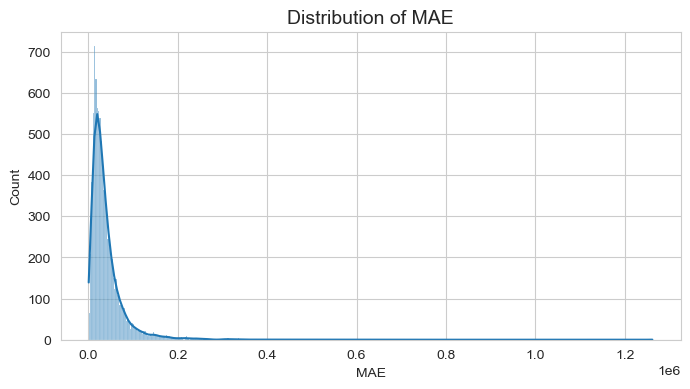

In [89]:
#exploratory data analysis: plot the distribution of MAE
sb.set_style('whitegrid')
sb.histplot(x=evaluation_results_reg['MAE'],
           kde = True)
plt.title('Distribution of MAE', fontdict = {'fontsize': 14})
plt.plot()

In [90]:
#review the previously created predictions
print(predictions_reg.dtypes)
print(predictions_reg)

ds             object
y             float64
RegionName     object
CPI           float64
dtype: object
                        ds              y RegionName    CPI
2052            1997-01-01  179587.416656       1002  159.1
10805           1997-02-01  180783.434078       1002  159.6
19558           1997-03-01  181443.971258       1002  160.0
28311           1997-04-01  180284.970221       1002  160.2
37064           1997-05-01  181319.532410       1002  160.1
...                    ...            ...        ...    ...
293    2021-08-01 00:00:00  496594.632083      99587  160.5
294    2021-09-01 00:00:00  496601.306685      99587  160.3
295    2021-10-01 00:00:00  496600.939993      99587  160.1
296    2021-11-01 00:00:00  496605.445502      99587  160.2
297    2021-12-01 00:00:00  496604.995848      99587  160.0

[2625900 rows x 4 columns]


In [91]:
#perform group by to get average median housing value per year
predictions_reg['Year'] = predictions_reg['ds'].str[:4]
predictions_reg['Year'] = predictions_reg['Year'].apply(pd.to_numeric)
predictions_reg = predictions_reg[['RegionName','Year','y','CPI']]

#aggarate data by year to get the average housing price each year in each zip code
grouped_all_reg = predictions_reg.groupby(['RegionName','Year']).agg('mean')
grouped_all_reg = grouped_all_reg.reset_index()
print(grouped_all_reg)

# pivot table to have each year's value having their own columns
df_by_year_reg = grouped_all_reg.pivot(index='RegionName', columns='Year', values='y')
df_by_year_reg = df_by_year_reg.rename_axis("", axis="columns")
print(df_by_year_reg)

        RegionName    Year              y         CPI
0             1002  1997.0  183227.745364  160.516667
1             1002  1998.0  186863.827129  163.008333
2             1002  1999.0  195908.210501  166.575000
3             1002  2000.0  211916.151874  172.200000
4             1002  2001.0  225808.700267  177.066667
...            ...     ...            ...         ...
210067       99587  2016.0  392761.293204  240.007167
210068       99587  2017.0  398457.053486  245.119583
210069       99587  2018.0  408899.168529  251.106833
210070       99587  2019.0  452503.276663  255.657417
210071       99587  2020.0  461541.618848  258.811167

[210072 rows x 4 columns]
                   1997.0         1998.0         1999.0         2000.0  \
RegionName                                                               
1002        183227.745364  186863.827129  195908.210501  211916.151874   
1005        116354.082469  124322.435022  131684.595047  144795.261312   
1007        147114.009005  15

In [92]:
#Performed additional cleaning
df_by_year_reg['RegionName'] = df_by_year_reg.index
df_by_year_reg= df_by_year_reg.set_index([pd.Index(list(range(8753)))])

# create new variables for changes in average housing values between predicted year and last available year
df_by_year_reg['1Y_ROI'] = df_by_year_reg.iloc[:,-2]/df_by_year_reg.iloc[:,-3] - 1
df_by_year_reg['5Y_ROI'] = df_by_year_reg.iloc[:,-3]/df_by_year_reg.iloc[:,-8] - 1

# return the top 3 records when ranking by 1 year return
print('\nTop 3 Zip Codes With Highest 1-Year Return on Investment: ')
model2_top3_1y = df_by_year_reg.nlargest(3, '1Y_ROI', keep='last')[['RegionName','1Y_ROI']]
print(model2_top3_1y)


# return the top 3 records when ranking by 5 year return
print('\nTop 3 Zip Codes With Highest 5-Year Return on Investment: ')
model2_top3_5y = df_by_year_reg.nlargest(3, '5Y_ROI', keep='last')[['RegionName','5Y_ROI']]
print(model2_top3_5y)


Top 3 Zip Codes With Highest 1-Year Return on Investment: 
      RegionName    1Y_ROI
1897       14752  0.365759
8084       94940  0.335876
968         8349  0.329278

Top 3 Zip Codes With Highest 5-Year Return on Investment: 
      RegionName    5Y_ROI
3394       30314  3.622599
4715       43205  3.068520
5269       48202  2.679074


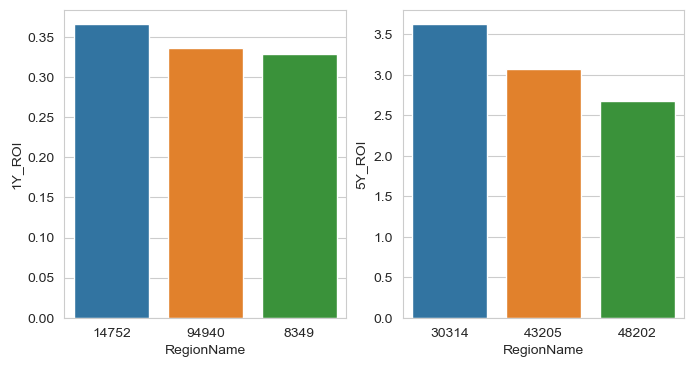

In [93]:
#Create a bar plot
fig, axs = plt.subplots(ncols=2)
sb.barplot(x="RegionName",
           y="1Y_ROI",
           data = model2_top3_1y,
          order = model2_top3_1y.sort_values('1Y_ROI',ascending = False).RegionName,
           ax=axs[0])
sb.barplot(x="RegionName",
           y="5Y_ROI",
           data = model2_top3_5y,
          order = model2_top3_5y.sort_values('5Y_ROI',ascending = False).RegionName, 
           ax=axs[1])
plt.show()

In [94]:
#create a dataframe for three zip code with highest 1-year ROI
top1_region = 14752
top2_region = 94940
top3_region = 8349

top3_results_reg = top3_df(grouped_all_reg,top1_region,top2_region,top3_region)
print(top3_results_reg)

                Top1          Top2           Top3
year                                             
1997.0  15849.774907  4.059790e+05   59821.067783
1998.0  16060.910199  4.268683e+05   59042.125629
1999.0  15577.605161  4.541929e+05   67122.151373
2000.0  14363.395325  4.939486e+05   63478.181308
2001.0  14737.542217  5.585244e+05   64087.818928
2002.0  15692.557372  6.187538e+05   51344.472503
2003.0  15651.555950  7.254736e+05   59249.192878
2004.0  17346.120604  7.164707e+05   69695.433684
2005.0  18583.084366  8.286975e+05   90211.112406
2006.0  21605.226600  8.728524e+05  116374.307319
2007.0  17885.673598  7.192796e+05  111468.001351
2008.0  17480.140551  6.824959e+05  102055.033374
2009.0  16390.014954  6.050227e+05   95759.647477
2010.0  16839.798169  5.713279e+05   90891.100836
2011.0  18138.558822  5.031058e+05   90081.326394
2012.0  22264.282550  5.218977e+05   88894.891691
2013.0  25136.870518  6.393198e+05   87775.955268
2014.0  22969.723803  7.093416e+05   85039.712723


In [95]:
top3_records_reg = pd.DataFrame()
top3_records_reg = pd.concat([top3_records_reg,
                              record_by_region(final_df, top1_region),
                              record_by_region(final_df, top2_region),
                              record_by_region(final_df, top3_region)])
print(top3_records_reg)

      RegionName State         City                               Metro
8545       14752    NY    Lily Dale      Jamestown-Dunkirk-Fredonia, NY
8425       94940    CA     Marshall  San Francisco-Oakland-Berkeley, CA
7210        8349    NJ  Port Norris              Vineland-Bridgeton, NJ


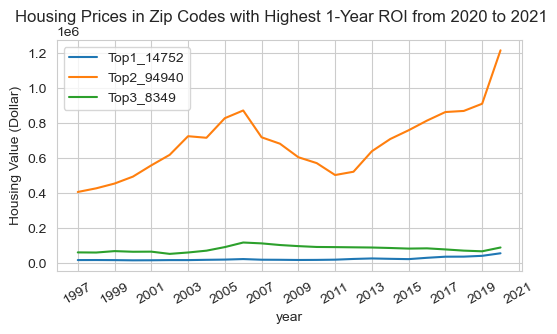

In [96]:
# Line plots of time series
top3_results_reg = top3_results_reg.rename(columns={"Top1":"Top1_14752", 
                                                    "Top2": "Top2_94940",
                                                   "Top3":"Top3_8349"})                                                    
fig, ax = plt.subplots(figsize=(6,3))
x = [1997,1999,2001,2003,2005,2007,2009,2011,2013,2015,2017,2019,2021]
fig.suptitle('Housing Prices in Zip Codes with Highest 1-Year ROI from 2020 to 2021')
top3_results_reg.plot(ax=ax)
plt.xticks(x)
plt.xticks(rotation = 30)
plt.ylabel('Housing Value (Dollar)')
plt.show()

In [97]:
#check the MAE and RMSE values for these three areas
top3_records_reg_MAE = pd.DataFrame()
top3_records_reg_MAE = pd.concat([top3_records_reg_MAE,
                                  evaluation_results_reg[evaluation_results_reg['RegionName'] == top1_region],
                                  evaluation_results_reg[evaluation_results_reg['RegionName'] == top2_region],
                                  evaluation_results_reg[evaluation_results_reg['RegionName'] == top3_region]])
print(top3_records_reg_MAE)

  RegionName           MAE           RMSE
0      14752  11019.921186   12698.706701
0      94940  96491.594431  111507.084148
0       8349  10617.089807   12251.788677


In [98]:
#check the top records with highest 5-year return
top1_region = 30314
top2_region = 43205
top3_region = 48202

top3_results_reg2 = top3_df(grouped_all_reg,top1_region,top2_region,top3_region)
print(top3_results_reg2)

                 Top1           Top2           Top3
year                                               
1997.0   45591.774228   40203.042248    8449.204362
1998.0   50157.572497   47372.177197   10694.710464
1999.0   58081.392944   55696.680726   15758.703595
2000.0   65955.315201   56697.595081   25398.058374
2001.0   72717.113049   61264.603190   29074.862234
2002.0   81749.206593   60143.306466   27775.671631
2003.0   93697.173336   66437.454108   31903.320617
2004.0  110873.046708   70712.576026   33434.297264
2005.0  123696.359938   76017.729207   35069.823659
2006.0  133628.933966   83879.681039   39675.792837
2007.0  123336.565333   85836.024997   37242.487447
2008.0   87861.570331   71593.585590   28064.768376
2009.0   52591.028546   62487.397633   25735.906203
2010.0   40243.591177   56199.468692   31530.867451
2011.0   32996.354314   49659.687698   26634.132002
2012.0   32406.531070   39148.340253   27370.313441
2013.0   40996.577072   42073.969778   29759.175593
2014.0   444

In [99]:
top3_records_reg2 = pd.DataFrame()
top3_records_reg2 = pd.concat([top3_records_reg2,
                               record_by_region(final_df, top1_region),
                               record_by_region(final_df, top2_region),
                               record_by_region(final_df, top3_region)])
print(top3_records_reg2)

      RegionName State      City                                 Metro
2924       30314    GA   Atlanta  Atlanta-Sandy Springs-Alpharetta, GA
4299       43205    OH  Columbus                          Columbus, OH
3827       48202    MI   Detroit           Detroit-Warren-Dearborn, MI


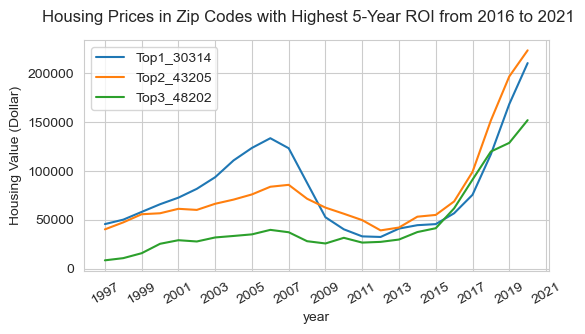

In [100]:
# Line plots of time series
top3_results_reg2 = top3_results_reg2.rename(columns={"Top1":"Top1_30314", 
                                                    "Top2": "Top2_43205",
                                                   "Top3":"Top3_48202"})     
fig, ax = plt.subplots(figsize=(6,3))
x = [1997,1999,2001,2003,2005,2007,2009,2011,2013,2015,2017,2019,2021]
fig.suptitle('Housing Prices in Zip Codes with Highest 5-Year ROI from 2016 to 2021')
top3_results_reg2.plot(ax=ax)
plt.xticks(x)
plt.xticks(rotation = 30)
plt.ylabel('Housing Value (Dollar)')
plt.show()

### Top 3 Zip Cods Identified Using Acutal Data

In [101]:
# extract data before 2022
model_data_new = final_df[final_df['Year'] < 2022]

#perform group by to get average median housing value per year
model_data_new['Year'] = model_data_new['Year'].apply(pd.to_numeric)
model_data_new = model_data_new[['RegionName','Year','Value',]]

grouped_model_data = model_data_new.groupby(['RegionName','Year']).agg('mean')
grouped_model_data = grouped_model_data.reset_index()
print(grouped_model_data)

# pivot table to have each year's value having their own columns
df_by_year_actual = grouped_model_data.pivot(index='RegionName', columns='Year', values='Value')
df_by_year_actual = df_by_year_actual.rename_axis("", axis="columns")
print(df_by_year_actual)

        RegionName  Year          Value
0             1002  1997  183227.745364
1             1002  1998  186863.827129
2             1002  1999  195908.210501
3             1002  2000  211916.151874
4             1002  2001  225808.700267
...            ...   ...            ...
218820       99587  2017  398457.053486
218821       99587  2018  408899.168529
218822       99587  2019  452503.276663
218823       99587  2020  461541.618848
218824       99587  2021  479398.105875

[218825 rows x 3 columns]
                     1997           1998           1999           2000  \
RegionName                                                               
1002        183227.745364  186863.827129  195908.210501  211916.151874   
1005        116354.082469  124322.435022  131684.595047  144795.261312   
1007        147114.009005  154014.173897  161476.085557  171818.766655   
1008        126085.470478  132088.703836  132880.832222  143252.220168   
1010        133563.741000  141256.578035  142840.

/var/folders/y8/cd5c88x13jv_2hylndg95v5r0000gn/T/ipykernel_14511/1069418438.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_new['Year'] = model_data_new['Year'].apply(pd.to_numeric)


In [102]:
#Performed additional cleaning
df_by_year_actual['RegionName'] = df_by_year_actual.index
df_by_year_actual= df_by_year_actual.set_index([pd.Index(list(range(8753)))])

# create new variables for changes in average housing values between predicted year and last available year
df_by_year_actual['1Y_ROI'] = df_by_year_actual.iloc[:,-2]/df_by_year_actual.iloc[:,-3] - 1
df_by_year_actual['5Y_ROI'] = df_by_year_actual.iloc[:,-2]/df_by_year_actual.iloc[:,-7] - 1

# return the top 3 records when ranking by 1 year return
print('\nTop 3 Zip Codes With Highest 1-Year Return on Investment: ')
actual_top3_1y = df_by_year_actual.nlargest(3, '1Y_ROI', keep='last')[['RegionName','1Y_ROI']]
print(actual_top3_1y)


# return the top 3 records when ranking by 5 year return
print('\nTop 3 Zip Codes With Highest 5-Year Return on Investment: ')
actual_top3_5y = df_by_year_actual.nlargest(3, '5Y_ROI', keep='last')[['RegionName','5Y_ROI']]
print(actual_top3_5y)


Top 3 Zip Codes With Highest 1-Year Return on Investment: 
      RegionName    1Y_ROI
6773       78615  0.574195
5546       53233  0.486863
4495       38105  0.478153

Top 3 Zip Codes With Highest 5-Year Return on Investment: 
      RegionName    5Y_ROI
6126       72359  1.834111
5324       48504  1.514491
6144       72464  1.303452


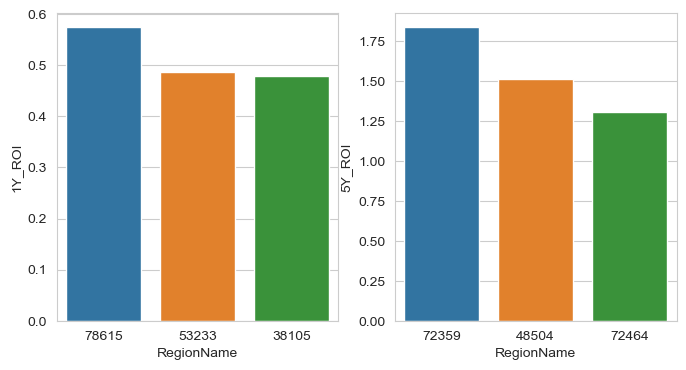

In [103]:
#Create a bar plot
fig, axs = plt.subplots(ncols=2)
sb.barplot(x="RegionName",
           y="1Y_ROI",
           data = actual_top3_1y,
          order = actual_top3_1y.sort_values('1Y_ROI',ascending = False).RegionName,
           ax=axs[0])
sb.barplot(x="RegionName",
           y="5Y_ROI",
           data = actual_top3_5y,
          order = actual_top3_5y.sort_values('5Y_ROI',ascending = False).RegionName, 
           ax=axs[1])
plt.show()

In [104]:
#create a plot for top 3 zip codes
def top3_df_actual (df, top1, top2, top3):
    # Create a dataframe to save the records for top 3 zip codes
    predictions1 = df[df['RegionName'] == top1].reset_index()
    predictions2 = df[df['RegionName'] == top2].reset_index()
    predictions3 = df[df['RegionName'] == top3].reset_index()

    year = predictions1['Year']
    Top1 = predictions1['Value']
    Top2 = predictions2['Value']
    Top3 = predictions3['Value']
    
    # Create DataFrame
    df_final = pd.DataFrame({'year': year,
                        'Top1': Top1,
                        'Top2': Top2,
                        'Top3': Top3
                       })

    df_final = df_final.set_index('year')
    return(df_final)


In [105]:
#check top three results with highest 1-year ROI
top1_region = 78615
top2_region = 53233
top3_region = 38105

top3_results_actual = top3_df_actual(grouped_model_data, top1_region,top2_region,top3_region)
print(top3_results_actual)

               Top1           Top2           Top3
year                                             
1997  132546.740286   38310.335630  150051.433792
1998  133026.220098   44178.091121  162157.083709
1999  144644.205836   44396.770320  198235.935703
2000  152225.719030   45918.528212  221024.525923
2001  155026.349251   46148.378807  236121.197486
2002  158001.899994   53068.196096  222634.809245
2003  156975.020397   59933.661646  200859.557948
2004  163176.639572   68835.285542  154044.617701
2005  168874.702383   83949.241915  108977.500614
2006  167321.162403  101086.458865   97135.640565
2007  185216.811323  111934.523910   87726.930331
2008  186578.812886  114187.203556   72543.102701
2009  179031.034553   98750.449784   58480.875991
2010  170340.720107   83336.316602   45159.086958
2011  166589.293662   65085.265183   39974.502240
2012  188149.314179   55307.715649   35117.328323
2013  190014.448311   50108.156298   36945.971841
2014  207153.680019   55110.772119   41993.351697


In [106]:
top3_records = pd.DataFrame()
top3_records = pd.concat([top3_records,
                          record_by_region(final_df, top1_region),
                          record_by_region(final_df, top2_region),
                          record_by_region(final_df, top3_region)])
print(top3_records)

      RegionName State       City                             Metro
7209       78615    TX   Coupland  Austin-Round Rock-Georgetown, TX
4056       53233    WI  Milwaukee            Milwaukee-Waukesha, WI
5491       38105    TN    Memphis                 Memphis, TN-MS-AR


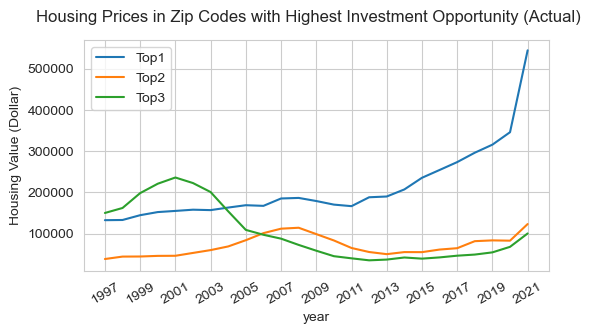

In [107]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(6,3))
x = [1997,1999,2001,2003,2005,2007,2009,2011,2013,2015,2017,2019,2021]
fig.suptitle('Housing Prices in Zip Codes with Highest Investment Opportunity (Actual)')
top3_results_actual.plot(ax=ax)
plt.xticks(x)
plt.xticks(rotation = 30)
plt.ylabel('Housing Value (Dollar)')
plt.show()

### Create a map to visualize ROI by state (using results from the second model)

In [108]:
import geoplot as gplt
import geoplot.crs as gcrs
import geopandas as gpd

In [109]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))
print(contiguous_usa.head())

          state adm1_code  population  \
0     Minnesota  USA-3514     5303925   
1       Montana  USA-3515      989415   
2  North Dakota  USA-3516      672591   
3         Idaho  USA-3518     1567582   
4    Washington  USA-3519     6724540   

                                            geometry  
0  POLYGON ((-89.59941 48.01027, -89.48888 48.013...  
1  POLYGON ((-111.19419 44.56116, -111.29155 44.7...  
2  POLYGON ((-96.60136 46.35136, -96.53891 46.199...  
3  POLYGON ((-111.04973 44.48816, -111.05025 42.0...  
4  POLYGON ((-116.99807 46.33017, -116.90653 46.1...  


In [110]:
#read state name data
state_name = pd.read_csv('state_name.csv', sep = ',', header = 0)

print(state_name.head())
print(state_name.shape)

        State Postal
0     Alabama     AL
1      Alaska     AK
2     Arizona     AZ
3    Arkansas     AR
4  California     CA
(55, 2)


In [111]:
state_name = state_name.rename(columns={"State": "state", "Postal": "State"})
new_contiguous_usa = pd.merge(contiguous_usa, state_name, how="inner", on=["state"])
print(new_contiguous_usa.head())

          state adm1_code  population  \
0     Minnesota  USA-3514     5303925   
1       Montana  USA-3515      989415   
2  North Dakota  USA-3516      672591   
3         Idaho  USA-3518     1567582   
4    Washington  USA-3519     6724540   

                                            geometry State  
0  POLYGON ((-89.59941 48.01027, -89.48888 48.013...    MN  
1  POLYGON ((-111.19419 44.56116, -111.29155 44.7...    MT  
2  POLYGON ((-96.60136 46.35136, -96.53891 46.199...    ND  
3  POLYGON ((-111.04973 44.48816, -111.05025 42.0...    ID  
4  POLYGON ((-116.99807 46.33017, -116.90653 46.1...    WA  


In [112]:
grouped_final_df = final_df.groupby(['State','RegionName','Year']).agg('mean')
grouped_final_df = grouped_final_df.reset_index()
grouped_final_df = grouped_final_df[grouped_final_df['Year'] == 2021]
print(grouped_final_df.head())

    State  RegionName  Year  SizeRank          Value
24     AK       99587  2021   23367.0  479398.105875
50     AL       35062  2021   11208.0  194430.126068
76     AL       35111  2021    8634.0  254026.787814
102    AL       35130  2021   15909.0  128073.568740
128    AL       35188  2021   15222.0  191643.691422


In [116]:
#create dataframe for the map
df_by_year_map1 = df_by_year_reg[['RegionName','1Y_ROI','5Y_ROI']]
df_by_year_map2 = pd.merge(grouped_final_df, df_by_year_map1, how="inner", on=['RegionName'])
print(df_by_year_map2.head())

df_by_year_map3 = df_by_year_map2.groupby(['State']).agg('mean')
df_by_year_map3['State'] = df_by_year_map3.index
df_by_year_map3 = df_by_year_map3.reset_index(drop = True)
new_contiguous_usa_map = pd.merge(new_contiguous_usa, df_by_year_map3, how="inner", on=['State'])
print(new_contiguous_usa_map.head())

  State  RegionName  Year  SizeRank          Value    1Y_ROI    5Y_ROI
0    AK       99587  2021   23367.0  479398.105875  0.019974  0.202517
1    AL       35062  2021   11208.0  194430.126068  0.067592  0.253047
2    AL       35111  2021    8634.0  254026.787814  0.063225  0.219201
3    AL       35130  2021   15909.0  128073.568740  0.083540  0.253874
4    AL       35188  2021   15222.0  191643.691422  0.056343  0.211985
        state adm1_code  population  \
0   Minnesota  USA-3514     5303925   
1       Idaho  USA-3518     1567582   
2  Washington  USA-3519     6724540   
3     Arizona  USA-3520     6392017   
4  California  USA-3521    37253956   

                                            geometry State    RegionName  \
0  POLYGON ((-89.59941 48.01027, -89.48888 48.013...    MN  55425.978102   
1  POLYGON ((-111.04973 44.48816, -111.05025 42.0...    ID  83483.400000   
2  POLYGON ((-116.99807 46.33017, -116.90653 46.1...    WA  98393.851163   
3  POLYGON ((-109.04523 36.99991, -

In [117]:
print(new_contiguous_usa_map.nlargest(8, '1Y_ROI', keep='last'))

           state adm1_code  population  \
3        Arizona  USA-3520     6392017   
2     Washington  USA-3519     6724540   
8           Utah  USA-3526     2763885   
31     Tennessee  USA-3551     6346105   
11        Kansas  USA-3530     2853118   
20  Rhode Island  USA-3539     1052567   
41         Maine  USA-3561     1328361   
30          Ohio  USA-3550    11536504   

                                             geometry State    RegionName  \
3   POLYGON ((-109.04523 36.99991, -109.04367 31.3...    AZ  85526.036269   
2   POLYGON ((-116.99807 46.33017, -116.90653 46.1...    WA  98393.851163   
8   POLYGON ((-109.05318 41.00199, -109.04523 36.9...    UT  84140.363636   
31  POLYGON ((-81.67938 36.58557, -81.70477 36.460...    TN  37763.732877   
11  POLYGON ((-94.60481 39.13986, -94.61538 38.068...    KS  66539.600000   
20  POLYGON ((-71.14790 41.64759, -71.12038 41.494...    RI   2866.491525   
41  POLYGON ((-67.13734 45.13745, -66.96466 44.809...    ME   4335.690141   
30  P

Text(0.5, 1.0, 'Prediction of 1-Year 2020-2021 ROI for Housing Prices in US')

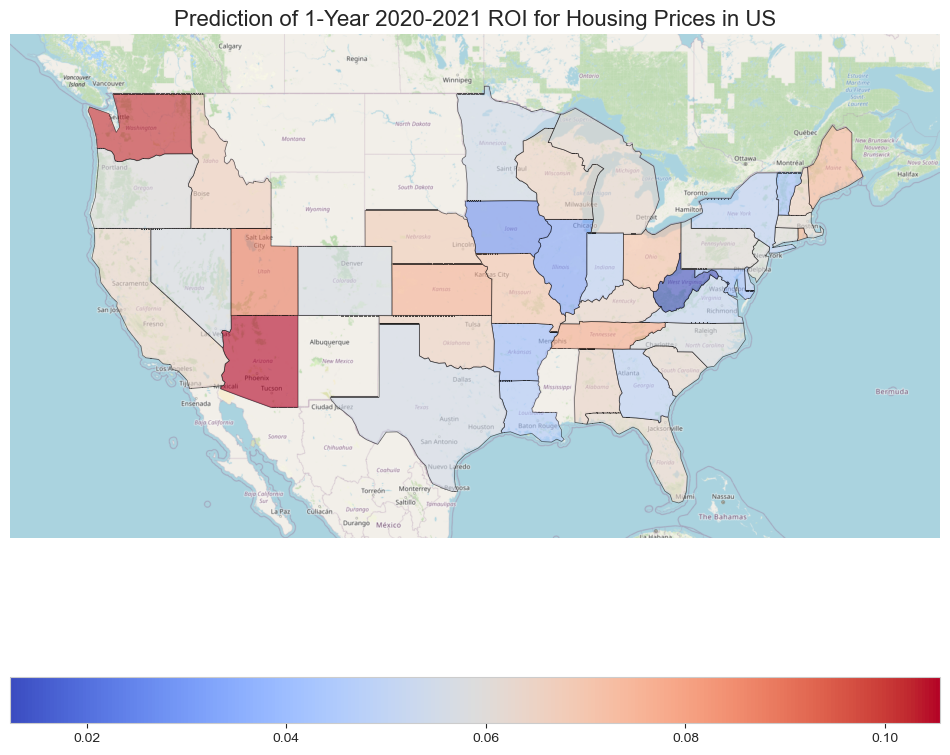

In [118]:
#Create the Map
#ax = gplt.polyplot(new_contiguous_usa_map, projection=gcrs.AlbersEqualArea())
ax = gplt.webmap(contiguous_usa, figsize=(12, 12), projection=gcrs.WebMercator())
gplt.choropleth(
    new_contiguous_usa_map,
    hue="1Y_ROI",
    edgecolor="black",
    linewidth=0.5,
    alpha = 0.6,
    cmap="coolwarm",
    legend=True,
    legend_kwargs={'orientation': 'horizontal'},
    projection=gcrs.AlbersEqualArea(),
    ax=ax
)
ax.set_title("Prediction of 1-Year 2020-2021 ROI for Housing Prices in US", fontsize=16)

Text(0.5, 1.0, 'Prediction of 5-Year 2016-2021 ROI for Housing Prices in US')

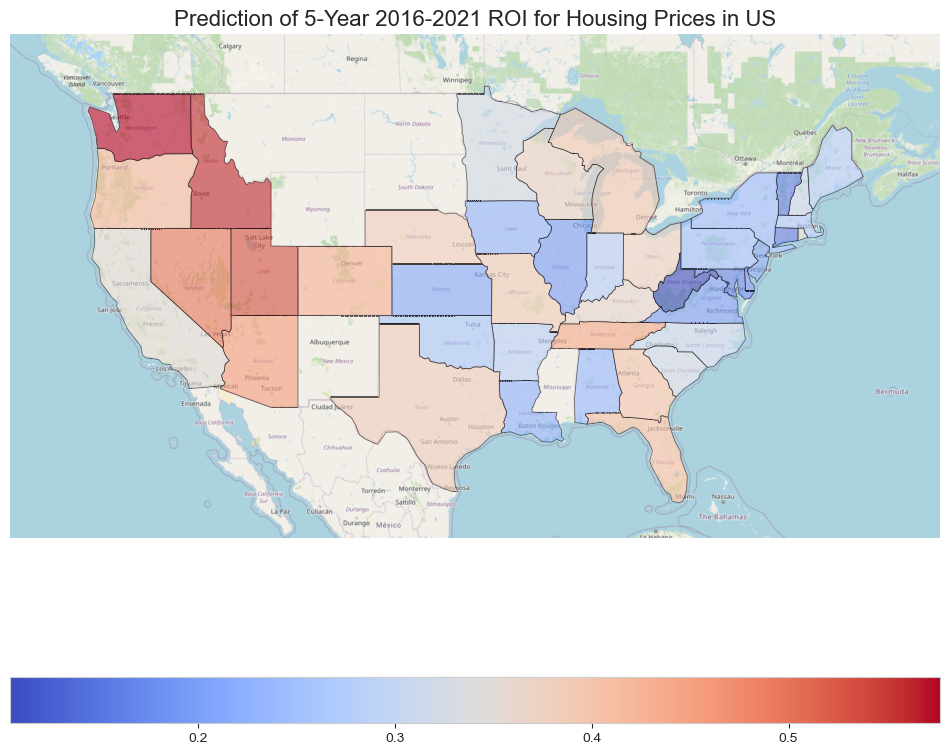

In [119]:
#Create the Map
#ax = gplt.polyplot(new_contiguous_usa_map, projection=gcrs.AlbersEqualArea())
ax = gplt.webmap(contiguous_usa, figsize=(12, 12), projection=gcrs.WebMercator())
gplt.choropleth(
    new_contiguous_usa_map,
    hue="5Y_ROI",
    edgecolor="black",
    linewidth=0.5,
    alpha = 0.6,
    cmap="coolwarm",
    legend=True,
    legend_kwargs={'orientation': 'horizontal'},
    projection=gcrs.AlbersEqualArea(),
    ax=ax
)
ax.set_title("Prediction of 5-Year 2016-2021 ROI for Housing Prices in US", fontsize=16)

Text(0.5, 1.0, 'Average 2021 Predicted Housing Prices in US')

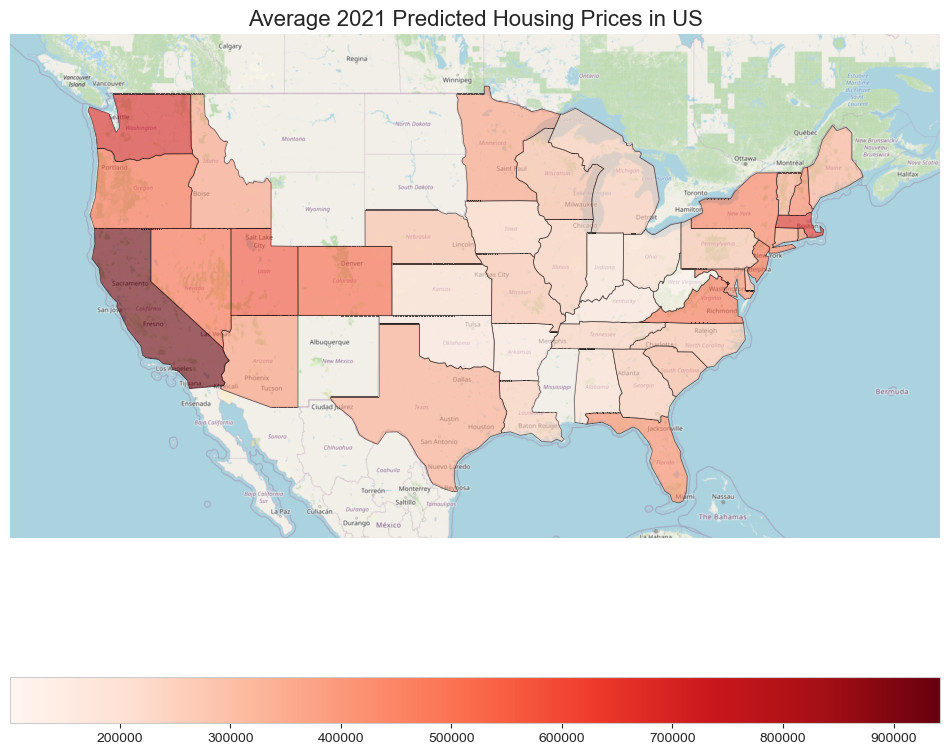

In [120]:
#Create the Map
#ax = gplt.polyplot(new_contiguous_usa_map, projection=gcrs.AlbersEqualArea())
ax = gplt.webmap(contiguous_usa, figsize=(12, 12), projection=gcrs.WebMercator())
gplt.choropleth(
    new_contiguous_usa_map,
    hue="Value",
    edgecolor="black",
    linewidth=0.5,
    alpha = 0.6,
    cmap="Reds",
    legend=True,
    legend_kwargs={'orientation': 'horizontal'},
    projection=gcrs.AlbersEqualArea(),
    ax=ax
)
ax.set_title("Average 2021 Predicted Housing Prices in US", fontsize=16)